In [1]:
## Update matplotlib to a version that can label bar graphs.
#!pip install -U matplotlib --user
## Install pydoe2
#!pip install pyDOE2

In [2]:
%matplotlib inline

import sympy as sp
sp.init_printing(use_latex ='mathjax')
import scipy as sc
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lmfit as lf
import os
import seaborn as sns
from myheatmap import myheatmap
from lmfit import Model
import lmfit
import matplotlib
import math
from scipy.signal import find_peaks
from datetime import datetime
from time import time
import pyDOE2
import sys
from decimal import Decimal

verbose = False
MONOMER = False
forceboth = False

sns.set_context('talk')

savefolder = r'G:\Shared drives\Horowitz Lab Notes\Horowitz, Viva - notes and files'

matplotlib.__version__ ## Need version 3.5 for labeled bargraphs. otherwise please set labelbarchart = False below

'3.5.1'

In [3]:
# uncomment to see what versions you are running
"""for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass"""
            
""" # I am running these versions in July 2022. ~Viva
ipykernel._version 5.3.4
re 2.2.1
json 2.0.9
IPython.core.release 7.22.0
logging 0.5.1.2
zlib 1.0
traitlets._version 5.0.5
traitlets 5.0.5
argparse 1.1
ipython_genutils._version 0.2.0
ipython_genutils 0.2.0
platform 1.0.8
pygments 2.8.1
_ctypes 1.1.0
ctypes 1.1.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
wcwidth 0.2.5
prompt_toolkit 3.0.17
parso 0.7.0
jedi 0.17.2
urllib.request 3.8
IPython 7.22.0
jupyter_client._version 6.1.12
zmq.backend.cython.constants 40303
zmq.backend.cython 40303
zmq.sugar.constants 40303
zmq.sugar.version 20.0.0
zmq.sugar 20.0.0
zmq 20.0.0
jupyter_core.version 4.7.1
jupyter_core 4.7.1
jupyter_client 6.1.12
ipykernel 5.3.4
colorama 0.4.4
dateutil 2.8.1
six 1.15.0
_decimal 1.70
decimal 1.70
distutils 3.8.8
mkl 2.3.0
numpy.core._multiarray_umath 3.1
numpy.core 1.20.1
numpy.linalg._umath_linalg 0.1.5
numpy.lib 1.20.1
numpy 1.20.1
packaging.__about__ 20.9
packaging 20.9
PIL._version 8.2.0
PIL 8.2.0
xml.etree.ElementTree 1.3.0
cffi 1.14.5
PIL.Image 8.2.0
pyparsing 2.4.7
cycler 0.10.0
kiwisolver 1.3.1
matplotlib 3.5.1
mpmath 1.2.1
sympy.release 1.8
sympy.multipledispatch 0.4.9
sympy 1.8
scipy 1.6.2
scipy._lib.decorator 4.0.5
scipy.linalg._fblas b'$Revision: $'
scipy.linalg._flapack b'$Revision: $'
scipy.linalg._flinalg b'$Revision: $'
scipy.special.specfun b'$Revision: $'
scipy.ndimage 2.0
scipy.optimize.minpack2 b'$Revision: $'
scipy.sparse.linalg.isolve._iterative b'$Revision: $'
scipy.sparse.linalg.eigen.arpack._arpack b'$Revision: $'
scipy.optimize._lbfgsb b'$Revision: $'
scipy.optimize._cobyla b'$Revision: $'
scipy.optimize._slsqp b'$Revision: $'
scipy.optimize._minpack  1.10 
scipy.optimize.__nnls b'$Revision: $'
scipy.linalg._interpolative b'$Revision: $'
scipy.integrate._odepack  1.9 
scipy.integrate._quadpack  1.13 
scipy.integrate.vode b'$Revision: $'
scipy.integrate._dop b'$Revision: $'
scipy.integrate.lsoda b'$Revision: $'
scipy.integrate._ode $Id$
scipy.interpolate._fitpack  1.7 
scipy.interpolate.dfitpack b'$Revision: $'
scipy.stats.statlib b'$Revision: $'
scipy.stats.mvn b'$Revision: $'
pytz 2021.1
pandas.compat.numpy.function 1.20.1
bottleneck 1.3.2
_csv 1.0
csv 1.0
pandas 1.2.4
asteval._version 0.9.25
asteval 0.9.25
future 0.18.2
past 0.18.2
uncertainties 3.1.6
lmfit 1.0.2
seaborn.external.husl 2.1.0
statsmodels 0.12.2
ipywidgets._version 7.6.3
ipywidgets 7.6.3
seaborn 0.11.1
scipy._lib._uarray 0.5.1+49.g4c3f1d7.scipy
scipy.signal.spline 0.2
""";

In [4]:
def syserr(x_found,x_set):
    return 100*abs(x_found-x_set)/x_set

def combinedsyserr(syserrs, notdof): # notdof = not degrees of freedom, meaning the count of fixed parameters.
    assert len(syserrs) > 0
    assert notdof > 0
    abssyserrs = [abs(err) for err in syserrs]
    dof = len(syserrs) - notdof # fixed parameters have a systematic err of zero; don't count them as free parameters.
    assert dof > 0
    squared = [(err**2) for err in syserrs]
    rms = np.sqrt(sum(squared) / dof)
    avg = sum(abssyserrs)/ dof
    
    syserrs = [i for _,i in sorted(zip(abssyserrs,syserrs))]
    while notdof >0:
        syserrs.pop(0) # remove small values
        notdof = notdof -1
    assert len(syserrs) == dof
    Lavg =  np.log10(sum([10**(Decimal(err)) for err in syserrs])/dof)
   
    return avg, rms, max(abssyserrs), Lavg

def complexamp(A,phi):
    return A * np.exp(1j*phi)

def amp(a,b):
    return np.sqrt(a**2 + b**2)

def A_from_Z(Z): # calculate amplitude of complex number
    return amp(Z.real, Z.imag)

def rsqrd(model, data, plot=False, x=None, newfigure = True):
    SSres = sum((data - model)**2)
    SStot = sum((data - np.mean(data))**2)
    rsqrd = 1 - (SSres/ SStot)
    
    if plot:
        if newfigure:
            plt.figure()
        plt.plot(x,data, 'o')
        plt.plot(x, model, '--')
    
    return rsqrd

# For driven, damped oscillator: res_freq = sqrt(k/m - b^2/(2m^2))
# Note: Requires b < sqrt(2mk) to be significantly underdamped
# Otherwise there is no resonant frequency and we get an err from the negative number under the square root
# This works for monomer and for weak coupling. It does not work for strong coupling.
# Uses privilege. See also res_freq_numeric()
def res_freq_weak_coupling(k, m, b):
    try:
        w = math.sqrt(k/m - (b*b)/(2*m*m))
    except:
        w = np.nan
        print('no resonance frequency for k=', k, ', m=', m, ' b=', b)
    return w

## source: https://en.wikipedia.org/wiki/Q_factor#Mechanical_systems
# Does not work for strong coupling.
def approx_Q(k, m, b):
    return math.sqrt(m*k)/b

# Approximate width of Lorentzian peak.
# Does not work for strong coupling.
def approx_width(k, m, b):
    return res_freq_weak_coupling(k, m, b) / approx_Q(k, m, b)

def quadratic_formula(a, b, c):
    return (-b + math.sqrt(b*b - 4*a*c))/(2*a), (-b - math.sqrt(b*b - 4*a*c))/(2*a)

"""Zmatrix2resonators(df) will return a matrix for svd for any number of frequency measurements, 
listed in each row of the dataframe measurementdf 
If forceboth is true then both masses receive a force.
parameternames = ['m1', 'm2', 'b1', 'b2', 'k1', 'k2','c12', 'Driving Force']
"""
def Zmatrix2resonators(measurementdf, 
                       frequencycolumn = 'drive', 
                       complexamplitude1 = 'R1AmpCom', complexamplitude2 = 'R2AmpCom', forceboth = forceboth, dtype=complex):
    Zmatrix = []
    for rowindex in measurementdf.index:
        w = measurementdf[frequencycolumn][rowindex]
        #print(w)
        ZZ1 = measurementdf[complexamplitude1][rowindex]
        ZZ2 = measurementdf[complexamplitude2][rowindex]
        Zmatrix.append([-w**2*np.real(ZZ1), 0, -w*np.imag(ZZ1), 0, np.real(ZZ1), 0, np.real(ZZ1)-np.real(ZZ2), -1])
        Zmatrix.append([-w**2*np.imag(ZZ1), 0, w*np.real(ZZ1), 0, np.imag(ZZ1), 0, np.imag(ZZ1)-np.imag(ZZ2), 0])
        if forceboth:
            Zmatrix.append([0, -w**2*np.real(ZZ2), 0, -w*np.imag(ZZ2), 0, np.real(ZZ2), np.real(ZZ2)-np.real(ZZ1), -1])
        else:
            Zmatrix.append([0, -w**2*np.real(ZZ2), 0, -w*np.imag(ZZ2), 0, np.real(ZZ2), np.real(ZZ2)-np.real(ZZ1), 0])
        Zmatrix.append([0, -w**2*np.imag(ZZ2), 0, w*np.real(ZZ2), 0, np.imag(ZZ2), np.imag(ZZ2)-np.imag(ZZ1), 0])
    #display(Zmatrix)
    return np.array(Zmatrix, dtype=dtype)

"""ZmatrixMONOMER(df) will return a matrix for svd for any number of frequency measurements, 
listed in each row of the dataframe measurementdf 
parameternames = ['m1', 'b1', 'k1', 'Driving Force']
"""
def ZmatrixMONOMER(measurementdf, 
                       frequencycolumn = 'drive', 
                       complexamplitude1 = 'R1AmpCom', dtype=complex):
    Zmatrix = []
    for rowindex in measurementdf.index:
        w = measurementdf[frequencycolumn][rowindex]
        #print(w)
        ZZ1 = measurementdf[complexamplitude1][rowindex]
        Zmatrix.append([-w**2*np.real(ZZ1), -w*np.imag(ZZ1), np.real(ZZ1), -1])
        Zmatrix.append([-w**2*np.imag(ZZ1),  w*np.real(ZZ1), np.imag(ZZ1),  0])
    #display(Zmatrix)
    return np.array(Zmatrix, dtype=dtype)

def Zmat(measurementdf, 
         frequencycolumn = 'drive', complexamplitude1 = 'R1AmpCom', complexamplitude2 = 'R2AmpCom', dtype=complex, 
         MONOMER=MONOMER, forceboth=forceboth):
    if MONOMER:
        return ZmatrixMONOMER(measurementdf=measurementdf, 
                       frequencycolumn = frequencycolumn, # can't force both when there aren't two masses
                       complexamplitude1 =complexamplitude1, dtype=dtype)
    else:
        return Zmatrix2resonators(measurementdf=measurementdf, 
                       frequencycolumn = frequencycolumn, forceboth = forceboth,
                       complexamplitude1 = complexamplitude1, complexamplitude2 = complexamplitude2, dtype=dtype)

## source: https://stackabuse.com/python-how-to-flatten-list-of-lists/
def flatten(list_of_lists):
    if len(list_of_lists) == 0:
        return list_of_lists
    if isinstance(list_of_lists[0], list):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list_of_lists[:1] + flatten(list_of_lists[1:])

def listlength(list1):
    try:
        length = len(list1)
    except TypeError:
        length = 1
    return length

def printtime(repeats, before, after):
    print('Ran ' + str(repeats) + ' times in ' + str(round(after-before,3)) + ' sec')
    
""" vh is often complex but its imaginary part is actually zero, so let's store it as a real list of vectors instead """
def make_real_iff_real(vh):
    vhr = [] # real list of vectors
    for vect in vh:
        vhr.append([v.real for v in vect if v.imag == 0]) # make real if and only if real
    return (np.array(vhr))

In [5]:
#Define all variables for sympy

#individual springs that correspond to individual masses
k1 = sp.symbols('k_1', real = True)
k2 = sp.symbols('k_2', real = True)

#springs that connect two masses
k12 = sp.symbols('k_12', real = True)

#damping coefficients
b1 = sp.symbols('b1', real = True)
b2 = sp.symbols('b2', real = True)
 
#masses
m1 = sp.symbols('m1', real = True)
m2 = sp.symbols('m2', real = True)

#Driving force amplitude
F = sp.symbols('F', real = True)

#driving frequency (leave as variable)
wd = sp.symbols('\omega_d', real = True)

#symbolically Solve for driving amplitudes and phase using sympy

### Dimer
#Matrix for complex equations of motion, Matrix . Zvec = Fvec
unknownsmatrix = sp.Matrix([[-wd**2*m1 + 1j*wd*b1 + k1 + k12, -k12], 
                            [-k12, -wd**2*m2 + 1j*wd*b2 + k2 + k12]])

#Matrices for Cramer's Rule: substitute force vector Fvec=[F,0] for each column in turn (m1 is driven, m2 is not)
unknownsmatrix1 = sp.Matrix([[F, -k12], [0, -wd**2*m2 + 1j*wd*b2 + k2 + k12]])
unknownsmatrix2 = sp.Matrix([[-wd**2*m1 + 1j*wd*b1 + k1 + k12, F], [-k12, 0]])

#Apply Cramer's Rule to solve for Zvec
complexamp1, complexamp2 = (unknownsmatrix1.det()/unknownsmatrix.det(), unknownsmatrix2.det()/unknownsmatrix.det())

#Solve for phases for each mass
delta1 = sp.arg(complexamp1) # Returns the argument (phase angle in radians) of a complex number. 
delta2 = sp.arg(complexamp2) # sp.re(complexamp2)/sp.cos(delta2) (this is the same thing)

### What if we apply the same force to both masses of dimer?
#Matrices for Cramer's Rule: substitute force vector Fvec=[F,0] for each column in turn (m1 is driven, m2 is not)
unknownsmatrix1FF = sp.Matrix([[F, -k12], [F, -wd**2*m2 + 1j*wd*b2 + k2 + k12]])
unknownsmatrix2FF = sp.Matrix([[-wd**2*m1 + 1j*wd*b1 + k1 + k12, F], [-k12, F]])
#Apply Cramer's Rule to solve for Zvec
complexamp1FF, complexamp2FF = (unknownsmatrix1FF.det()/unknownsmatrix.det(), unknownsmatrix2FF.det()/unknownsmatrix.det())
#Solve for phases for each mass
delta1FF = sp.arg(complexamp1FF) # Returns the argument (phase angle in radians) of a complex number. 
delta2FF = sp.arg(complexamp2FF) # sp.re(complexamp2)/sp.cos(delta2) (this is the same thing)

### Monomer
complexamp1monomer = F/(-wd**2*m1 + 1j*wd*b1 + k1) # Don't need Cramer's rule for monomer.
deltamono = sp.arg(complexamp1monomer)

### Ampolitude and phase
#Wrap phases for plots

wrap1 = (delta1)%(2*sp.pi)
wrap2 = (delta2)%(2*sp.pi)
wrapmono = deltamono%(2*sp.pi)
wrap1FF = (delta1FF)%(2*sp.pi)
wrap2FF = (delta2FF)%(2*sp.pi)

#Solve for amplitude coefficients
amp1 = sp.Abs(complexamp1)
amp2 = sp.Abs(complexamp2)
ampmono = sp.Abs(complexamp1monomer)
amp1FF = sp.Abs(complexamp1FF)
amp2FF = sp.Abs(complexamp2FF)

"""complexamp1 = amp1 * sp.exp(sp.I * sp.pi * delta1)
complexamp2 = amp2 * sp.exp(sp.I * sp.pi * delta2) """

if verbose: # display symbolic solutions
    display(r"R1 Amplitude:")
    display(amp1)

    display(r"R2 Amplitude:")
    display(amp2)

    display(r"R1 complex amplitude:")
    display(complexamp1)
    
    display(r"R2 complex amplitude:")
    display(complexamp2)
    
    display("R1 Real amplitude:")
    display(sp.re(complexamp1))
    
    display("R1 Imaginary amplitude:")
    display(sp.im(complexamp1))
    
    display("R2 Real amplitude:")
    display(sp.re(complexamp2))
    
    display("R2 Imaginary amplitude:")
    display(sp.im(complexamp2))

#lambdify curves using sympy

c1 = sp.lambdify((wd, k1, k2, k12, b1, b2, F, m1, m2), amp1)
t1 = sp.lambdify((wd, k1, k2, k12, b1, b2, F,  m1, m2), wrap1)

c2 = sp.lambdify((wd, k1, k2, k12, b1, b2, F, m1, m2), amp2)
t2 = sp.lambdify((wd, k1, k2, k12, b1, b2, F, m1, m2), wrap2)

re1 = sp.lambdify((wd, k1, k2, k12, b1, b2, F, m1, m2), sp.re(complexamp1))
im1 = sp.lambdify((wd, k1, k2, k12, b1, b2, F, m1, m2), sp.im(complexamp1))
re2 = sp.lambdify((wd, k1, k2, k12, b1, b2, F, m1, m2), sp.re(complexamp2))
im2 = sp.lambdify((wd, k1, k2, k12, b1, b2, F, m1, m2), sp.im(complexamp2))

c1mono  = sp.lambdify((wd, k1, b1, F, m1), ampmono)
t1mono  = sp.lambdify((wd, k1, b1, F, m1), wrapmono)
re_mono = sp.lambdify((wd, k1, b1, F, m1), sp.re(complexamp1monomer))
im_mono = sp.lambdify((wd, k1, b1, F, m1), sp.im(complexamp1monomer))

c1FF  = sp.lambdify((wd, k1, k2, k12, b1, b2, F, m1, m2), amp1FF)
t1FF  = sp.lambdify((wd, k1, k2, k12, b1, b2, F, m1, m2), wrap1FF)
c2FF  = sp.lambdify((wd, k1, k2, k12, b1, b2, F, m1, m2), amp2FF)
t2FF  = sp.lambdify((wd, k1, k2, k12, b1, b2, F, m1, m2), wrap2FF)
re1FF = sp.lambdify((wd, k1, k2, k12, b1, b2, F, m1, m2), sp.re(complexamp1FF))
im1FF = sp.lambdify((wd, k1, k2, k12, b1, b2, F, m1, m2), sp.im(complexamp1FF))
re2FF = sp.lambdify((wd, k1, k2, k12, b1, b2, F, m1, m2), sp.re(complexamp2FF))
im2FF = sp.lambdify((wd, k1, k2, k12, b1, b2, F, m1, m2), sp.im(complexamp2FF))

#define functions

#curve = amplitude, theta = phase, e = err (i.e. noise)
def curve1(w, k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2, e, MONOMER=MONOMER, forceboth = forceboth):
    if MONOMER:
        return c1mono(np.array(w), k_1, b1_, F_, m_1) + e
    else: # dimer
        if forceboth:
            return c1FF(np.array(w), k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) + e
        else: #force just m1
            return c1(np.array(w), k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) + e
    
def theta1(w, k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2, e, MONOMER=MONOMER, forceboth = forceboth):
    if MONOMER:
        return t1mono(np.array(w), k_1, b1_, F_, m_1) - 2*np.pi + e
    else: # dimer
        if forceboth:
            return t1FF(np.array(w), k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) - 2*np.pi + e
        else: #force just m1
            return t1(np.array(w), k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) - 2*np.pi + e
    
def curve2(w, k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2, e, forceboth = forceboth):
    if forceboth:
        return c2FF(np.array(w), k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) + e
    else: #force just m1
        return c2(np.array(w), k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) + e
    
def theta2(w, k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2, e, forceboth = forceboth):
    if forceboth:
        return t2FF(np.array(w), k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) - 2*np.pi + e
    else: #force just m1
        return t2(np.array(w), k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) - 2*np.pi + e
    
def realamp1(w, k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2, e, MONOMER=MONOMER, forceboth = forceboth):
    if MONOMER:
        return re_mono(np.array(w), k_1, b1_, F_, m_1) + e
    else: #dimer
        if forceboth:
            return re1FF(np.array(w), k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) + e
        else:
            return re1(np.array(w), k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) + e
    
def imamp1(w, k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2, e, MONOMER=MONOMER, forceboth = forceboth):
    if MONOMER: 
        return im_mono(np.array(w), k_1, b1_, F_, m_1) + e
    else:
        if forceboth:
            return im1FF(np.array(w), k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) + e   
        else: 
            return im1(np.array(w), k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) + e
    
def realamp2(w, k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2, e, forceboth = forceboth):
    if forceboth:
        return re2FF(np.array(w), k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) + e
    else:
        return re2(np.array(w), k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) + e
    
def imamp2(w, k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2, e, forceboth = forceboth):
    if forceboth:
        return im2FF(w, k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) + e
    else:
        return im2(w, k_1, k_2, k_12, b1_, b2_, F_, m_1, m_2) + e
    
## Monomer:    
def curvemono(w, k_1, b1_, F_, m_1, e):
     return c1mono(np.array(w), k_1, b1_, F_, m_1) + e
    
def thetamono(w, k_1, b1_, F_, m_1, e):
     return t1mono(np.array(w), k_1, b1_, F_, m_1) - 2*np.pi + e

def realampmono(w, k_1, b1_, F_, m_1, e):
     return re_mono(np.array(w), k_1, b1_, F_, m_1) + e
    
def imampmono(w, k_1, b1_, F_, m_1, e):
     return im_mono(np.array(w), k_1, b1_, F_, m_1) + e

In [6]:
#Use functions to make matrices of amplitude and phase for each resonator (with noise)
#define set values
m1_set = 11
m2_set = 3
b1_set = 0.1
b2_set = 0.5
k1_set = 20
k2_set = 9
k12_set = 1
F_set = 1
minfreq = .1
maxfreq = 5



## Well-separated 1D dimer
MONOMER = False
m1_set = 8
m2_set = 1
b1_set = 0.5
b2_set = 0.1
k1_set = 2
k2_set = 7
k12_set = 5
F_set = 1
#(but this is 3D for forceboth)


"""### lightly damped monomer
MONOMER = True
m1_set = 4
b1_set = 0.01
k1_set = 16
F_set = 1
minfreq = 1.99
maxfreq = 2.01"""

"""
### heavily damped monomer
MONOMER = True
m1_set = 4
b1_set = 8
k1_set = 9
F_set = 1
"""


"""
### Weakly coupled dimer
m1_set = 11
m2_set = 5
b1_set = 0.5
b2_set = 0.1
k1_set = 9
k2_set = 20
k12_set = 1
F_set = 1
"""

"""### 1D better
#define set values
m1_set = 10
m2_set = 1
b1_set = 0.1
b2_set = 0.1
k1_set = 1
k2_set = 10
k12_set = 1
F_set = 1"""

res1 = res_freq_weak_coupling(k1_set, m1_set, b1_set)
res2 = res_freq_weak_coupling(k2_set, m2_set, b2_set)

if MONOMER:
    res2 = res1


print('Approximate Q1: ' + "{:.2f}".format(approx_Q(k = k1_set, m = m1_set, b=b1_set)) + 
      ' width: ' + "{:.2f}".format(approx_width(k = k1_set, m = m1_set, b=b1_set)))
if not MONOMER:
    print('Approximate Q2: ' + "{:.2f}".format(approx_Q(k = k2_set, m = m2_set, b=b2_set)) +
          ' width: ' + "{:.2f}".format(approx_width(k = k2_set, m = m2_set, b=b2_set)))
print('Q ~ sqrt(m*k)/b')
print('Set values:')
if MONOMER:
    print('m: ' + str(m1_set) + ', b: ' + str(b1_set) + ', k: ' + str(k1_set) + ', F: ' + str(F_set))
    print('res freq: ', res1)
else:
    if forceboth:
        forcestr = ', F1=F2: '
    else:
        forcestr = ', F1: '
        
    print('m1: ' + str(m1_set) + ', b1: ' + str(b1_set) + ', k1: ' + str(k1_set) + forcestr + str(F_set))
    print('m2: ' + str(m2_set) + ', b2: ' + str(b2_set) + ', k2: ' + str(k2_set) + ', k12: ' + str(k12_set))

Approximate Q1: 8.00 width: 0.06
Approximate Q2: 26.46 width: 0.10
Q ~ sqrt(m*k)/b
Set values:
m1: 8, b1: 0.5, k1: 2, F1: 1
m2: 1, b2: 0.1, k2: 7, k12: 5


In [7]:
""" Store parameters extracted from SVD """
def store_params(M1, M2, B1, B2, K1, K2, K12, FD, MONOMER):
    if MONOMER:
        params = [M1,  B1,  K1,  FD]
    else:
        params = [M1, M2, B1, B2, K1, K2, K12, FD]
    return params

def read_params(vect, MONOMER):
    if MONOMER:
        [M1, B1, K1, FD] = vect
        K12 = 0
        M2 = 0
        B2 = 0
        K2= 0
    else:
        [M1, M2, B1, B2, K1, K2, K12, FD] = vect
    return [M1, M2, B1, B2, K1, K2, K12, FD]
    
"""def read_params(vals_set, MONOMER=MONOMER):
    if MONOMER:
        k12_set = 0 # overwrite the coupling
        [m1_set,  b1_set,  k1_set,  F_set] = vals_set
        
        # dummy values
        m2_set = 1
        b2_set = 1
        k2_set = 1
    else:
        [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = vals_set
    return m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set"""

vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set, MONOMER=MONOMER)

#define number of samples (i.e. range over which to vary the frequency); 30 to test, 200 is very nice.
n = 100

noiselevel = .01
use_complexnoise = True

amplitudenoisefactor1 = 0.005
amplitudenoisefactor2 = 0.0005
phasenoisefactor1 = 0.1
phasenoisefactor2 = 0.2
complexamplitudenoisefactor = 0.0005

print('Standard deviation is set to: ' + str(noiselevel * complexamplitudenoisefactor))

#define noise (randn(n,) gives a array of normally-distributed random numbers of size n)
def amp1_noise(n, noiselevel = noiselevel): 
    return noiselevel* amplitudenoisefactor1 * np.random.randn(n,)
def phase1_noise(n, noiselevel = noiselevel):
    return noiselevel* phasenoisefactor1 * np.random.randn(n,)
def amp2_noise(n, noiselevel = noiselevel):
    return noiselevel* amplitudenoisefactor2 * np.random.randn(n,)
def phase2_noise(n, noiselevel = noiselevel):
    return noiselevel* phasenoisefactor2 * np.random.randn(n,)
def complex_noise(n, noiselevel = noiselevel):
    return noiselevel* complexamplitudenoisefactor * np.random.randn(n,)

""" drive and phase are two lists of the same length 
    This will only return one frequency for each requested angle, even if there are additional solutions.
"""
def find_freq_from_angle(drive, phase, angleswanted = [-np.pi/4], returnindex = False):
    
    #specialanglefreq = [drive[np.argmin(abs(phase%(2*np.pi)  - anglewanted%(2*np.pi)))] \
    #                        for anglewanted in angleswanted ]   
    
    threshold = np.pi/30 # small angle threshold
    specialanglefreq = [] # initialize list
    indexlist = []
    for anglewanted in angleswanted:
        index = np.argmin(abs(phase%(2*np.pi)  - anglewanted%(2*np.pi)))
        if index == 0 or index >= len(drive)-1: # edges of dataset require additional scrutiny
            ## check to see if it's actually close after all
            nearness = abs(phase[index]%(2*np.pi)-anglewanted%(2*np.pi))
            if nearness > threshold:
                continue # don't include this index
        specialanglefreq.append(drive[index])
        indexlist.append(index)
        
    if returnindex:
        return specialanglefreq, indexlist
    else:
        return specialanglefreq  
    
""" n is the number of frequencies is the drive; we'll have more for more frequencies. 
 Can you improve this by calling freqs_chosen_by_phase afterward? """
def makemorefrequencies( minfreq, maxfreq,res1 = res1, res2 = res2, includefreqs = None, vals_set = vals_set, MONOMER=MONOMER, n=n):
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
    
    morefrequencies = np.linspace(minfreq, maxfreq, num = n*40)
    morefrequencies = np.append(morefrequencies, [res1, res2])
    
    if includefreqs is not None:
        morefrequencies = np.append(morefrequencies, np.array(includefreqs))
    
    W1 = approx_width(k = k1_set, m = m1_set, b=b1_set)
    morefrequencies = np.append(morefrequencies, np.linspace(res1-W1, res1+W1, num = 7*n))
    morefrequencies = np.append(morefrequencies, np.linspace(res1-2*W1, res1+2*W1, num = 10*n)) 
    if not MONOMER:
        W2 = approx_width(k = k2_set, m = m2_set, b=b2_set)
        morefrequencies = np.append(morefrequencies, np.linspace(res2-W2, res2+W2, num = 7*n))
        morefrequencies = np.append(morefrequencies, np.linspace(res2-2*W2, res2+2*W2, num = 10*n))
    morefrequencies = list(np.sort(np.unique(morefrequencies)))
    
    while morefrequencies[0] < 0:
        morefrequencies.pop(0)
        
    return np.array(morefrequencies)
    

def freqs_chosen_by_phase(vals_set = vals_set, MONOMER = MONOMER, n=n, morefrequencies = np.linspace(minfreq,maxfreq,30*n),
                         verbose = verbose):
    
    if verbose:
        print('Running freqs_chosen_by_phase()')
    
    phaseR1 = theta1(morefrequencies, k1_set, k2_set, k12_set, 
                                     b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
    
    
    
    if MONOMER:
        # choose length of anglelist
        m = n-3-int(.2*n) # 3 are special angles; 20% are evenly spaced freqs
    else:
        m = int((n-3-int(.2*n))/2)
    
    anglelist = np.linspace(min(phaseR1), max(phaseR1), m) 
    #anglelist = np.append(anglelist, -np.pi/3)
    #anglelist = np.append(anglelist, -2*np.pi/3)
    anglelist = np.append(anglelist, -np.pi/4)
    anglelist = np.append(anglelist, -3*np.pi/4)
    anglelist = np.unique(np.sort(np.append(anglelist, -np.pi/2)))
    
    freqlist = find_freq_from_angle(morefrequencies, 
                      phase = phaseR1,
                      angleswanted = anglelist)
    if not MONOMER:
        phaseR2 = theta2(morefrequencies, k1_set, k2_set, k12_set, 
                                     b1_set, b2_set, F_set, m1_set, m2_set, 0)
        
        del anglelist
        anglelist = np.linspace(min(phaseR2), max(phaseR2), m) 
        #anglelist = np.append(anglelist, -np.pi/3)
        #anglelist = np.append(anglelist, -2*np.pi/3)
        anglelist = np.append(anglelist, -np.pi/4)
        anglelist = np.append(anglelist, -3*np.pi/4)
        anglelist = np.unique(np.sort(np.append(anglelist, -np.pi/2)))
        
        freqlist2 = find_freq_from_angle(morefrequencies,
                                phase = phaseR2,
                                angleswanted = anglelist)
        if verbose:
            print('anglelist/pi: ', anglelist/np.pi)
            print('freqlist2: ', freqlist2)
        freqlist.extend(freqlist2)
        freqlist.append(res2)
        morefrequencies = np.append(morefrequencies,res2)
        
    freqlist.append(res1)
    try:
        reslist = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, mode = 'all', 
                                   minfreq=minfreq, maxfreq=maxfreq, morefrequencies=morefrequencies,
                                   unique = True, veryunique = True, verboseplot = False, verbose=verbose, iterations = 3)
        freqlist.extend(reslist)
    except NameError:
        pass
    
    freqlist = list(np.sort(np.unique(freqlist)))
    
    while freqlist[0] < 0:
        freqlist.pop(0) # drop negative frequencies
        
    numwanted = n-len(freqlist) # how many more frequencies are wanted?
    evenlyspacedfreqlist = np.linspace(min(morefrequencies), max(morefrequencies), 
                                       num = numwanted + 2) #  I added 2 for the endpoints
    freqlist.extend(evenlyspacedfreqlist)
    #print(freqlist)
    chosendrive = list(np.sort(np.unique(np.array(freqlist))))
    
    while chosendrive[0] < 0:
        f = chosendrive.pop(0)
        print('Warning: Unexpected negative frequency', f)
    chosendrive = np.array(chosendrive)
    
    #morefrequencies.extend(chosendrive)
    morefrequencies = np.concatenate((morefrequencies, chosendrive))
    morefrequencies = list(np.sort(np.unique(morefrequencies)))
    
    while morefrequencies[0] < 0:
        f = morefrequencies.pop(0)
        print('Warning: Unexpected negative frequency', f)
    
    return chosendrive, np.array(morefrequencies)


#morefrequencies = np.linspace(minfreq, maxfreq, num = n*100)
morefrequencies = makemorefrequencies(minfreq, maxfreq, res1,res2, includefreqs = None, 
                                      vals_set = vals_set, MONOMER=MONOMER, n=n)
#define driving frequency range
#drive = np.sort(np.append(np.linspace(minfreq, maxfreq, num = n), [res1, res2]))
drive, morefrequencies = freqs_chosen_by_phase(vals_set = vals_set, MONOMER = MONOMER, n=n, morefrequencies = morefrequencies)
print('drive:')
print(drive)
print('length:', len(drive))

R1_amp_noiseless = curve1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
R1_phase_noiseless = theta1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
R2_amp_noiseless = curve2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
R2_phase_noiseless = theta2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)

R1_real_amp_noiseless = realamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
R1_im_amp_noiseless = imamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
R2_real_amp_noiseless = realamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
R2_im_amp_noiseless = imamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)

usenoise = True

## Calculate the amplitude and phase as spectra, possibly adding noise
def calculate_spectra(drive, vals_set, noiselevel = noiselevel, MONOMER = MONOMER, forceboth = forceboth):
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
        
    n = len(drive)
    
    if usenoise: # add a random vector of positive and negative numbers to the curve.

        if use_complexnoise: # apply noise in cartesian coordinates
            R1_real_amp = realamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                                   complex_noise(n,noiselevel), MONOMER, forceboth = forceboth)
            R1_im_amp   = imamp1  (drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                                   complex_noise(n,noiselevel), MONOMER, forceboth = forceboth)
            R2_real_amp = realamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                                   complex_noise(n,noiselevel), forceboth = forceboth)
            R2_im_amp   = imamp2  (drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                                   complex_noise(n,noiselevel), forceboth = forceboth)

            R1_amp   = amp(R1_real_amp, R1_im_amp)
            R2_amp   = amp(R2_real_amp, R2_im_amp)
            R1_phase = np.unwrap(np.angle(R1_real_amp + R1_im_amp*1j))
            R2_phase = np.unwrap(np.angle(R2_real_amp + R2_im_amp*1j))

        else: # apply noise in polar coordinates
            R1_amp   = curve1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                              amp1_noise(n,noiselevel), MONOMER, forceboth = forceboth)
            R1_phase = theta1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                              phase1_noise(n,noiselevel), MONOMER, forceboth = forceboth)
            R2_amp   = curve2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                              amp2_noise(n,noiselevel), forceboth = forceboth)
            R2_phase = theta2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                              phase2_noise(n,noiselevel), forceboth = forceboth)

            R1_complexamp = complexamp(R1_amp, R1_phase)
            R2_complexamp = complexamp(R2_amp, R2_phase)

            R1_real_amp = np.real(R1_complexamp)
            R1_im_amp   = np.imag(R1_complexamp)
            R2_real_amp = np.real(R2_complexamp)
            R2_im_amp   = np.imag(R2_complexamp)

    else: ## This won't work later when I expand the drive list but I use it as a sanity check.
        R1_amp = R1_amp_noiseless
        R1_phase = R1_phase_noiseless
        R2_amp = R2_amp_noiseless
        R2_phase = R2_phase_noiseless
        R1_real_amp = R1_real_amp_noiseless
        R1_im_amp = R1_im_amp_noiseless
        R2_real_amp = R2_real_amp_noiseless
        R2_im_amp = R2_im_amp_noiseless
        
    ## calculate privileged rsqrd
    privilegedrsqrd = rsqrdlist(R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,\
             drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set)
        
    return R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp, privilegedrsqrd

def find_special_freq(drive, amp, phase, anglewanted = np.radians(225)):
    maxampfreq = drive[np.argmax(amp)]
    specialanglefreq = drive[np.argmin(abs(phase%(2*np.pi) - anglewanted%(2*np.pi)))]
    return maxampfreq, specialanglefreq



""" calculate rsqrd in polar and cartesian
    using either the vals_set (privileged rsqrd) or the parameters from SVD (experimental rsqrd) """
def rsqrdlist(R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,
              drive, k1, k2, k12, b1, b2, F, m1, m2, MONOMER = MONOMER, forceboth = forceboth):
    R1_amp_rsqrd = rsqrd(model = curve1(drive, k1, k2, k12, b1, b2, F, m1, m2,0 , MONOMER, forceboth = forceboth), 
                       data = R1_amp)
    R1_phase_rsqrd = rsqrd(model = theta1(drive, k1, k2, k12, b1, b2, F, m1, m2,0 , MONOMER, forceboth = forceboth), 
                       data = R1_phase)
    if MONOMER:
        R2_amp_rsqrd = np.nan
        R2_phase_rsqrd = np.nan
    else:
        R2_amp_rsqrd = rsqrd(model = curve2(drive, k1, k2, k12, b1, b2, F, m1, m2,0, forceboth = forceboth ), 
                           data = R2_amp)
        R2_phase_rsqrd = rsqrd(model = theta2(drive, k1, k2, k12, b1, b2, F, m1, m2,0 , forceboth = forceboth), 
                           data = R2_phase)
    R1_real_amp_rsqrd = rsqrd(model = realamp1(drive, k1, k2, k12, b1, b2, F, m1, m2,0, MONOMER,forceboth = forceboth ), 
                       data = R1_real_amp)
    R1_im_amp_rsqrd = rsqrd(model = imamp1(drive, k1, k2, k12, b1, b2, F, m1, m2,0 , MONOMER,forceboth = forceboth), 
                       data = R1_im_amp)
    if MONOMER:
        R2_real_amp_rsqrd = np.nan
        R2_im_amp_rsqrd = np.nan
    else:
        R2_real_amp_rsqrd = rsqrd(model = realamp2(drive, k1, k2, k12, b1, b2, F, m1, m2,0,forceboth = forceboth ), 
                           data = R2_real_amp)
        R2_im_amp_rsqrd = rsqrd(model = imamp2(drive, k1, k2, k12, b1, b2, F, m1, m2,0,forceboth = forceboth ), 
                           data = R2_im_amp)
    rsqrdlist = [R1_amp_rsqrd,R1_phase_rsqrd,R2_amp_rsqrd,R2_phase_rsqrd,R1_real_amp_rsqrd,R1_im_amp_rsqrd, R2_real_amp_rsqrd, R2_im_amp_rsqrd]
    return rsqrdlist


## actually calculate the spectra
R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp, _ = calculate_spectra(drive, vals_set)

## Calculate the amplitude and phase as individual measurements, possibly adding noise
if use_complexnoise:
    # Unfortunately doesn't yet work with multiple drive frequencies
    def noisyR1ampphase(drive, vals_set=vals_set, noiselevel = noiselevel, MONOMER=MONOMER, forceboth=forceboth):
        [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set,MONOMER=MONOMER)
        n = listlength(drive)
        ## calculate fresh the noise of amplitude 1. This is an independent noise calculation.
        R1_real_amp = realamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                               noiselevel* complexamplitudenoisefactor * np.random.randn(n,), MONOMER, forceboth=forceboth)
        R1_im_amp   = imamp1  (drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                               noiselevel* complexamplitudenoisefactor * np.random.randn(n,), MONOMER, forceboth=forceboth)
        R1complexamp = R1_real_amp + 1j * R1_im_amp
        return amp(R1_real_amp,R1_im_amp), np.angle(R1_real_amp + R1_im_amp*1j), R1complexamp

    def noisyR2ampphase(drive, vals_set=vals_set, noiselevel = noiselevel, MONOMER=MONOMER, forceboth=forceboth):
        [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
        n = listlength(drive)
        ## calculate fresh the noise of amplitude. This is an independent noise calculation.
        R2_real_amp = realamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                               noiselevel* complexamplitudenoisefactor * np.random.randn(n,), forceboth=forceboth)
        R2_im_amp   = imamp2  (drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                               noiselevel* complexamplitudenoisefactor * np.random.randn(n,), forceboth=forceboth)
        R2complexamp = R2_real_amp + 1j * R2_im_amp
        return amp(R2_real_amp,R2_im_amp), np.angle(R2_real_amp + R2_im_amp*1j), R2complexamp

else:
    def noisyR1ampphase(drive, vals_set=vals_set, noiselevel = noiselevel, MONOMER=MONOMER, forceboth=forceboth):
        [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
        n = listlength(drive)
        a = curve1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                   noiselevel* amplitudenoisefactor1 * np.random.randn(n,), MONOMER, forceboth=forceboth)
        p = theta1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                   noiselevel* phasenoisefactor1 * np.random.randn(n,), MONOMER, forceboth=forceboth)
        return a,p, complexamp(a,p)

    def noisyR2ampphase(drive, vals_set=vals_set, noiselevel = noiselevel, MONOMER=MONOMER, forceboth=forceboth):
        [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
        n = listlength(drive)
        a = curve2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, noiselevel* amplitudenoisefactor2 * np.random.randn(n,), forceboth=forceboth)
        p = theta2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, noiselevel* phasenoisefactor2 * np.random.randn(n,), forceboth=forceboth)
        return a,p, complexamp(a,p)
    


if MONOMER:
    print('Resonant frequency expected at  ' 
          + str(res1))
else:
    print('Resonant frequencies expected at approximately ' 
          + "{:.2f}".format(res1) + ' and ' 
          + "{:.2f}".format(res2))
    
""" Given a limited set of available frequencies called "drive", 
find those indices that most closely correspond to the desired frequencies. 
This will not throw an err if two are the same; that could be added by checking if nunique is a shorter length. """
def freqpoints(desiredfreqs, drive = drive):
    p = [] # p stands for frequency points; these are the indicies of frequencies that we will be measuring.
    for f in desiredfreqs:
            absolute_val_array = np.abs(drive - f)
            f_index = absolute_val_array.argmin()
            p.append(f_index)
    return p

def vh_from_vals_set(drive = drive, vals_set=vals_set, MONOMER=MONOMER, forceboth = forceboth):
        vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set, MONOMER=MONOMER)
    
        R1_amp_noiseless = curve1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth = forceboth)
        R1_phase_noiseless = theta1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth = forceboth)
        R2_amp_noiseless = curve2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth = forceboth)
        R2_phase_noiseless = theta2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth = forceboth)
        R1_real_amp_noiseless = realamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth = forceboth)
        R1_im_amp_noiseless = imamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth = forceboth)
        R2_real_amp_noiseless = realamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth = forceboth)
        R2_im_amp_noiseless = imamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth = forceboth)

        df = measurementdfcalc(drive, p,R1_amp=R1_amp,R2_amp=R2_amp,R1_phase=R1_phase, R2_phase=R2_phase, 
                     R1_amp_noiseless=R1_amp_noiseless,R2_amp_noiseless=R2_amp_noiseless,
                      R1_phase_noiseless=R1_phase_noiseless, R2_phase_noiseless=R2_phase_noiseless
                     )
        Zmatrix = Zmat(df, frequencycolumn = 'drive', complexamplitude1 = 'R1AmpCom', complexamplitude2 = 'R2AmpCom',MONOMER=MONOMER)
        u, s, vh = np.linalg.svd(Zmatrix, full_matrices = True)
        vh = make_real_iff_real(vh)
        return u,s,vh
    
#Plots of singular value decomposition

alpha_circles = .8 ## set transparency for the black circles around the measurement values
alpha_model = .8   ## set transparency for the dashed black line
alpha_data = .8

def spectrum_plot(drive, noisydata,morefrequencies, noiseless, curvefunction,
                  K1, K2, K12, B1, B2, FD, M1, M2,
                  dfcolumn,
                  ylabel,
                  title, labelfreqs,
                  measurementdf, ax, unitsofpi = False,):
    if unitsofpi:
        divisor = np.pi
    else:
        divisor = 1
    ax.plot(morefrequencies, noiseless/divisor, 
            '-', color = 'gray', label='set values') # intended curves
    ax.plot(drive, noisydata/divisor, 
            '.', color = 'C0', alpha = alpha_data, label='simulated data') # simulated data
    ax.plot(morefrequencies, curvefunction(morefrequencies, K1, K2, K12, B1, B2, FD, M1, M2, 0)/divisor, 
            '--', color='black', alpha = alpha_model, label='SVD results') # predicted spectrum from SVD)
    ax.set_ylabel(ylabel)
    if title is not None:
        ax.set_title(title)

    #For loop to plot R1 amplitude values from table
    for i in range(measurementdf.shape[0]):
        ax.plot(measurementdf.drive[i], (measurementdf[dfcolumn])[i]/divisor, 
                'ko', fillstyle='none', markeredgewidth = 3, alpha = alpha_circles)
    ax.set_xlabel('Freq (rad/s)')
    
    labelfreqs = list(labelfreqs)
    if MONOMER or labelfreqs is None or labelfreqs == []:
        return;
    
    tooclose = .1
    try:
        if abs(labelfreqs[1] - labelfreqs[0]) < tooclose:
            return; # Don't put two labels that are too close
    except:
        pass
    
    if abs(min(labelfreqs) - min(drive)) < tooclose:
        labelfreqs.append(min(drive))
    if abs(max(labelfreqs) - max(drive)) < tooclose:
        labelfreqs.append(max(drive))

    plt.sca(ax)
    plt.xticks(labelfreqs)

"""
measurementdf has a row for each measured frequency
columns: drive, R1Amp, R1Phase, R2Amp, R2Phase, R1AmpCom, R2AmpCom
"""
def plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase, measurementdf,  K1, K2, K12, B1, B2, FD, M1, M2, 
                     vals_set=vals_set, labelfreqs = None, MONOMER=MONOMER, forceboth=forceboth):
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
        
    Z1 = complexamp(R1_amp, R1_phase)
    Z2 = complexamp(R2_amp, R2_phase)
    
    morefrequencies = makemorefrequencies(min(drive), max(drive), includefreqs = drive, 
                                          vals_set = vals_set, MONOMER=MONOMER, n=10*len(drive))
    
    R1_amp_noiseless = curve1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
    R1_phase_noiseless = theta1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
    if not MONOMER:
        R2_amp_noiseless = curve2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
        R2_phase_noiseless = theta2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)

    R1_real_amp_noiseless = realamp1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
    R1_im_amp_noiseless = imamp1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
    if not MONOMER:
        R2_real_amp_noiseless = realamp2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
        R2_im_amp_noiseless = imamp2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
    
    if labelfreqs is None:
        if len(measurementdf) <= 3:
            labelfreqs = list(measurementdf.drive)
        elif not MONOMER and k12_set < 10:
            # This is an approximation for weak coupling, 
            # not so good for strong coupling, but still a nice pair of frequencies to identify.
            res1 = res_freq_weak_coupling(k1_set, m1_set, b1_set)
            res2 = res_freq_weak_coupling(k2_set, m2_set, b2_set)
            labelfreqs = [res1, res2]
        # otherwise labelfreqs is still None
    labelfreqs = [f.real for f in labelfreqs if f.imag == 0] # force labelfreqs to be real
    
    #fig, ((ax1, ax3),(ax2,ax4),(ax5, ax6)) = plt.subplots(3,2, figsize = (10,10))
    if MONOMER:
        fig, ((ax1),(ax2)) = plt.subplots(2,1, figsize = (9.5/2,5), gridspec_kw={'hspace': 0}, sharex = 'all' )
    else:
        fig, ((ax1, ax3),(ax2,ax4)) = plt.subplots(2,2, figsize = (9.5,5), gridspec_kw={'hspace': 0}, sharex = 'all' )

    spectrum_plot(drive=drive, noisydata=R1_amp,
                morefrequencies=morefrequencies, noiseless=R1_amp_noiseless, 
                curvefunction = curve1,
                K1=K1, K2=K2, K12=K12, B1=B1, B2=B2, FD=FD, M1=M1, M2=M2,
                dfcolumn = 'R1Amp',
                ylabel = 'Amplitude $A$ (m)\n',
                title = 'Simulated R1 Spectrum', labelfreqs=labelfreqs,
                measurementdf = measurementdf,
                ax = ax1) 
        
    spectrum_plot(drive=drive, noisydata=R1_phase,
                morefrequencies=morefrequencies, noiseless=R1_phase_noiseless, 
                curvefunction = theta1,
                K1=K1, K2=K2, K12=K12, B1=B1, B2=B2, FD=FD, M1=M1, M2=M2,
                dfcolumn = 'R1Phase',
                ylabel = 'Phase $\delta$ ($\pi$)', unitsofpi = True,
                title = None, labelfreqs=labelfreqs,
                  measurementdf = measurementdf,
                ax = ax2) 
        
    """    ax2.plot(morefrequencies, R1_phase_noiseless/np.pi, '-', color = 'gray', label='set values') # intended curves
    ax2.plot(drive, R1_phase/np.pi, '.', color = 'C0', alpha = alpha_data)
    ax2.plot(morefrequencies, theta1(morefrequencies, K1, K2, K12, B1, B2, FD, M1, M2, 0)/np.pi, 
             '--', color='black', alpha = alpha_model)
    ax2.set_ylabel('Phase $\delta$ ($\pi$)')
    #ax2.set_title('Simulated R1 Phase')

    #For loop to plot R1 amplitude values from table
    for i in range(measurementdf.shape[0]):
        ax2.plot(measurementdf.drive[i], measurementdf.R1Phase[i]/np.pi, 'ko', 
                 fillstyle='none', markeredgewidth = 3, alpha = alpha_circles)"""

    if not MONOMER:
        spectrum_plot(drive=drive, noisydata=R2_amp,
                morefrequencies=morefrequencies, noiseless=R2_amp_noiseless, 
                curvefunction = curve2,
                K1=K1, K2=K2, K12=K12, B1=B1, B2=B2, FD=FD, M1=M1, M2=M2,
                dfcolumn = 'R2Amp',
                ylabel = 'Amplitude $A$ (m)\n', unitsofpi = False,
                title = 'Simulated R2 Spectrum', labelfreqs=labelfreqs,
                      measurementdf = measurementdf,
                ax = ax3) 
            
        """        ax3.plot(morefrequencies, R2_amp_noiseless, '-', color = 'gray', label='set values') # intended curves
        ax3.plot(morefrequencies, curve2(morefrequencies, K1, K2, K12, B1, B2, FD, M1, M2, 0), 
                 '--', color='black', alpha = alpha_model)
        ax3.plot(drive, R2_amp, '.', color = 'C0', alpha = alpha_data)
        ax3.set_ylabel('Amplitude $A$ (m)\n')
        ax3.set_title('Simulated R2 Spectrum')

        #For loop to plot R1 amplitude values from table
        for i in range(measurementdf.shape[0]):
            ax3.plot(measurementdf.drive[i], measurementdf.R2Amp[i], 
                     'ko', fillstyle='none', markeredgewidth = 3, alpha = alpha_circles)"""
        
        spectrum_plot(drive=drive, noisydata=R2_phase,
                morefrequencies=morefrequencies, noiseless=R2_phase_noiseless, 
                curvefunction = theta2,
                K1=K1, K2=K2, K12=K12, B1=B1, B2=B2, FD=FD, M1=M1, M2=M2,
                dfcolumn = 'R2Phase',
                ylabel = 'Phase $\delta$ ($\pi$)', unitsofpi = True,
                title = None, labelfreqs=labelfreqs,
                      measurementdf = measurementdf,
                ax = ax4) 
        
        """        ax4.plot(morefrequencies, theta2(morefrequencies, K1, K2, K12, B1, B2, FD, M1, M2, 0)/np.pi, 
                 '--', color='black', alpha = alpha_model)
        ax4.plot(morefrequencies, R2_phase_noiseless/np.pi, '-', color = 'gray', label='set values') # intended curves
        ax4.plot(drive, R2_phase/np.pi, '.', color = 'C0', alpha = alpha_data)

        ax4.set_ylabel('Phase $\delta$ ($\pi$)')
        #ax4.set_title('Simulated R2 Phase')

        #For loop to plot R1 amplitude values from table
        for i in range(measurementdf.shape[0]):
            ax4.plot(measurementdf.drive[i], measurementdf.R2Phase[i]/np.pi, 
                     'ko', fillstyle='none', markeredgewidth = 3, alpha = alpha_circles)"""

    plt.tight_layout()    

    if MONOMER:
        fig2, ax5 = plt.subplots(1,1, figsize = (10/2,4))
    else:
        fig2, ((ax5, ax6)) = plt.subplots(1,2, figsize = (10,4))
    
    # svd curves
    #morefrequencies = np.linspace(minfreq, maxfreq, num = n*10)
    ax5.plot(realamp1(morefrequencies, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER), 
             imamp1(morefrequencies, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER), 
             '--', color='black', alpha = alpha_model)
    if not MONOMER:
        ax6.plot(realamp2(morefrequencies, K1, K2, K12, B1, B2, FD, M1, M2, 0), 
                 imamp2(morefrequencies, K1, K2, K12, B1, B2, FD, M1, M2, 0), 
                 '--', color='black', alpha = alpha_model)

    plotcomplex(Z1, drive, 'Complex Amplitude $Z_1$', ax=ax5, label_markers=labelfreqs)
    ax5.scatter(np.real(measurementdf.R1AmpCom), np.imag(measurementdf.R1AmpCom), s=150, facecolors='none', edgecolors='k')
    if not MONOMER:
        plotcomplex(Z2, drive, 'Complex Amplitude $Z_2$', ax=ax6, label_markers=labelfreqs)
        ax6.scatter(np.real(measurementdf.R2AmpCom), np.imag(measurementdf.R2AmpCom), s=150, facecolors='none', edgecolors='k') 

    # true curves
    #morefrequencies = np.linspace(minfreq, maxfreq, num = n*10)
    ax5.plot(realamp1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER), 
             imamp1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER), 
             color='gray', alpha = .5)
    if not MONOMER:
        ax6.plot(realamp2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0), 
                 imamp2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0), 
                 color='gray', alpha = .5)

    plt.tight_layout()
    
""" convert from a format used for resultsdf (in the frequency sweep below) 
    to the format used in the above function plot_SVD_results() """
def convert_to_measurementdf(resultsdfitem):
    # columns of measurementdf: drive, R1Amp, R1Phase, R2Amp, R2Phase, R1AmpCom, R2AmpCom
    mdf = pd.DataFrame([[resultsdfitem.Freq1, resultsdfitem.R1Amp_a, resultsdfitem.R1Phase_a, resultsdfitem.R2Amp_a, 
         resultsdfitem.R2Phase_a, resultsdfitem.R1AmpCom_a, resultsdfitem.R2AmpCom_a],
         [resultsdfitem.Freq2, resultsdfitem.R1Amp_b, resultsdfitem.R1Phase_b, resultsdfitem.R2Amp_b, 
         resultsdfitem.R2Phase_b, resultsdfitem.R1AmpCom_b, resultsdfitem.R2AmpCom_b]],
            columns = ['drive', 'R1Amp', 'R1Phase', 'R2Amp', 'R2Phase', 'R1AmpCom', 'R2AmpCom'])
    return mdf

Standard deviation is set to: 5e-06
drive:
[0.1        0.26333333 0.42666667 0.49804305 0.51112976 0.59
 0.61607277 0.61981183 0.66609152 0.69059765 0.69304826 0.70897724
 0.720005   0.72123031 0.72980745 0.73715929 0.74328582 0.74451113
 0.74696174 0.74818705 0.75186297 0.75333333 0.75553888 0.7592148
 0.76166542 0.76289072 0.76534134 0.76779195 0.77146787 0.77391848
 0.77514379 0.77636909 0.7788197  0.78249562 0.78494624 0.78739685
 0.79107277 0.79474869 0.79842461 0.80332583 0.80700175 0.80822706
 0.82170543 0.83273318 0.84376094 0.84621155 0.86704176 0.89277319
 0.90012503 0.91666667 0.96629157 1.08       1.09984996 1.1647912
 1.24333333 1.40666667 1.57       1.73333333 1.89666667 2.06
 2.22333333 2.38666667 2.55       2.64480623 2.71333333 2.87666667
 2.97946987 3.04       3.20333333 3.31642911 3.36666667 3.39362341
 3.4303826  3.4512128  3.46346587 3.46591648 3.47816954 3.48307077
 3.48797199 3.49654914 3.50512628 3.51247812 3.51370343 3.52228057
 3.53       3.53208302 3.54556139

In [8]:
### res_freq_numeric()
## Uses privilege
## Not guaranteed to find all resonance peaks but should work ok for dimer
## Returns list of peak frequencies. 
## If numtoreturn is None, then any number of frequencies could be returned.
## You can also set numtoreturn to 1 or 2 to return that number of frequencies.
def res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, mode = 'all', minfreq=minfreq, maxfreq=maxfreq, morefrequencies=None,
                     unique = True, veryunique = True, numtoreturn = None, verboseplot = False, verbose=verbose, iterations = 1):
    m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set = read_params(vals_set, MONOMER)
    
    if MONOMER: # just compute it directly for Monomer
        if numtoreturn is not None and numtoreturn != 1:
            print('Cannot return ' + str(numtoreturn) + ' res freqs for Monomer.')
        return [res_freq_weak_coupling(k1_set, m1_set, b1_set)]

    first = True
    for i in range(iterations):
        if morefrequencies is None:
            morefrequencies = makemorefrequencies(minfreq, maxfreq,includefreqs = None, vals_set = vals_set, MONOMER=MONOMER, n=n)
        elif first is False:
            indexlist1 = np.append(indexlist1,index1)
            if not MONOMER:
                indexlist2 = np.append(indexlist2,index2)
                indexlist = np.append(indexlist1, indexlist2)
            indexlist = np.unique(indexlist)
            if verbose:
                print('Repeating with finer frequency mesh around frequencies:', morefrequencies[np.sort(indexlist)])

            morefrequenciesprev = morefrequencies.copy()
            for index in indexlist:
                finerlist = np.linspace(morefrequenciesprev[index-1], morefrequenciesprev[index+1], num = n)
                morefrequencies = np.append(morefrequencies,finerlist)
            morefrequencies = np.sort(np.unique(morefrequencies))
            
        R1_amp_noiseless = curve1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
        R1_phase_noiseless = theta1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
        R2_amp_noiseless = curve2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
        R2_phase_noiseless = theta2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
        R1_phase_noiseless = np.unwrap(R1_phase_noiseless)
        R2_phase_noiseless = np.unwrap(R2_phase_noiseless)

        ## find maxima
        index1 = np.argmax(R1_amp_noiseless)
        indexlist1, heights = find_peaks(R1_amp_noiseless, height=.015)
        if MONOMER:
            index2 = np.nan
            indexlist2 = []
        else:
            index2 = np.argmax(R2_amp_noiseless)
            indexlist2, heights2 = find_peaks(R2_amp_noiseless, height=.015)
        
        
        if verbose:
            print('Maximum amplitude for R1 is ',  R1_amp_noiseless[index1], 'at', morefrequencies[index1])
            print('Maximum amplitude for R2 is ',  R2_amp_noiseless[index2], 'at', morefrequencies[index2])
            
        first = False
    

    
    ## Check to see if findpeaks just worked
    if (numtoreturn == 2) and (mode != 'phase'):
        if len(indexlist2) == 2:
            if verbose:
                print("Used findpeaks on R2 amplitude")
            return list(np.sort(morefrequencies[indexlist2]))
        if len(indexlist1) == 2:
            if verbose:
                print("Used findpeaks on R1 amplitude")
            return list(np.sort(morefrequencies[indexlist1]))
    
    indexlistampR1 = np.append(index1, indexlist1)
    if not MONOMER:
        indexlistampR2 = np.append(index2, indexlist2)
    indexlist = np.append(indexlistampR1, indexlistampR2)
    resfreqs_from_amp = morefrequencies[indexlist]
    
    ## find where angles are resonant angles
    angleswanted = [np.pi/2, -np.pi/2] # the function will wrap angles so don't worry about mod 2 pi.
    R1_flist,indexlistphaseR1 = find_freq_from_angle(morefrequencies, R1_phase_noiseless, angleswanted=angleswanted, returnindex=True)
    R2_flist,indexlistphaseR2 = find_freq_from_angle(morefrequencies, R2_phase_noiseless, angleswanted=angleswanted, returnindex=True)
    
    resfreqs_from_phase = np.append(R1_flist, R2_flist)
    
    if verboseplot:
        plt.figure()
        plt.plot(morefrequencies, R1_amp_noiseless, color='gray')
        plt.plot(morefrequencies, R2_amp_noiseless, color='lightblue')
        plt.plot(morefrequencies[indexlistampR1],R1_amp_noiseless[indexlistampR1], '.')
        plt.plot(morefrequencies[indexlistampR2],R2_amp_noiseless[indexlistampR2], '.')
        
        plt.figure()
        plt.plot(morefrequencies,R1_phase_noiseless, color='gray' )
        plt.plot(morefrequencies,R2_phase_noiseless, color = 'lightblue')
        plt.plot(R1_flist, theta1(np.array(R1_flist), k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER), '.')
        plt.plot(R2_flist, theta2(np.array(R2_flist), k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0), '.')

    if mode == 'maxamp' or mode == 'amp' or mode == 'amplitude':
        freqlist = resfreqs_from_amp
    elif mode == 'phase':
        freqlist = resfreqs_from_phase
    else:
        if mode != 'all':
            print("Set mode to any of 'all', 'maxamp', or 'phase'. Recovering to 'all'.")
        # mode is 'all'
        freqlist = np.sort(np.append(resfreqs_from_amp, resfreqs_from_phase))
        
    if veryunique: # Don't return both close frequencies; just pick the higher frequency of the two.
        ## I obtained indexlists four ways: indexlistampR1, indexlistampR2, indexlistphaseR1, indexlistphaseR2
        indexlist = np.append(indexlist,indexlistphaseR1)
        indexlist = np.append(indexlist, indexlistphaseR2)
        indexlist = np.sort(np.unique(indexlist))
        
        W1=approx_width(k1_set, m1_set, b1_set)
        W2=approx_width(k2_set, m2_set, b2_set)
        narrowerW = min(W1,W2)
        
        """ a and b are indices of morefrequencies """
        def veryclose(a,b):
            if verbose:
                print('checking if veryclose', morefrequencies[a], morefrequencies[b])
            ## option 1: veryclose if indices are within 2.
            #return abs(b-a) <= 2 
            
            ## option 2: very close if frequencies are closer than .01 rad/s
            #veryclose = abs(morefrequencies[a]-morefrequencies[b]) <= .1  
            
            ## option 3: very close if freqeuencies are closer than W/20
            veryclose = abs(morefrequencies[a]-morefrequencies[b]) <= narrowerW/20
            
            if verbose:
                print('Very close: ', veryclose)
            return veryclose
        
        ## if two elements of indexlist are veryclose to each other, want to remove the smaller amplitude.
        removeindex = [] # create a list of indices to remove
        tempfreqlist = morefrequencies[indexlist] # indexlist is indicies of morefrequencies.
            # if the 10th element of indexlist is indexlist[10]=200, then tempfreqlist[10] = morefrequencies[200]
        A2 = curve2(tempfreqlist, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
            # and then A2[10] is the amplitude of R2 at the frequency morefrequencies[200]
            # and then the number 10 is the sort of number we will add to a removeindex list
        for i in range(len(indexlist)-1):
            if veryclose(indexlist[i], indexlist[i-1]):
                if A2[i] < A2[i-1]: # remove the smaller amplitude
                    if verbose:
                        print('Removing frequency ', morefrequencies[indexlist[i]], 
                              'and leaving frequency', morefrequencies[indexlist[i-1]])
                    removeindex.append(i)
                else:
                    if verbose:
                        print('Removing frequency ', morefrequencies[indexlist[i-1]], 
                              'and leaving frequency', morefrequencies[indexlist[i]])
                    removeindex.append(i-1)
        removeindex = list(np.unique(removeindex))
        indexlist = list(indexlist)
        ## Need to work on removal from the end of the list 
        ## in order to avoid changing index numbers while working with the list
        while removeindex != []:
            i = removeindex.pop(-1) # work backwards through indexes to remove
            el = indexlist.pop(i) # remove it from indexlist
            if verbose:
                print('Removed frequency ', morefrequencies[el])
        
        freqlist = morefrequencies[indexlist]
    
    freqlist = np.sort(freqlist)
    
    if unique or veryunique or (numtoreturn is not None): ## Don't return multiple copies of the same number.
        freqlist =  np.unique(np.array(freqlist))
    
    if numtoreturn is not None:
        if len(freqlist) == numtoreturn:
            return list(freqlist)
        if len(freqlist) < numtoreturn:
            if verbose:
                print('Warning: I do not have as many resonant frequencies as was requested.')
            freqlist = list(freqlist)
            #### instead I should add another frequency corresponding to some desireable phase.
            if verbose:
                print('Returning instead a freq2 at phase -pi/4.')
            goodphase = -np.pi/4
            f2 = find_freq_from_angle(drive = morefrequencies, 
                                     phase = R1_phase_noiseless,
                                     angleswanted = [goodphase], returnindex = False)
            f2 = f2[0]
            freqlist.append(f2)
            if verbose:
                print('Appending: ', f2)
            for i in range(numtoreturn - len(freqlist)):  
                # This is currently unlikely to be true, but I'm future-proofing 
                # for a future when I want to set the number to an integer greater than 2.
                freqlist.append(np.nan)  # increase list to requested length with nan
            return freqlist
        
        R1_amp_noiseless = curve1(freqlist, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
        R2_amp_noiseless = curve2(freqlist, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
        
        topR1index = np.argmax(R1_amp_noiseless)
        
        if numtoreturn == 1:
            # just return the one max amp frequency.
            return [freqlist[topR1index]]
        
        if numtoreturn != 2:
            print('Warning: returning ' + str(numtoreturn) + ' frequencies is not implemented. Returning 2 frequencies.')
        
        # Choose a second frequency to return.
        topR2index = np.argmax(R2_amp_noiseless)
        if topR1index != topR2index:
            return list([freqlist[topR1index], freqlist[topR2index]])
        else:
            R1_amp_noiseless = list(R1_amp_noiseless)
            freqlist = list(freqlist)
            f1 = freqlist.pop(topR1index)
            R1_amp_noiseless.pop(topR1index)
            secondR1index = np.argmax(R1_amp_noiseless)
            f2 = freqlist.pop(secondR1index)
            return list([f1, f2])
            
    else:
        return list(freqlist)
    
res_freq_numeric(verboseplot = True, numtoreturn = 2, verbose=True)

Maximum amplitude for R1 is  2.4866288712344757 at 0.773918479619905
Maximum amplitude for R2 is  1.090501112648308 at 0.773918479619905
Used findpeaks on R2 amplitude


[0.773918479619905, 3.501450362590648]

In [9]:
## Verified: freqs_chosen_by_phase adds elements to morefrequencies
"""one = makemorefrequencies(.1,10)
two = freqs_chosen_by_phase(morefrequencies=one)

print(len(one))
print(len(two[1] ))

A = set(one)
B = set(two[1])

# difference
print("Difference :", B-A)""";

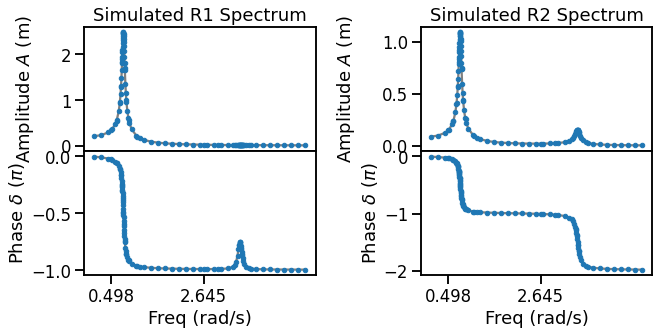

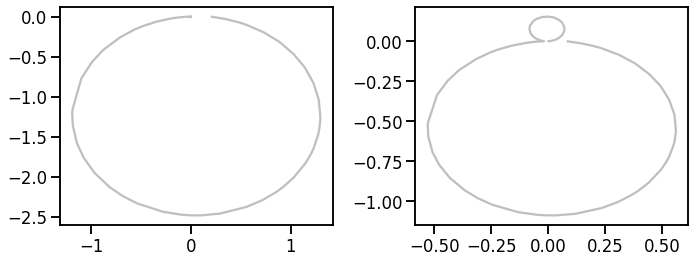

In [10]:
## Image it
labelfreqs = [res1, res2]

if MONOMER:
    fig, ((ax1),(ax2)) = plt.subplots(2,1, figsize = (9.5/2,5), gridspec_kw={'hspace': 0}, sharex = 'all' )
else:
    fig, ((ax1, ax3),(ax2,ax4)) = plt.subplots(2,2, figsize = (9.5,5), gridspec_kw={'hspace': 0}, sharex = 'all' )

ax1.plot(drive, R1_amp_noiseless, '-', color = 'gray', label='set values') # intended curves
ax1.plot(drive, R1_amp, '.', color = 'C0', label='simulated data') # simulated data

ax1.set_ylabel('Amplitude $A$ (m)\n')
ax1.set_title('Simulated R1 Spectrum')

ax2.plot(drive, R1_phase_noiseless/np.pi, '-', color = 'gray', label='set values') # intended curves
ax2.plot(drive, R1_phase/np.pi, '.', color = 'C0')
ax2.set_ylabel('Phase $\delta$ ($\pi$)')
#ax2.set_title('Simulated R1 Phase')

if not MONOMER:
    ax3.plot(drive, R2_amp_noiseless, '-', color = 'gray', label='set values') # intended curves
    ax3.plot(drive, R2_amp, '.', color = 'C0')
    ax3.set_ylabel('Amplitude $A$ (m)\n')
    ax3.set_title('Simulated R2 Spectrum')

    ax4.plot(drive, R2_phase_noiseless/np.pi, '-', color = 'gray', label='set values') # intended curves
    ax4.plot(drive, R2_phase/np.pi, '.', color = 'C0')

    ax4.set_ylabel('Phase $\delta$ ($\pi$)')
    #ax4.set_title('Simulated R2 Phase')

if MONOMER:
    axlist = [ax1,ax2]
else:
    axlist = [ax1, ax2, ax3, ax4]
for ax in axlist:
    if not MONOMER:
        plt.sca(ax)
        plt.xticks(labelfreqs)
#for ax in [ax2, ax4]:  
    ax.set_xlabel('Freq (rad/s)')

plt.tight_layout()    

if MONOMER:
    fig2, ax5 = plt.subplots(1,1, figsize = (10/2,4))
else:
    fig2, ((ax5, ax6)) = plt.subplots(1,2, figsize = (10,4))

# true curves
#drive = np.linspace(minfreq, maxfreq, num = n*10)
ax5.plot(realamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER), 
         imamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER), 
         color='gray', alpha = .5)
if not MONOMER:
    ax6.plot(realamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0), 
             imamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0), 
             color='gray', alpha = .5)



plt.tight_layout()

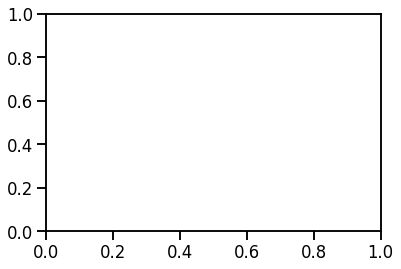

In [11]:
"""
maxamp is the maximum amplitude, probably the amplitude at the resonance peak.
Returns arclength in same units as amplitude.
"""
def arclength_between_pair(maxamp, Z1, Z2):
    radius = maxamp/2 # radius of twirl, approximating it as a circle 
    x1 = Z1.real
    y1 = Z1.imag
    x2 = Z2.real
    y2 = Z2.imag
    
    ## If one is above the origin and the other is below the origin, then this code won't work at all.
    if y1*y2 < 0:
        return np.nan,np.nan,np.nan
    
    ## Convert to prime coordinates with origin at the center of the twirl
    if y1<0:
        # twirl is below the origin.
        y1p = y1 + radius
        y2p = y2 + radius
    else:
        # twirl is above the origin
        y1p = y1 - radius
        y2p = y2 - radius
    Z1p = complex(x1, y1p)
    Z2p = complex(x2, y2p)
    
    ## Calculate prime coords amplitude and phase
    angle1p = np.angle(Z1p)
    angle2p = np.angle(Z2p)
    A1p = A_from_Z(Z1p) # hopefully these two amplitudes A1p and A2p are the same as each other and as radius
    A2p = A_from_Z(Z2p)
    
    r = (A1p + A2p)/2 # update radius estimate to average
    #print('Radius: ' + str(radius) + ', radius2: ' + str(A1p) + ', radius3: ' + str(A2p) )
    theta = (angle2p-angle1p) # if I don't calculate abs() then I get signed arclength
    theta = (theta + np.pi) % (2 * np.pi) - np.pi ## Force angle to be between -pi and pi.
    
    # calculate signed arclength
    s = r*theta
    return s, theta, r

""" Simulator privilege to determine SNR. 
    Only one (first) frequency will be used.
"""
def SNRknown(freq,vals_set=vals_set, noiselevel = noiselevel, use_complexnoise=use_complexnoise, 
             MONOMER=MONOMER, detailed = False):
    A1,_,_= noisyR1ampphase(freq, vals_set=vals_set, noiselevel = 0, MONOMER=MONOMER) # privilege! no noise!
    A2,_,_= noisyR2ampphase(freq, vals_set=vals_set, noiselevel = 0, MONOMER=MONOMER)
    if use_complexnoise:
        STD1 = noiselevel* complexamplitudenoisefactor
        STD2 = STD1
    else:
        STD1 = noiselevel* amplitudenoisefactor1
        STD2 = noiselevel* amplitudenoisefactor2
        
    SNR_R1 = A1 / STD1
    SNR_R2 = A2 / STD2
    
    if detailed:
        # SNR, SNR, signal, noise, signal, noise
        return SNR_R1[0],SNR_R2[0], A1, STD1, A2, STD2
    else:
        return SNR_R1[0],SNR_R2[0]

def SNRs(freqs,vals_set=vals_set, noiselevel = noiselevel, use_complexnoise=use_complexnoise,
         privilege=True, MONOMER=MONOMER, detailed = False):
    SNR_R1_list = []
    SNR_R2_list = []
    A1list = []
    STD1list = []
    A2list= []
    STD2list = []
    
    for freq in freqs:
        if detailed:
            if privilege:
                SNR_R1,SNR_R2, A1, STD1, A2, STD2 = SNRknown(
                    freq,vals_set, noiselevel, use_complexnoise,MONOMER, detailed = detailed)
            else:
                SNR_R1,SNR_R2, A1, STD1, A2, STD2 = SNRcalc(
                    freq,vals_set=vals_set, noiselevel = noiselevel, MONOMER=MONOMER, detailed = detailed)
            A1list.append(A1)
            STD1list.append(STD1)
            A2list.append(A2)
            STD2list.append(STD2)
        else:    
            if privilege:
                SNR_R1,SNR_R2 = SNRknown(freq,vals_set, noiselevel, use_complexnoise,MONOMER, detailed = detailed)
            else:
                SNR_R1,SNR_R2 = SNRcalc(freq,vals_set=vals_set, noiselevel = noiselevel, MONOMER=MONOMER, detailed = detailed)
        SNR_R1_list.append(SNR_R1) # list is in same order as frequencies
        SNR_R2_list.append(SNR_R2)
    
    if detailed:
        return max(SNR_R1_list),max(SNR_R2_list),min(SNR_R1_list),min(SNR_R2_list), \
            np.mean(SNR_R1_list),np.mean(SNR_R2_list), SNR_R1_list, SNR_R2_list, \
            np.mean(A1list), np.mean(STD1list), np.mean(A2list), np.mean(STD2list)
            
    else:
        return max(SNR_R1_list),max(SNR_R2_list),min(SNR_R1_list),min(SNR_R2_list), \
            np.mean(SNR_R1_list),np.mean(SNR_R2_list), SNR_R1_list, SNR_R2_list 

""" Experimentalist style to determine SNR """
def SNRcalc(freq, plot = False, ax = None, vals_set=vals_set, noiselevel = noiselevel, detailed = False, MONOMER=MONOMER):
    n = 50 # number of randomized values to calculate
    amps1 = np.zeros(n)
    zs1 = np.zeros(n ,dtype=complex)
    amps2 = np.zeros(n)
    zs2 = np.zeros(n ,dtype=complex)
    for j in range(n):
        thisamp1, _, thisz1 = noisyR1ampphase(freq, vals_set, noiselevel, MONOMER)
        amps1[j] = thisamp1
        zs1[j] = thisz1[0] # multiple simulated measurements of complex amplitude Z1 (of R1)
        thisamp2, _, thisz2 = noisyR2ampphase(freq, vals_set, noiselevel, MONOMER)
        amps2[j] = thisamp2
        zs2[j] = thisz2[0] # multiple simulated measurements of complex amplitude Z2 (of R2)
    SNR_R1 = np.mean(amps1) / np.std(amps1)
    SNR_R2 = np.mean(amps2) / np.std(amps2)

    if plot:
        if ax is not None:
            plt.sca(ax)
        plt.plot(np.real(zs1), np.imag(zs1), '.', alpha = .2) 
        plt.plot(np.real(zs2), np.imag(zs2), '.', alpha = .2) 
        plt.plot(0,0, 'o')
        plt.gca().axis('equal');
        plt.title('Freq: ' + str(freq) +   
                  ', SNR R1: ' ,SNR_R1, 
                  ', SNR R2: ' ,SNR_R2)
    if detailed:
        # SNR, SNR, signal, noise, signal, noise
        return SNR_R1,SNR_R2, np.mean(amps1), np.std(amps1),  np.mean(amps2), np.std(amps2)
    else:
        return SNR_R1,SNR_R2

#SNRcalc(drive[p[1]], plot = True)

def measurementdfcalc(drive, p, 
                      R1_amp=R1_amp,R2_amp=R2_amp,R1_phase=R1_phase, R2_phase=R2_phase, 
                     R1_amp_noiseless=R1_amp_noiseless,R2_amp_noiseless=R2_amp_noiseless,
                      R1_phase_noiseless=R1_phase_noiseless, R2_phase_noiseless=R2_phase_noiseless,
                      vals_set=vals_set, noiselevel = noiselevel
                     ):
    table = []
    for i in range(len(p)):
        if False:
            print('p: ' + str(p))
            print('freq: ' + str(p[i]))
            print('Measured amplitude: ' + str(R1_amp[p[i]]))
            print('correct amplitude: ' + str(R1_amp_noiseless[p[i]]))
            print('Syserr: ', syserr(R1_amp[p[i]], R1_amp_noiseless[p[i]]), ' %')
        
        SNR_R1, SNR_R2 = SNRknown(drive[p[i]], vals_set=vals_set, noiselevel = noiselevel)
        table.append([drive[p[i]], R1_amp[p[i]], R1_phase[p[i]], R2_amp[p[i]], R2_phase[p[i]], 
                      complexamp(R1_amp[p[i]],R1_phase[p[i]] ),
                      complexamp(R2_amp[p[i]], R2_phase[p[i]]),
                      SNR_R1, SNR_R2,
                     syserr(R1_amp[p[i]], R1_amp_noiseless[p[i]]),
                     (R1_phase[p[i]] - R1_phase_noiseless[p[i]]),
                     syserr(R2_amp[p[i]],R2_amp_noiseless[p[i]]),
                     (R2_phase[p[i]]-R2_phase_noiseless[p[i]]),
                     ])

    df = pd.DataFrame(data = table, 
                      columns = ['drive', 'R1Amp', 'R1Phase', 'R2Amp', 'R2Phase',
                                 'R1AmpCom', 'R2AmpCom',
                                 'SNR_R1','SNR_R2', # less privileged
                                 'R1Amp_syserr%', 'R1Phase_diff', 'R2Amp_syserr%', 'R2Phase_diff']) # more privileged
    return df

def compile_rsqrd(R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,
              drive, K1, K2, K12, B1, B2, FD, M1, M2, MONOMER = MONOMER, forceboth = forceboth, label = '', 
                  oneminus = True, takelog = True): 
        
        theseresults = []
        theseresults_cols = []
        
        # Polar coordinates and cartesian coordinates
        rsqrdl = rsqrdlist(R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,
              drive, K1, K2, K12, B1, B2, FD, M1, M2, MONOMER = MONOMER, forceboth = forceboth)
        expt_A1_rsqrd,expt_phase1_rsqrd,expt_A2_rsqrd,expt_phase2_rsqrd, expt_realZ1_rsqrd,expt_imZ1_rsqrd, expt_realZ2_rsqrd, expt_imZ2_rsqrd = rsqrdl
      
        # polar
        theseresults.append([expt_A1_rsqrd,  expt_phase1_rsqrd])
        theseresults_cols.append(['expt_A1_rsqrd', 'expt_phase1_rsqrd'])
        
        if MONOMER:
            avg_expt_polar_rsqrd = (expt_A1_rsqrd + expt_phase1_rsqrd) / 2
        else: 
            expt_ampavg_rsqrd = (expt_A1_rsqrd + expt_A2_rsqrd)/2
            theseresults.append([expt_A2_rsqrd,  expt_phase2_rsqrd, expt_ampavg_rsqrd])
            theseresults_cols.append(['expt_A2_rsqrd', 'expt_phase2_rsqrd', 'expt_ampavg_rsqrd'])
            avg_expt_polar_rsqrd = (expt_A1_rsqrd + expt_A2_rsqrd + expt_phase1_rsqrd + expt_phase2_rsqrd) / 4
            
        theseresults.append([avg_expt_polar_rsqrd])
        theseresults_cols.append(['avg_expt_polar_rsqrd']) 
        
        # cartesian
        theseresults.append([expt_realZ1_rsqrd,  expt_imZ1_rsqrd])
        theseresults_cols.append(['expt_realZ1_rsqrd', 'expt_imZ1_rsqrd'])
        
        if MONOMER:
            avg_expt_cartes_rsqrd = (expt_realZ1_rsqrd+expt_imZ1_rsqrd)/2
        else:
            theseresults.append([expt_realZ2_rsqrd,  expt_imZ2_rsqrd])
            theseresults_cols.append(['expt_realZ2_rsqrd', 'expt_imZ2_rsqrd'])
            avg_expt_cartes_rsqrd = (expt_realZ1_rsqrd + expt_imZ1_rsqrd + expt_realZ2_rsqrd + expt_imZ2_rsqrd)/4
        theseresults.append(avg_expt_cartes_rsqrd)
        theseresults_cols.append('avg_expt_cartes_rsqrd')
        
        theseresults = flatten(theseresults)
        theseresults_cols = flatten(theseresults_cols)
        
        if oneminus:
            theseresults = [1-rsqrd for rsqrd in theseresults]
            theseresults_cols = ['1-' + name for name in theseresults_cols]
            
        if takelog:
            theseresults = theseresults + [np.log10(element) for element in theseresults]
            theseresults_cols = theseresults_cols + ['log ' + name for name in theseresults_cols]
        
        if label != '':
            theseresults_cols = [name + '_' + label for name in theseresults_cols]
        
        return theseresults, theseresults_cols

""" label_markers are frequencies to label """
def plotcomplex(complexZ, parameter = drive, title = 'Complex Amplitude', cbar_label='Frequency (rad/s)', 
                label_markers=[], ax=plt.gca(), s=50, cmap = 'rainbow'):
    plt.sca(ax)
    sc = ax.scatter(np.real(complexZ), np.imag(complexZ), s=s, c = parameter, cmap = cmap ) # s is marker size
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label(cbar_label)
    ax.set_xlabel('$\mathrm{Re}(Z)$ (m)')
    ax.set_ylabel('$\mathrm{Im}(Z)$ (m)')
    ax.axis('equal');
    plt.title(title)
    plt.gcf().canvas.draw() # draw so I can get xlim and ylim.
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    plt.vlines(0, ymin=ymin, ymax = ymax, colors = 'k', linestyle='solid', alpha = .5)
    plt.hlines(0, xmin=xmin, xmax = xmax, colors = 'k', linestyle='solid', alpha = .5)
    #ax.plot([0,1],[0,0], lw=10,transform=ax.xaxis.get_transform() )#,transform=ax.xaxis.get_transform() ) #transform=ax.transAxes
    
    # label markers that are closest to the desired frequencies
    for label in label_markers:
        if label is None:
            continue
        absolute_val_array = np.abs(parameter - label)
        label_index = absolute_val_array.argmin()
        closest_parameter = parameter[label_index]
        plt.annotate(text=str(round(closest_parameter,2)), 
                     xy=(np.real(complexZ[label_index]), np.imag(complexZ[label_index])) )
        
        ## I'm not sure why def plotcomplex draws an empty graph below.

In [12]:
### Normalizations

""" 1d nullspace normalization """
def normalize_parameters_1d_by_force(unnormalizedparameters, F_set=F_set):
    # parameters vector: 'm1', 'm2', 'b1', 'b2', 'k1', 'k2','c12', 'Driving Force'
    c = F_set / unnormalizedparameters[-1]
    parameters = [c*unnormalizedparameters[k] for k in range(len(unnormalizedparameters)) ]
    return parameters

"""2D normalizations"""

def normalize_parameters_to_res1_and_F_2d(vh, vals_set = vals_set, MONOMER=MONOMER, privilege = False):
    
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
    
    # parameters vector: 'm1', 'm2', 'b1', 'b2', 'k1', 'k2','c12', 'Driving Force'
    vect1 = vh[-1]
    m1_1, m2_1, b1_1, b2_1, k1_1, k2_1, c12_1, F_1 = read_params(vect1, MONOMER=MONOMER)
    vect2 = vh[-2]
    m1_2, m2_2, b1_2, b2_2, k1_2, k2_2, c12_2, F_2 = read_params(vect2, MONOMER=MONOMER)
    
    # Assume we know the resonant frequency of one of the driven, damped oscillators
    # We seem to get much more accurate results knowing the first one, perhaps because that one is being driven
    if privilege:
        res_freq1 = res_freq_weak_coupling(k1_set, m1_set, b1_set) ## This uses privileged information.
    else:
        res_freq1 = res_freq_numeric(numtoreturn = 1,  verboseplot = True, verbose=True)
    #res_freq2 = res_freq_weak_coupling(k2_set, m2_set, b2_set)
    
    # Subscript by 1 and 2 for the two null space vectors
    # Then in res_freq formula, substitute k -> k_1 + Rk_2, m -> m_1 + Rm_2, b -> b_1 + Rb_2
    # Solve for R, the weight of null vector 2 relative to null vector 1 (formula found using Mathematica)
    # The formula is quadratic, so we get two values of R for each oscillator
    # Pick the one that gives the correct (or closer to correct) resonating frequency
    # For simplicity, first solve for A, B, C, the coefficients of the quadratic equation
    
    osc1_A = -b1_2**2 + 2 * k1_2 * m1_2 - 2 * m1_2**2 * res_freq1**2
    osc1_B = -2 * b1_1 * b1_2 + 2 * k1_2 * m1_1 + 2 * k1_1 * m1_2 - 4 * m1_1 * m1_2 * res_freq1**2
    osc1_C = -b1_1**2 + 2 * k1_1 * m1_1 - 2 * m1_1**2 * res_freq1**2
    # If there's a ValueError, just do 1D
    osc1_R1, osc1_R2 = 0, 0
    try:
        osc1_R1, osc1_R2 = quadratic_formula(osc1_A, osc1_B, osc1_C)
    except ValueError:
        pass
    
    # There may be ValueErrors if there exists no resonating frequency for the incorrect R
    # In that case, we make the difference infinity so that R isn't chosen
    osc1_R1_diff = float('inf')
    osc1_R2_diff = float('inf')
    try:
        osc1_R1_diff = abs(res_freq_weak_coupling(k1_1 + osc1_R1 * k1_2, m1_1 + osc1_R1 * m1_2, b1_1 + osc1_R1 * b1_2) - res_freq1)
    except ValueError:
        pass
    try:
        osc1_R2_diff = abs(res_freq_weak_coupling(k1_1 + osc1_R2 * k1_2, m1_1 + osc1_R2 * m1_2, b1_1 + osc1_R2 * b1_2) - res_freq1)
    except ValueError:
        pass
    osc1_R = osc1_R1 if osc1_R1_diff < osc1_R2_diff else osc1_R2
    
    #osc2_A = -b2_2**2 + 2 * k2_2 * m2_2 - 2 * m2_2**2 * res_freq2**2
    #osc2_B = -2 * b2_1 * b2_2 + 2 * k2_2 * m2_1 + 2 * k2_1 * m2_2 - 4 * m2_1 * m2_2 * res_freq2**2
    #osc2_C = -b2_1**2 + 2 * k2_1 * m2_1 - 2 * m2_1**2 * res_freq2**2
    #osc2_R1, osc2_R2 = quadratic_formula(osc2_A, osc2_B, osc2_C)
    
    #osc2_R1_diff = float('inf')
    #osc2_R2_diff = float('inf')
    #try:
    #    osc2_R1_diff = abs(res_freq_weak_coupling(k2_1 + osc2_R1 * k2_2, m2_1 + osc2_R1 * m2_2, b2_1 + osc2_R1 * b2_2) - res_freq2)
    #except ValueError:
    #    pass
    #try:
    #    osc2_R2_diff = abs(res_freq_weak_coupling(k2_1 + osc2_R2 * k2_2, m2_1 + osc2_R2 * m2_2, b2_1 + osc2_R2 * b2_2) - res_freq2)
    #except ValueError:
    #    pass
    #osc2_R = osc2_R1 if osc2_R1_diff < osc2_R2_diff else osc2_R2
    
    # For testing purposes
    #calc_res_freq_1with1 = res_freq_weak_coupling(k1_1 + osc1_R * k1_2, m1_1 + osc1_R * m1_2, b1_1 + osc1_R * b1_2)
    #calc_res_freq_1with2 = res_freq_weak_coupling(k1_1 + osc2_R * k1_2, m1_1 + osc2_R * m1_2, b1_1 + osc2_R * b1_2)
    #calc_res_freq_2with1 = res_freq_weak_coupling(k2_1 + osc1_R * k2_2, m2_1 + osc1_R * m2_2, b2_1 + osc1_R * b2_2)
    #calc_res_freq_2with2 = res_freq_weak_coupling(k2_1 + osc2_R * k2_2, m2_1 + osc2_R * m2_2, b2_1 + osc2_R * b2_2)
    #print("Actual Oscillator 1 Resonant Frequency: " + str(res_freq1))
    #print("Calculated Oscillator 1with1 Resonant Frequency: " + str(calc_res_freq_1with1))
    #print("Calculated Oscillator 1with2 Resonant Frequency: " + str(calc_res_freq_1with2))
    #print("Actual Oscillator 2 Resonant Frequency: " + str(res_freq2))
    #print("Calculated Oscillator 2with1 Resonant Frequency: " + str(calc_res_freq_2with1))
    #print("Calculated Oscillator 2with2 Resonant Frequency: " + str(calc_res_freq_2with2))
    #print("Oscillator 1 Null Vector 1 Resonant Frequency: " + str(res_freq_weak_coupling(k1_1, m1_1, b1_1)))
    #print("Oscillator 1 Null Vector 2 Resonant Frequency: " + str(res_freq_weak_coupling(k1_2, m1_2, b1_2)))
    #print("Oscillator 2 Null Vector 1 Resonant Frequency: " + str(res_freq_weak_coupling(k2_1, m2_1, b2_1)))
    #print("Oscillator 2 Null Vector 2 Resonant Frequency: " + str(res_freq_weak_coupling(k2_2, m2_2, b2_2)))
    
    #print("Weight Ratio from Oscillator 1: " + str(osc1_R))
    #print("Weight Ratio from Oscillator 2: " + str(osc2_R))
    # The R from oscillator 1 seems to work much better, perhaps because it's the one being driven
    R = osc1_R

    # To find the overall weight, we just use the 1D case assuming we know the force
    vect1 = vh[-1]
    vect2 = vh[-2]
    parameters = [vect1[k] + R*vect2[k] for k in range(len(vect1))]
    return normalize_parameters_1d_by_force(parameters, F_set) # does not return the two coefficients


""" mass 1 and mass 2 normalization, 2D nullspace assumption """
# not great for monomer
def normalize_parameters_to_m1_m2_assuming_2d(vh, verbose = False, m1_set = m1_set, m2_set = m2_set):
    if verbose:
        print('Running normalize_parameters_to_m1_m2_assuming_2d()')
    
    # parameters vector: 'm1', 'm2', 'b1', 'b2', 'k1', 'k2','c12', 'Driving Force'
    vect1 = vh[-1]
    vect2 = vh[-2]
    
    if verbose:
        print("If the null-space is 2D, we must be able to independently determine two parameters; say it's m1 and m2.")

    # find linear combination such that:
    # a * vect1[0] + b * vect2[0] = m1_set   and
    # a * vect1[1] + b * vect2[1] = m2_set
    ## But this rearranges to:

    coefa = ( vect2[1] * m1_set - m2_set * vect2[0] ) / (vect2[1]*vect1[0] - vect1[1]*vect2[0] )
    coefb = (vect1[1]*m1_set - m2_set *vect1[0] ) /(vect1[1]*vect2[0] - vect2[1]*vect1[0] )

    parameters = [coefa*vect1[k]+coefb*vect2[k]  for k in range(len(vect1)) ]
    return parameters, coefa, coefb

def normalize_parameters_to_m1_set_k1_set_assuming_2d(vh, verbose = False, m1_set = m1_set, k1_set = k1_set):
    
    if verbose:
        print('Running normalize_parameters_to_m1_set_k1_set_assuming_2d()')
    
    # parameters vector: 'm1', 'm2', 'b1', 'b2', 'k1', 'k2','c12', 'Driving Force'
    vect1 = vh[-1]
    vect2 = vh[-2]
    
    if verbose:
        print("If the null-space is 2D, we must be able to independently determine two parameters; say it's m1 and k1.")

    indexm1 = 0
    if MONOMER:
        indexk1 = 2
    else:
        indexk1 = 4
        
    # find linear combination such that:
    # a * vect1[0] + b * vect2[0] = m1_set   and
    # a * vect1[4] + b * vect2[4] = k1_set
    ## But this rearranges to:

    coefa = ( vect2[indexk1] * m1_set - k1_set * vect2[indexm1] ) / \
        (vect2[indexk1]*vect1[indexm1] - vect1[indexk1]*vect2[indexm1] )
    coefb = ( vect1[indexk1] * m1_set - k1_set * vect1[indexm1] ) / \
        (vect1[indexk1]*vect2[indexm1] - vect2[indexk1]*vect1[indexm1] )
    
    if verbose:
        print(str(coefa) + ' of last singular vector and ' + str(coefb) + ' of second to last singular vector.')

    parameters = [coefa*vect1[k]+coefb*vect2[k]  for k in range(len(vect1)) ]
    return parameters, coefa, coefb

def normalize_parameters_to_m1_F_set_assuming_2d(vh, verbose = False, m1_set = m1_set, F_set = F_set, MONOMER=MONOMER):
    if verbose:
        print('Running normalize_parameters_to_m1_F_set_assuming_2d()')
    
    # parameters vector: 'm1', 'm2', 'b1', 'b2', 'k1', 'k2','c12', 'Driving Force'
    # parameters vector: 'm1', 'b1',  'k1', 'Driving Force'
    vect1 = vh[-1]
    vect2 = vh[-2]
    
    if verbose:
        print("If the null-space is 2D, we must be able to independently determine two parameters; say it's m1 and driving force.")

    indexm1 = 0
    if MONOMER:
        indexF = 3
    else:
        indexF = 7

    # find linear combination such that:
    # a * vect1[0] + b * vect2[0] = m1_set   and
    # a * vect1[7] + b * vect2[7] = F_set
    ## But this rearranges to: 

    coefa = ( vect2[indexF] * m1_set - F_set * vect2[indexm1] ) / \
        (vect2[indexF]*vect1[indexm1] - vect1[indexF]*vect2[indexm1] )
    coefb = ( vect1[indexF] * m1_set - F_set * vect1[indexm1] ) / \
        (vect1[indexF]*vect2[indexm1] - vect2[indexF]*vect1[indexm1] )
    
    if verbose:
        print(str(coefa) + ' of last singular vector and ' + str(coefb) + ' of second to last singular vector.')

    parameters = [coefa*vect1[k]+coefb*vect2[k]  for k in range(len(vect1)) ]
    return parameters, coefa, coefb


""" Force, mass 1 and mass 2 normalization, 3D nullspace assumption
    Numerics corresponding to m1, m2, F in the parameters vector:
    known1 = 0
    known2 = 1
    known3 = 7"""
def normalize_parameters_assuming_3d(vh, vals_set = vals_set, known1 = 0, known2 = 1, known3 = 7, verbose = False, MONOMER=MONOMER):
   
    if verbose:
        print('Running normalize_parameters_assuming_3d()')
        
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
    
    # parameters vector: 'm1', 'm2', 'b1', 'b2', 'k1', 'k2','c12', 'Driving Force'
    # MONOMER parameters vector:  'm1',  'b1',  'k1',  'Driving Force'
    vect1 = vh[-1]
    #[m1_1, m2_1, b1_1, b2_1, k1_1, k2_1, c12_1, F_1] = vect1
    vect2 = vh[-2]
    #[m1_2, m2_2, b1_2, b2_2, k1_2, k2_2, c12_2, F_2] = vect2
    vect3 = vh[-3]
    
    if len(vect1) <= 0:
        print('Warning: vh[-1] is ' + str(vh[-1]))
    if len(vect1) <= known3:
        print('Warning: vect1 has length ' + str(len(vect1)) + ' so we cannot access element ' + str(known3))
    
    if verbose:
        print("If the null-space is 3D, we must be able to independently determine two parameters; say it's m1, m2, and F.")

    
    # find linear combination such that:
    # a * vect1[0] + b * vect2[0] + c * vect3[0] = m1_set   and
    # a * vect1[1] + b * vect2[1] + c * vect3[1] = m2_set   and
    # a * vect1[7] + b * vect2[7] + c * vect3[7] = F_set
    ## But this rearranges to:
    
    denom = (vect3[known1] * vect2[known2] * vect1[known3]  - 
             vect2[known1] * vect3[known2] * vect1[known3]  - 
             vect3[known1] * vect1[known2] * vect2[known3]  + 
             vect1[known1] * vect3[known2] * vect2[known3]  + 
             vect2[known1] * vect1[known2] * vect3[known3]  - 
             vect1[known1] * vect2[known2] * vect3[known3])

    coefa = -(-vals_set[known3] * vect3[known1] * vect2[known2]  + 
              vals_set[known3] * vect2[known1] * vect3[known2]  - 
              vals_set[known1] * vect3[known2] * vect2[known3]  + 
              vect3[known1] * vals_set[known2] * vect2[known3]  + 
              vals_set[known1] * vect2[known2] * vect3[known3]  - 
              vect2[known1] * vals_set[known2] * vect3[known3])/ denom
    coefb = -(vals_set[known3] * vect3[known1] * vect1[known2]  - 
              vals_set[known3] * vect1[known1] * vect3[known2]  + 
              vals_set[known1] * vect3[known2] * vect1[known3]  - 
              vect3[known1] * vals_set[known2] * vect1[known3]  - 
              vals_set[known1] * vect1[known2] * vect3[known3]  + 
              vect1[known1] * vals_set[known2] * vect3[known3])/ denom
    coefc = -(-vals_set[known3] * vect2[known1] * vect1[known2]  + 
              vals_set[known3] * vect1[known1] * vect2[known2]  - 
              vals_set[known1] * vect2[known2] * vect1[known3]  + 
              vect2[known1] * vals_set[known2] * vect1[known3]  + 
              vals_set[known1] * vect1[known2] * vect2[known3]  - 
              vect1[known1] * vals_set[known2] * vect2[known3])/ denom

    parameters = [coefa*vect1[k]+coefb*vect2[k]+coefc*vect3[k]  for k in range(len(vect1)) ]
    
    if verbose:
        print('Parameters 3D: ')
        print(parameters)
    return parameters, coefa, coefb, coefc

Maximum amplitude for R1 is  2.4866288712344757 at 0.773918479619905
Maximum amplitude for R2 is  1.090501112648308 at 0.773918479619905
Repeating with finer frequency mesh around frequencies: [0.77391848 3.50145036 3.53330833]
Maximum amplitude for R1 is  2.4866345238260057 at 0.7738565954619968
Maximum amplitude for R2 is  1.090503639139369 at 0.7739803637778131
Repeating with finer frequency mesh around frequencies: [0.7738566  0.77398036 3.50126471 3.53285038]
Maximum amplitude for R1 is  2.4866345683536477 at 0.7738503445369556
Maximum amplitude for R2 is  1.0905036635612209 at 0.7739871147768577
checking if veryclose 0.7738503445369556 3.5328456336102185
Very close:  False
checking if veryclose 0.7739871147768577 0.7738503445369556
Very close:  True
Removing frequency  0.7738503445369556 and leaving frequency 0.7739871147768577
checking if veryclose 0.7749457566411805 0.7739871147768577
Very close:  True
Removing frequency  0.7749457566411805 and leaving frequency 0.7739871147768

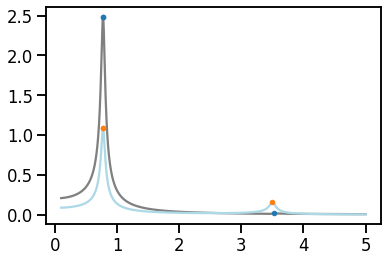

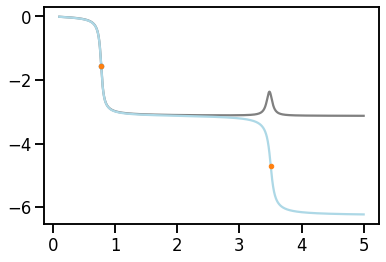

In [13]:
#Choose points for SVD

## reset resonances
reslist = res_freq_numeric(verboseplot = True, verbose=True, iterations = 3)

# add those resonance frequencies to the list of driving frequencies and recalculate the spectra.
drive = np.sort(np.append(drive, reslist))

if MONOMER:
    res1 = res_freq_weak_coupling(k1_set, m1_set, b1_set) ## This uses privileged information.
    freq2 = find_freq_from_angle(morefrequencies, 
                      phase = theta1(morefrequencies, k1_set, k2_set, k12_set, 
                                     b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER),
                      angleswanted = [-np.pi/4])
    desiredfreqs = [res1, freq2[0]]
else:
    ## measure the top two resonant frequencies
    desiredfreqs = res_freq_numeric(numtoreturn = 2)
    res1 = desiredfreqs[0]
    res2 = desiredfreqs[1]

drive = np.sort(np.unique(np.append(drive, desiredfreqs)))
print('desired freqs:', desiredfreqs)
p = freqpoints(desiredfreqs, drive)

#p = [1,8,17]

#p = [14,15,16,29,30,31] #indices of frequencies to use
#p=[14,16]
#p = range(len(drive))
print('Index of freqs:', p)



In [14]:
def simulated_experiment(measurementfreqs, drive=np.linspace(minfreq,maxfreq,n), 
                         vals_set = vals_set, noiselevel=noiselevel, MONOMER=MONOMER, 
                         verbose = True, repeats=1, forceboth=forceboth, 
                         noiseless_spectra = None, noisy_spectra = None, freqnoise = False):
    
    if verbose:
        print('Running simulated_experiment()', repeats, 'times.')
    
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
    
    if drive is None:
        drive = measurementfreqs # fastest way to do it, but R^2 isn't very accurate
    else:
        if noiseless_spectra is None and noisy_spectra is None: # a disadvantage of passing these: can't improve drive.
            drive = np.sort(np.unique(np.append(drive, measurementfreqs)))
        
    p = freqpoints(desiredfreqs = measurementfreqs, drive = drive)
    
    if noiseless_spectra is None: # calculate noiseless spectra
        noiseless_spectra = calculate_spectra(drive, vals_set, noiselevel = 0, MONOMER = MONOMER, forceboth = forceboth)
    R1_amp_noiseless, R1_phase_noiseless, R2_amp_noiseless, R2_phase_noiseless, \
        R1_real_amp_noiseless, R1_im_amp_noiseless, R2_real_amp_noiseless, R2_im_amp_noiseless, _ = noiseless_spectra

    maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2,meanSNR_R1,meanSNR_R2, SNR_R1_list, SNR_R2_list = SNRs( \
            drive[p],vals_set, noiselevel, use_complexnoise)
    
    first = True
    results = []

    for i in range(repeats):
        theseresults = []
        theseresults_cols = []
        
        theseresults.append(len(p))
        theseresults_cols.append([ 'num frequency points'])
        
        theseresults.append(vals_set) # Store vals_set # same for every row
        if MONOMER:
            theseresults_cols.append(['m1_set',  'b1_set',  'k1_set', 'F_set'])
        else:
            theseresults_cols.append(['m1_set', 'm2_set', 'b1_set', 'b2_set', 'k1_set', 'k2_set', 'k12_set', 'F_set'])
        theseresults.append(noiselevel)
        theseresults_cols.append('noiselevel')
        
        if freqnoise:
            #measurementfreqs = [w+random for w in reslist] # *** describe random
            drive = np.unique(np.sort(np.append(drive, measurementfreqs)))

        if noisy_spectra is None or i > 0 or freqnoise:
            # recalculate noisy spectra
            noisy_spectra = calculate_spectra(drive, vals_set, noiselevel=noiselevel, forceboth=forceboth)
        R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,_ = noisy_spectra
        
        if len(p) < 40:
            for i in range(len(p)):
                theseresults.append([drive[p[i]], 
                                     R1_phase_noiseless[p[i]], R2_phase_noiseless[p[i]],
                                    R1_amp_noiseless[p[i]], R2_amp_noiseless[p[i]]])
                theseresults_cols.append(['Freq' + str(i+1), 
                                          'R1_phase_noiseless' + str(i+1),'R2_phase_noiseless' + str(i+1),
                                          'R1_amp_noiseless' + str(i+1),'R2_amp_noiseless' + str(i+1)])                   
                theseresults.append(SNR_R1_list[i])
                theseresults_cols.append('SNR_R1_f' + str(i+1))
                theseresults.append(SNR_R2_list[i])
                theseresults_cols.append('SNR_R2_f' + str(i+1))
                theseresults.append(R1_amp[p[i]])
                theseresults_cols.append('R1_amp_meas' + str(i+1))
                theseresults.append(R2_amp[p[i]])
                theseresults_cols.append('R2_amp_meas' + str(i+1))                
        
        if len(p) == 2:
            theseresults.append(drive[p[1]] - drive[p[0]])
            theseresults_cols.append('Difference')
            theseresults.append(R1_phase_noiseless[p[1]] - R1_phase_noiseless[p[0]])
            theseresults_cols.append('R1_phase_diff')
            theseresults.append(R2_phase_noiseless[p[1]] - R2_phase_noiseless[p[0]])
            theseresults_cols.append('R2_phase_diff')
            
        theseresults.append(drive[p])
        theseresults_cols.append('frequencies')

        df = measurementdfcalc(drive, p, 
                     R1_amp=R1_amp,R2_amp=R2_amp,R1_phase=R1_phase, R2_phase=R2_phase, 
                     R1_amp_noiseless=R1_amp_noiseless,R2_amp_noiseless=R2_amp_noiseless,
                     R1_phase_noiseless=R1_phase_noiseless, R2_phase_noiseless=R2_phase_noiseless
                     )
        Zmatrix = Zmat(df, frequencycolumn = 'drive', complexamplitude1 = 'R1AmpCom', complexamplitude2 = 'R2AmpCom', 
                       MONOMER=MONOMER, forceboth=forceboth)
        u, s, vh = np.linalg.svd(Zmatrix, full_matrices = True)
        vh = make_real_iff_real(vh)
            
        theseresults.append(df['R1Amp_syserr%'].mean())
        theseresults_cols.append('R1Ampsyserr%mean(priv)')
        theseresults.append(df.R1Phase_diff.mean())
        theseresults_cols.append('R1phasediffmean(priv)')
        if not MONOMER:
            theseresults.append(df['R2Amp_syserr%'].mean())
            theseresults_cols.append('R2Ampsyserr%mean(priv)')
            theseresults.append(df.R2Phase_diff.mean())
            theseresults_cols.append('R2phasediffmean(priv)')
        
        theseresults.append([s[-1], s[-2]])
        theseresults_cols.append(['smallest singular value', 'second smallest singular value'])
        
        ## 1D NULLSPACE
        M1, M2, B1, B2, K1, K2, K12, FD = read_params(vh[-1], MONOMER) # the 7th singular value is the smallest one (closest to zero)

        # normalize parameters vector to the force, assuming 1D nullspace
        allparameters = normalize_parameters_1d_by_force([M1, M2, B1, B2, K1, K2, K12, FD], F_set)
        # recast as real, not complex # but real gets a warning
        allparameters = [thisparameter.real for thisparameter in allparameters if thisparameter.imag == 0 ]
        M1, M2, B1, B2, K1, K2, K12, FD = allparameters
        
        if MONOMER:
            theseresults.append([M1, B1,  K1, FD])
            theseresults_cols.append(['M1_1D', 'B1_1D','K1_1D', 'FD_1D'])            
        else:
            theseresults.append([M1, M2, B1, B2, K1, K2, K12, FD])
            theseresults_cols.append(['M1_1D', 'M2_1D', 'B1_1D', 'B2_1D', 'K1_1D', 'K2_1D', 'K12_1D', 'FD_1D'])
        if verbose and first:
            print("1D:")
            plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase, df,  K1, K2, K12, B1, B2, FD, M1, M2, vals_set, 
                             MONOMER=MONOMER, forceboth=forceboth) # %%%
            plt.show()

        el = store_params(M1, M2, B1, B2, K1, K2, K12, FD, MONOMER)

        ## experimentalist's r^2 value
        # I want to find out whether R^2 is a predictor of syserr (controlling for SNR?)
        # R^2 based on experimentally accessible information.
        rsqrdresults1D, rsqrdcolumns1D = compile_rsqrd(R1_amp, R1_phase, R2_amp, R2_phase, 
              R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,
              drive, K1, K2, K12, B1, B2, FD, M1, M2, MONOMER = MONOMER, forceboth = forceboth, label="1D")
        
        # calculate how close the SVD-determined parameters are compared to the originally set parameters
        syserrs = [syserr(el[i], vals_set[i]) for i in range(len(el))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD
        K1syserr = syserr(K1,k1_set)
        B1syserr = syserr(B1,b1_set)
        FDsyserr = syserr(FD,F_set)
        M1syserr = syserr(M1,m1_set)
        if MONOMER:
            K2syserr = 0
            K12syserr = 0
            B2syserr = 0
            M2syserr = 0
        else:
            K2syserr = syserr(K2,k2_set)
            K12syserr = syserr(K12,k12_set)
            B2syserr = syserr(B2,b2_set)
            M2syserr = syserr(M2,m2_set)
        avgsyserr, rmssyserr, maxsyserr, Lavgsyserr = combinedsyserr(syserrs,1) # subtract 1 degrees of freedom for 1D nullspace

        if MONOMER:
            theseresults.append([K1syserr,  B1syserr,  FDsyserr, M1syserr])
            theseresults_cols.append(['K1syserr%_1D', 'B1syserr%_1D','FDsyserr%_1D', 'M1syserr%_1D'])
        else:
            theseresults.append([K1syserr,K2syserr, K12syserr, B1syserr, B2syserr, FDsyserr, M1syserr, M2syserr])
            theseresults_cols.append(['K1syserr%_1D','K2syserr%_1D', 'K12syserr%_1D', 'B1syserr%_1D', 'B2syserr%_1D', 'FDsyserr%_1D', 'M1syserr%_1D', 'M2syserr%_1D'])
        theseresults.append([avgsyserr, rmssyserr, maxsyserr, Lavgsyserr])
        theseresults_cols.append(['avgsyserr%_1D', 'rmssyserr%_1D', 'maxsyserr%_1D', 'Lavgsyserr%_1D'])
        theseresults.append([np.log10(avgsyserr), np.log10(rmssyserr), np.log10(maxsyserr), np.log10(Lavgsyserr)])
        theseresults_cols.append(['log avgsyserr%_1D', 'log rmssyserr%_1D', 'log maxsyserr%_1D', 'log Lavgsyserr%_1D'])

        ### Normalize parameters in 2D nullspace 
        """ # Problem: res1 formula only for weak coupling.
        [M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D] = \
            normalize_parameters_to_res1_and_F_2d(vh, vals_set = vals_set)
        coefa = np.nan
        coefb = np.nan"""
        #[M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D], coefa, coefb = \
        #    normalize_parameters_to_m1_set_k1_set_assuming_2d(vh)
        #[M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D], coefa, coefb = \
        #    normalize_parameters_to_m1_m2_assuming_2d(vh, verbose = False, m1_set = m1_set, m2_set = m2_set)
        el_2D, coefa, coefb = \
            normalize_parameters_to_m1_F_set_assuming_2d(vh, verbose = False, m1_set = m1_set, F_set = F_set)
        normalizationpair = 'm1 and F'
        
        if MONOMER:
            theseresults.append(el_2D)
            theseresults_cols.append(['M1_2D','B1_2D', 'K1_2D', 'FD_2D'])
        else:
            theseresults.append(el_2D)
            theseresults_cols.append(['M1_2D', 'M2_2D', 'B1_2D', 'B2_2D', 'K1_2D', 'K2_2D', 'K12_2D', 'FD_2D'])
        M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D = read_params(el_2D, MONOMER=MONOMER)
            
        if verbose and first:
            print("2D:")
            plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase, df, 
                             K1_2D, K2_2D, K12_2D, B1_2D, B2_2D, FD_2D, M1_2D, M2_2D, vals_set,
                             MONOMER=MONOMER, forceboth=forceboth)
            plt.show()
            
        # I want to find out whether R^2 is a predictor of syserr (controlling for SNR?)
        # R^2 based on experimentally accessible information.
        rsqrdresults2D, rsqrdcolumns2D = compile_rsqrd(R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,
              drive, K1_2D, K2_2D, K12_2D, B1_2D, B2_2D, FD_2D, M1_2D, M2_2D, MONOMER = MONOMER, forceboth = forceboth, label="2D")
        
        syserrs_2D = [syserr(el_2D[i], vals_set[i]) for i in range(len(el_2D))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD

        K1syserr_2D = syserr(K1_2D,k1_set)
        B1syserr_2D = syserr(B1_2D,b1_set)
        FDsyserr_2D = syserr(FD_2D,F_set)
        M1syserr_2D = syserr(M1_2D,m1_set)

        if MONOMER:
            K2syserr_2D = 0
            K12syserr_2D = 0
            B2syserr_2D = 0
            M2syserr_2D = 0
        else:
            K2syserr_2D = syserr(K2_2D,k2_set)
            K12syserr_2D = syserr(K12_2D,k12_set)
            B2syserr_2D = syserr(B2_2D,b2_set)
            M2syserr_2D = syserr(M2_2D,m2_set)
        if MONOMER:
            theseresults.append([K1syserr_2D,B1syserr_2D,FDsyserr_2D,M1syserr_2D])
            theseresults_cols.append(['K1syserr%_2D','B1syserr%_2D','FDsyserr%_2D','M1syserr%_2D'])           
        else:
            theseresults.append([K1syserr_2D,B1syserr_2D,FDsyserr_2D,M1syserr_2D,
                                 K2syserr_2D,K12syserr_2D,B2syserr_2D,M2syserr_2D])
            theseresults_cols.append(['K1syserr%_2D','B1syserr%_2D','FDsyserr%_2D','M1syserr%_2D',
                                      'K2syserr%_2D','K12syserr%_2D','B2syserr%_2D','M2syserr%_2D'])

        avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D = combinedsyserr(syserrs_2D,2) # subtract 2 degrees of freedom for 2D nullspace
        theseresults.append([avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D])
        theseresults_cols.append(['avgsyserr%_2D', 'rmssyserr%_2D', 'maxsyserr%_2D',  'Lavgsyserr%_2D'])
        theseresults.append([np.log10(avgsyserr_2D), np.log10(rmssyserr_2D), np.log10(maxsyserr_2D), np.log10(Lavgsyserr_2D)])
        theseresults_cols.append(['log avgsyserr%_2D', 'log rmssyserr%_2D', 'log maxsyserr%_2D', 'log Lavgsyserr%_2D'])
        
        theseresults.append(avgsyserr-avgsyserr_2D)
        theseresults_cols.append('avgsyserr%_1D-avgsyserr%_2D')
        theseresults.append(np.log10(avgsyserr)-np.log10(avgsyserr_2D))
        theseresults_cols.append('log avgsyserr%_1D - log avgsyserr%_2D')
        
        ## 3D normalization.
        if MONOMER:
            el_3D, coefa, coefb, coefc = normalize_parameters_assuming_3d(vh, vals_set, 0,1,2, MONOMER=MONOMER)
        else:
            el_3D, coefa, coefb, coefc = normalize_parameters_assuming_3d(vh, MONOMER=MONOMER)
        el_3D = [parameter.real for parameter in el_3D if parameter.imag == 0 ]
        
        if MONOMER:
            theseresults.append(el_3D)
            theseresults_cols.append(['M1_3D','B1_3D', 'K1_3D', 'FD_3D'])
        else:
            theseresults.append(el_3D)
            theseresults_cols.append(['M1_3D', 'M2_3D', 'B1_3D', 'B2_3D', 'K1_3D', 'K2_3D', 'K12_3D', 'FD_3D'])
        M1_3D, M2_3D, B1_3D, B2_3D, K1_3D, K2_3D, K12_3D, FD_3D = read_params(el_3D, MONOMER=MONOMER)
                            
        if verbose and first:
            print("3D:")
            plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase, df, 
                             K1_3D, K2_3D, K12_3D, B1_3D, B2_3D, FD_3D, M1_3D, M2_3D, vals_set,
                             MONOMER=MONOMER, forceboth=forceboth)
            plt.show()
            first = False
            
        # I want to find out whether R^2 is a predictor of syserr (controlling for SNR?)
        # R^2 based on experimentally accessible information.
        rsqrdresults3D, rsqrdcolumns3D = compile_rsqrd(R1_amp, R1_phase, R2_amp, R2_phase, 
              R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,
              drive, K1_3D, K2_3D, K12_3D, B1_3D, B2_3D, FD_3D, M1_3D, M2_3D, 
              MONOMER = MONOMER, forceboth = forceboth, label="3D")
                        
        syserrs_3D = [syserr(el_3D[i], vals_set[i]) for i in range(len(el_3D))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD

        K1syserr_3D = syserr(K1_3D,k1_set)
        B1syserr_3D = syserr(B1_3D,b1_set)
        FDsyserr_3D = syserr(FD_3D,F_set)
        M1syserr_3D = syserr(M1_3D,m1_set)

        if MONOMER:
            K2syserr_3D = 0
            K12syserr_3D = 0
            B2syserr_3D = 0
            M2syserr_3D = 0
        else:
            K2syserr_3D = syserr(K2_3D,k2_set)
            K12syserr_3D = syserr(K12_3D,k12_set)
            B2syserr_3D = syserr(B2_3D,b2_set)
            M2syserr_3D = syserr(M2_3D,m2_set)
        if MONOMER:
            theseresults.append([K1syserr_3D,B1syserr_3D,FDsyserr_3D,M1syserr_3D])
            theseresults_cols.append(['K1syserr%_3D','B1syserr%_3D','FDsyserr%_3D','M1syserr%_3D'])           
        else:
            theseresults.append([K1syserr_3D,B1syserr_3D,FDsyserr_3D,M1syserr_3D,
                                 K2syserr_3D,K12syserr_3D,B2syserr_3D,M2syserr_3D])
            theseresults_cols.append(['K1syserr%_3D','B1syserr%_3D','FDsyserr%_3D','M1syserr%_3D',
                                      'K2syserr%_3D','K12syserr%_3D','B2syserr%_3D','M2syserr%_3D'])

        avgsyserr_3D, rmssyserr_3D, maxsyserr_3D, Lavgsyserr_3D = combinedsyserr(syserrs_3D,3) # subtract 3 degrees of freedom for 3D nullspace
        theseresults.append([avgsyserr_3D, rmssyserr_3D, maxsyserr_3D, Lavgsyserr_3D])
        theseresults_cols.append(['avgsyserr%_3D', 'rmssyserr%_3D', 'maxsyserr%_3D', 'Lavgsyserr%_3D'])
        theseresults.append([np.log10(avgsyserr_3D), np.log10(rmssyserr_3D), np.log10(maxsyserr_3D), np.log10(Lavgsyserr_3D)])
        theseresults_cols.append(['log avgsyserr%_3D', 'log rmssyserr%_3D', 'log maxsyserr%_3D', 'log Lavgsyserr%_3D'])
        
        theseresults.append(avgsyserr-avgsyserr_3D)
        theseresults_cols.append('avgsyserr%_1D-avgsyserr%_3D')
        theseresults.append(np.log10(avgsyserr)-np.log10(avgsyserr_3D))
        theseresults_cols.append('log avgsyserr%_1D - log avgsyserr%_3D')
                            
        theseresults.append(avgsyserr_2D-avgsyserr_3D)
        theseresults_cols.append('avgsyserr%_2D-avgsyserr%_3D')
        theseresults.append(np.log10(avgsyserr_2D)-np.log10(avgsyserr_3D))
        theseresults_cols.append('log avgsyserr%_2D - log avgsyserr%_3D')
        
        theseresults.append(len(drive))
        theseresults_cols.append('num_freq_used_for_rsqrd')
        theseresults.append(rsqrdresults1D)
        theseresults_cols.append(rsqrdcolumns1D)
        theseresults.append(rsqrdresults2D)
        theseresults_cols.append(rsqrdcolumns2D)
        theseresults.append(rsqrdresults3D)
        theseresults_cols.append(rsqrdcolumns3D)
        

        
        if MONOMER: # same for every row
            theseresults.append([maxSNR_R1, minSNR_R1,meanSNR_R1])
            theseresults_cols.append(['maxSNR_R1', 'minSNR_R1','meanSNR_R1'])
            theseresults.append(list(np.log10([maxSNR_R1, minSNR_R1,meanSNR_R1])))
            theseresults_cols.append(
                ['log ' + s for s in ['maxSNR_R1', 'minSNR_R1','meanSNR_R1']])
        else:
            theseresults.append([maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2, meanSNR_R1,meanSNR_R2])
            theseresults_cols.append(['maxSNR_R1','maxSNR_R2',  'minSNR_R1','minSNR_R2','meanSNR_R1','meanSNR_R2'])
            
            theseresults.append(list(np.log10([maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2, meanSNR_R1,meanSNR_R2])))
            theseresults_cols.append(
                ['log ' + s for s in ['maxSNR_R1','maxSNR_R2',  'minSNR_R1','minSNR_R2','meanSNR_R1','meanSNR_R2']])
            
        #theseresults.append([len(p), drive[p]]) # same for every row
        #theseresults_cols.append([ 'num frequency points','frequencies'])

        results.append(flatten(theseresults))

    assert (len(flatten(theseresults)) == len(flatten(theseresults_cols)))
    resultsdf = pd.DataFrame(
            data=results, 
            columns = flatten(theseresults_cols))
    return resultsdf

In [15]:
stophere # finish initialization. Next: try 1D, 2D, and 3D SVD

NameError: name 'stophere' is not defined

In [ ]:
print(len(drive))

In [ ]:
# calculate noisy and noiseless measurements


R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,_ = calculate_spectra(
            drive, vals_set, noiselevel=noiselevel)
R1_amp_noiseless, R1_phase_noiseless, R2_amp_noiseless, R2_phase_noiseless, \
    R1_real_amp_noiseless, R1_im_amp_noiseless, R2_real_amp_noiseless, R2_im_amp_noiseless, _ = calculate_spectra( \
            drive, vals_set, noiselevel = 0)

df = measurementdfcalc(drive, p,
                      R1_amp=R1_amp,R2_amp=R2_amp,R1_phase=R1_phase, R2_phase=R2_phase, 
                     R1_amp_noiseless=R1_amp_noiseless,R2_amp_noiseless=R2_amp_noiseless,
                      R1_phase_noiseless=R1_phase_noiseless, R2_phase_noiseless=R2_phase_noiseless,
                      vals_set=vals_set, noiselevel = noiselevel)
display(df)

#Plots of simulated spectra

Q1 = approx_Q(k = k1_set, m = m1_set, b=b1_set)
W1 = approx_width(k = k1_set, m = m1_set, b=b1_set)

print('Simulated spectra data, as if from experiment')
print('Approximate Q1: ' + "{:.2f}".format(Q1) + ' width: ' + "{:.2f}".format(W1))
if MONOMER:
    print('Resonant frequency expected at ' 
          + str(res1))
    label_markers = drive[p]
else:
    Q2 = approx_Q(k = k2_set, m = m2_set, b=b2_set)
    W2 = approx_width(k = k2_set, m = m2_set, b=b2_set)
    print('Approximate Q2: ' + "{:.2f}".format(Q2) +
      ' width: ' + "{:.2f}".format(W2))
    print('Resonant frequencies expected at approximately ' 
          + str(res1) + ' and ' 
          + str(res2))
    label_markers = [res1, res2]

morefrequencies = np.sort(np.unique(np.append(morefrequencies, np.linspace(res1-W1, res1+W1, num = n))))
if not MONOMER:
    morefrequencies = np.sort(np.unique(np.append(morefrequencies, np.linspace(res2-W2, res2+W2, num = n))))
    
fig, ((ax1, ax3),(ax2,ax4),(ax5, ax6)) = plt.subplots(3,2, figsize = (10,10))

ax1.plot(morefrequencies, curve1(morefrequencies, 
                                 k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, 
                                 MONOMER=MONOMER, forceboth=forceboth), # true curve
         color = 'gray', alpha = 0.2)
ax1.plot(drive, R1_amp, '.', color = 'C0') # noisy simulated data
ax1.set_ylabel('Amplitude $A$ (m)\n')
ax1.set_title('Simulated R1 Amp')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax1.plot(df.drive[i], df.R1Amp[i], 'ko', fillstyle='none', markeredgewidth = 3, alpha = .8)
        
ax2.plot(morefrequencies, theta1(morefrequencies, 
                                 k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set,  0, 
                                 MONOMER=MONOMER, forceboth=forceboth)/np.pi, # true curve
         color = 'gray', alpha = 0.2)        
ax2.plot(drive, R1_phase/np.pi, '.', color = 'C0') # noisy simulated data
ax2.set_ylabel('Phase $\delta$ ($\pi$)')
ax2.set_title('Simulated R1 Phase')

#For loop to plot chosen values from table
for i in range(df.shape[0]):
    ax2.plot(df.drive[i], df.R1Phase[i]/np.pi, 'ko', fillstyle='none', markeredgewidth = 3, alpha = .8)
        
ax3.plot(morefrequencies, curve2(morefrequencies, 
                                 k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, 
                                 MONOMER=MONOMER, forceboth=forceboth), # true curve
         color = 'gray', alpha = 0.2)    
ax3.plot(drive, R2_amp, '.', color = 'C0')
ax3.set_ylabel('Amplitude $A_2$ (m)\n')
ax3.set_title('Simulated R2 Amp')

#For loop to plot chosen values from table
for i in range(df.shape[0]):
    ax3.plot(df.drive[i], df.R2Amp[i], 'ko', fillstyle='none', markeredgewidth = 3, alpha = .8)
    
ax4.plot(morefrequencies, theta2(morefrequencies, 
                                 k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set,  0, 
                                 MONOMER=MONOMER, forceboth=forceboth)/np.pi, # true curve
         color = 'gray', alpha = 0.2)
ax4.plot(drive, R2_phase/np.pi, '.', color = 'C0')
ax4.set_ylabel('Phase $\delta_2$ ($\pi$)')
ax4.set_title('Simulated R2 Phase')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax4.plot(df.drive[i], df.R2Phase[i]/np.pi, 'ko', fillstyle='none', markeredgewidth = 3, alpha = .8)
        
for ax in [ax1,ax2,ax3,ax4]:
    plt.sca(ax)
    plt.xticks([res1, res2])
    ax.set_xlabel('Freq (rad/s)')

    
plt.tight_layout()



#Calculate complex amplitudes of spectra

Z1 = complexamp(R1_amp, R1_phase)
Z2 = complexamp(R2_amp, R2_phase)

#fig, (ax5, ax6) = plt.subplots(1, 2, figsize = (10,5))

# true curves
ax5.plot(realamp1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER), 
         imamp1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER), 
         color='gray', alpha = .5)
ax6.plot(realamp2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0), 
         imamp2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0), 
         color='gray', alpha = .5)

plotcomplex(Z1, drive, 'Complex Amplitude $Z_1$', ax=ax5, label_markers=label_markers)
ax5.scatter(np.real(df.R1AmpCom), np.imag(df.R1AmpCom), s=150, facecolors='none', edgecolors='k') 
plotcomplex(Z2, drive, 'Complex Amplitude $Z_2$', ax=ax6, label_markers=label_markers)
ax6.scatter(np.real(df.R2AmpCom), np.imag(df.R2AmpCom), s=150, facecolors='none', edgecolors='k') 
      
plt.tight_layout()

print('maxamp at:        ', res_freq_numeric(mode = 'maxamp'))
print('resonant phase at:',res_freq_numeric(mode = 'phase'))

In [ ]:
df

In [ ]:
df.describe()

In [ ]:
#Singular Value Decomposition

verbose = True

if MONOMER:
    parameternames = ['m1',  'b1',  'k1',  'Driving Force']
else:
    parameternames = ['m1', 'm2', 'b1', 'b2', 'k1', 'k2','c12', 'Driving Force']

Zmatrix = Zmat(df, frequencycolumn = 'drive', complexamplitude1 = 'R1AmpCom', complexamplitude2 = 'R2AmpCom', MONOMER=MONOMER)

if verbose:
    print("Z matrix:") 
    display(pd.DataFrame(np.array(Zmatrix, dtype = np.double), columns = parameternames))

#SVD
u, s, vh = np.linalg.svd(Zmatrix, full_matrices = True)
#u, s, vh = sc.linalg.svd(Zmatrix, full_matrices = False, lapack_driver = 'gesvd')
#vh = make_real_iff_real(vh)

# the smallest singular value is always the last one, index -1
print('Singular values:')
print(s)

plt.semilogy(s, '.')
plt.axhline(10**-2, color='gray')
plt.title('singular values');

In [ ]:
vh

In [ ]:
# singular vectors. # M1, M2, B1, B2, K1, K2, K12, FD
display(vh)
vh = make_real_iff_real(vh)
display(vh)

In [ ]:
print('What does res_freq_weak_coupling look like for each singular vector?')
for vect in vh:
    ##unnormalized values
    M1, M2, B1, B2, K1, K2, K12, FD = read_params(vect, MONOMER)
    
    w = res_freq_weak_coupling(K1, M1, B1)
    if np.isnan(w):
        w = res_freq_weak_coupling(-K1, -M1, -B1)
    if not np.isnan(w):
        print(w)

print('Privilege weak-coupling resonant frequency: ' + str(res_freq_weak_coupling(k1_set, m1_set, b1_set)) )
print('Experimental view of resonant frequency:', res_freq_numeric(
    vals_set=vals_set, MONOMER=MONOMER, mode = 'amp', iterations = 1,
    unique = True, veryunique = True, numtoreturn = 1, verboseplot = False, verbose=verbose)[0])

In [ ]:
print("Checking the python-normalization")

vect =vh[-1]
sq = [el**2 for el in vect]
sum(sq)

In [ ]:
M1, M2, B1, B2, K1, K2, K12, FD = read_params(vh[-1], MONOMER)

measweakres1 = res_freq_weak_coupling(K1, M1, B1)
privweakres1 = res_freq_weak_coupling(k1_set, m1_set, b1_set)
maxampfreq = res_freq_numeric(numtoreturn = 1)[0]
print('1D solution resonance frequency (weak coupling)')
print(measweakres1)
print('Weak-coupling resonance frequency as set (privilege)')
print(privweakres1)
print('Syserr:')
print(str(syserr(measweakres1,privweakres1)) + '%')

print('Max amplitude (no noise mini-privilege):')
print(maxampfreq)
print('Syserr (no noise mini-privilege):')
print(str(syserr(measweakres1,maxampfreq)) + '%')


if not MONOMER:
    measweakres2 = res_freq_weak_coupling(K2, M2, B2)
    privweakres2 = res_freq_weak_coupling(k2_set, m2_set, b2_set)
    print('\n1D solution resonance frequency (weak coupling)')
    print(measweakres2)
    print('\nWeak-coupling resonance frequency as set (privilege)')
    print(privweakres2)
    print('Syserr:')
    print(str(syserr(measweakres2,privweakres2)) + '%')

vals = [['Norm m1', 'Norm m2', 'Norm b1', 'Norm b2', 'Norm k1', 'Norm k2','Norm c12', 'Norm Driving Force']]
vals.append((M1, M2, B1, B2, K1, K2, K12, FD))

#print("Python-Normalized singular vector corresponding to parameters vector")
#print(tabulate(vals, headers = 'firstrow', tablefmt = 'fancy_grid'))

In [ ]:
#View vh array and assign variables to proper row vector

print('Results of analysis versus set values:')
print("The python normalization loses one degree of freedom, \
so we must be able to independently determine one parameter; say it's the driving force")

M1, M2, B1, B2, K1, K2, K12, FD = normalize_parameters_1d_by_force([M1, M2, B1, B2, K1, K2, K12, FD], F_set)
parameters = store_params(M1, M2, B1, B2, K1, K2, K12, FD, MONOMER)
parameters = [parameter.real for parameter in parameters if parameter.imag == 0 ]
syserrs = [syserr(parameters[i], vals_set[i]) for i in range(len(parameters))]
avg1d, rms1d, max1d, Lavg1d = combinedsyserr(syserrs, 1)

if MONOMER:
    parameterlist = [['m1','b1', 'k1', 'Driving Force']]
    #M1, B1, K1,  FD = parameters
else:
    parameterlist = [['m1', 'm2', 'b1', 'b2', 'k1', 'k2','c12', 'Driving Force']]
    #M1, M2, B1, B2, K1, K2, K12, FD = parameters
vals2 = parameterlist.copy() # initialize parametersdf
vals2.append(parameters)
vals2.append(vals_set)
vals2.append(syserrs)

#print(tabulate(vals2, headers = 'firstrow', tablefmt = 'fancy_grid'))
parametersdf = pd.DataFrame(vals2, index = ['labels', 'from_svd', 'set', "syserr (%)"])
parametersdf.columns = parametersdf.iloc[0] 
print("How good are the 1D nullspace results?")
display(parametersdf)
parametersdf1d = parametersdf.copy()

#Calculate Rsqrd compared to 1D nullspace to test the 1D nullspace model

plotting = False
amp1_rsqrd = rsqrd(model=curve1(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER, forceboth=forceboth), 
                   data=R1_amp, plot=plotting, x=drive)
print('amp1_rsqrd', amp1_rsqrd)
phase1_rsqrd = rsqrd(data=R1_phase, model=theta1(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER, forceboth=forceboth), 
                     plot=plotting, x=drive)
print('phase1_rsqrd', phase1_rsqrd)
if not MONOMER:
    amp2_rsqrd = rsqrd(data=R2_amp, model=curve2(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, forceboth=forceboth), 
                       plot=plotting, x=drive)
    print('amp2_rsqrd',amp2_rsqrd)
    phase2_rsqrd = rsqrd(data = R2_phase, model= theta2(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, forceboth=forceboth), 
                         plot=plotting, x=drive)
    print('phase2_rsqrd',phase2_rsqrd)

## Calculate systematic err to test the 1D nullspace results

print('Noise level: ' + str(noiselevel))
try:
    print('R1 amp SNR: ' , df.SNR_R1.min(),  ' to ', df.SNR_R1.max())
    if not MONOMER:
        print('R2 amp SNR: ' , df.SNR_R2.min(),  ' to ', df.SNR_R2.max())
    print('Average systematic err: ',avg1d, '%')
    print('RMS systematic err: ',rms1d, '%')
    print('Max systematic err: ',max1d, '%')
except TypeError:
    print("There was a TypeError.")



labelbarchart = False

fig,ax = plt.subplots()
if labelbarchart:
    bargraph = ax.bar(parametersdf.columns,parametersdf.transpose()['syserr (%)'])
    plt.gca().bar_label(bargraph)
else:
    (parametersdf.transpose()['syserr (%)']).plot(kind='bar')
plt.gca().set_ylabel('systematic err (%)\n')
plt.gca().set_xlabel('');
plt.title('1D nullspace')
plt.show()

print("Number of frequencies: ", len(p))
print("1D:")
print("R1 Amp Rsqrd = ", amp1_rsqrd,  '= 1 - ', 1-amp1_rsqrd,
     "\nR1 Phase Rsqrd = ", phase1_rsqrd,'= 1 - ', 1-phase1_rsqrd)
if not MONOMER:
      print("R2 Amp Rsqrd = ", amp2_rsqrd,'= 1 - ', 1-amp2_rsqrd,
          "\nR2 Phase Rsqrd = ", phase2_rsqrd,'= 1 - ', 1-phase2_rsqrd)

plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase,df,  K1, K2, K12, B1, B2, FD, M1, M2, 
                 vals_set = vals_set, MONOMER=MONOMER, forceboth=forceboth, labelfreqs=drive[p]) 

In [ ]:
print('Avg syserr 1D: ', avg1d, '%')

In [ ]:
len(drive)

In [ ]:
## what if the null-space is 2D?

#View vh array and assign variables to proper row vector

print('Results of analysis versus set values:')

print("If the null-space is 2D, we must be able to independently determine two parameters; say we know resonating frequencies and force")

parameters, coefa, coefb = normalize_parameters_to_m1_F_set_assuming_2d(vh)
print('2d coefficients are:')
print(coefa, coefb)
print('2d parameters are:')
print(parameters)
parameters = [parameter.real for parameter in parameters if parameter.imag == 0 ]
syserrs = [syserr(parameters[i], vals_set[i]) for i in range(len(parameters))]
avg2d, rms2d, max2d, Lavg2d = combinedsyserr(syserrs, 2)

vals3 = parameterlist.copy() # initialize to [['m1', 'm2', 'b1', 'b2', 'k1', 'k2','c12', 'Driving Force']] or shorter if monomer
vals3.append(parameters)
vals3.append(vals_set)
vals3.append(syserrs)

parametersdf3 = pd.DataFrame(vals3, index = ['labels', 'from_svd', 'set', 'syserr (%)'])
new_header3 = parametersdf3.iloc[0] 
parametersdf3.columns = new_header3
print('1D nullspace results:')
display(parametersdf1d)
print("How good are the 2D nullspace results?")
display(parametersdf3)

#Calculate Rsqrd compared to 2D nullspace to test the 2D nullspace model

plotting = False

amp1_rsqrd2D = rsqrd(model=curve1(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER=MONOMER, forceboth=forceboth), 
                     data=R1_amp, plot=plotting, x=drive)
phase1_rsqrd2D = rsqrd(data=R1_phase, 
                       model=theta1(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER=MONOMER, forceboth=forceboth), 
                       plot=plotting, x=drive)
if not MONOMER:
    amp2_rsqrd2D = rsqrd(data=R2_amp, model=curve2(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, forceboth=forceboth), 
                         plot=plotting, x=drive)
    phase2_rsqrd2D = rsqrd(data = R2_phase, model= theta2(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, forceboth=forceboth), 
                           plot=plotting, x=drive)

try:
    print('Noise level: ' + str(noiselevel))
    print('R1 amp SNR: ', df.SNR_R1.min() , ' to ', df.SNR_R1.max())
    if not MONOMER:
        print('R2 amp SNR: ' , df.SNR_R2.min(),' to ' ,df.SNR_R2.max())
    print('Average systematic err: ',avg2d, '%,'
          'whereas for 1D it was: ', avg1d, '%')
    print('RMS systematic err:   ', rms2d, '%',
          ' whereas for 1D it was: ', rms1d, '%')
    print('Max systematic err:   ',max2d, '%', 
          ' whereas for 1D it was: ',max1d, '%')
except TypeError:
    print('There was a TypeError.')

fig,ax = plt.subplots()
if labelbarchart:
    bargraph = ax.bar(parametersdf3.columns,parametersdf3.transpose()['syserr (%)'])
    plt.gca().bar_label(bargraph)
else:
    (parametersdf3.transpose()['syserr (%)']).plot(kind='bar')
plt.gca().set_ylabel('systematic err (%)\n')
plt.gca().set_xlabel('');
plt.title("2D nullspace")
plt.show()

print("Number of frequencies: ", len(p))
print('2D: ')
print("R1 Amp Rsqrd = ", amp1_rsqrd2D, '= 1 - ', 1-amp1_rsqrd2D,
     "\nR1 Phase Rsqrd = ", phase1_rsqrd2D, '= 1 - ', 1-phase1_rsqrd2D
     )

if not MONOMER:
      print("R2 Amp Rsqrd = ", amp2_rsqrd2D,'= 1 - ', 1-amp2_rsqrd2D,
          "\nR2 Phase Rsqrd = ", phase2_rsqrd2D,'= 1 - ', 1-phase2_rsqrd2D)

In [ ]:
print("2D nullspace")
plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase,df,  K1, K2, K12, B1, B2, FD, M1, M2, 
                 vals_set = vals_set, MONOMER=MONOMER, forceboth=forceboth)

In [ ]:
## What if it's 3D nullspace? No, it's not.

if MONOMER:
    el_3D, coefa, coefb, coefc = normalize_parameters_assuming_3d(vh, vals_set, 0,1,2, MONOMER=MONOMER)
else:
    el_3D, coefa, coefb, coefc = normalize_parameters_assuming_3d(vh, MONOMER=MONOMER)
M1, M2, B1, B2, K1, K2, K12, FD = read_params(el_3D, MONOMER)
parameters = [parameter.real for parameter in parameters if parameter.imag == 0 ]
syserrs = [syserr(el_3D[i], vals_set[i]) for i in range(len(el_3D))]
avg3d, rms3d, max3d, Lavg3d = combinedsyserr(syserrs, 3)

vals3d = parameterlist.copy() # initialize to [['m1', 'm2', 'b1', 'b2', 'k1', 'k2','c12', 'Driving Force']]
vals3d.append(el_3D)
vals3d.append(vals_set)
vals3d.append(syserrs)

parametersdf3d = pd.DataFrame(vals3d, index = ['labels', 'from_svd', 'set', 'syserr (%)'])
new_header3d = parametersdf3d.iloc[0] 
parametersdf3d.columns = new_header3d
print('1D nullspace results:')
display(parametersdf1d)
print("2D nullspace results:")
display(parametersdf3)
print("3D nullspace results:")
display(parametersdf3d)

#Calculate Rsqrd compared to 3D nullspace to test the 3D nullspace model

plotting = False

amp1_rsqrd3D = rsqrd(model=curve1(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER=MONOMER, forceboth=forceboth), 
                     data=R1_amp, plot=plotting, x=drive)
print('amp1_rsqrd3D',amp1_rsqrd3D)
phase1_rsqrd3D = rsqrd(data=R1_phase, model=theta1(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER=MONOMER, forceboth=forceboth),
                       plot=plotting, x=drive)
print('phase1_rsqrd3D',phase1_rsqrd3D)
if not MONOMER:
    amp2_rsqrd3D = rsqrd(data=R2_amp, model=curve2(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER=MONOMER, forceboth=forceboth),
                         plot=plotting, x=drive)
    print('amp2_rsqrd3D',amp2_rsqrd3D)
    phase2_rsqrd3D = rsqrd(data = R2_phase, model= theta2(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER=MONOMER, forceboth=forceboth), 
                           plot=plotting, x=drive)
    print('phase2_rsqrd3D',phase2_rsqrd3D)

print('Noise level: ' + str(noiselevel))
try:
    print('R1 amp SNR: ' , df.SNR_R1.min(),  ' to ', df.SNR_R1.max())
    if not MONOMER:
        print('R2 amp SNR: ' , df.SNR_R2.min(),  ' to ' , df.SNR_R2.max())
    print('Average 3D systematic err: ', avg3d, '%',
          'whereas for 1D it was: ', avg1d, '%')
    print('RMS 3D systematic err:   ', rms3d, '%',
          ' whereas for 1D it was: ', rms1d, '%')
    print('Max 3D systematic err:   ', max3d, '%',
          ' whereas for 1D it was: ', max1d, '%')
except TypeError:
    print('There was a TypeError')

fig,ax = plt.subplots()
if labelbarchart:
    bargraph = ax.bar(parametersdf3.columns,parametersdf3d.transpose()['syserr (%)'])
    plt.gca().bar_label(bargraph)
else:
    (parametersdf3d.transpose()['syserr (%)']).plot(kind='bar')
plt.gca().set_ylabel('systematic err (%)\n')
plt.gca().set_xlabel('');
plt.title("3D nullspace")
plt.show()

print("Number of frequencies: ", len(p))
print("R1 Amp Rsqrd = ", amp1_rsqrd3D,
     "\nR1 Phase Rsqrd = ", phase1_rsqrd3D)
if not MONOMER:
      print("R2 Amp Rsqrd = ", amp2_rsqrd3D,
          "\nR2 Phase Rsqrd = ", phase2_rsqrd3D)
        
print("3D nullspace")
plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase,df,  K1, K2, K12, B1, B2, FD, M1, M2, 
                 MONOMER=MONOMER, forceboth=forceboth)

In [ ]:
stophere # next: do 1D, 2D, 3D with Repeats. simulated_experiment()

In [ ]:
plt.plot(drive) # Want this to be nonlinear to emphasize special frequencies

In [ ]:
try:
    del repeatedexptsres
except NameError:
    pass

In [ ]:
measurementfreqs = desiredfreqs
    
# Ran 1000 times in 20.438 sec
repeats = 1000
verbose = False
before = time()
if True: # repeats are incorporated in the function instead of at this level, but we can run this cell again.
    thisres = simulated_experiment(measurementfreqs, drive=drive,vals_set = vals_set, noiselevel=noiselevel, MONOMER=MONOMER, 
                                  repeats=repeats , verbose = False)
    try: # repeated experiments results
        repeatedexptsres = repeatedexptsres.append(thisres, ignore_index=True)
    except:
        repeatedexptsres = thisres
after = time()
printtime(repeats, before, after)   
display(repeatedexptsres.transpose()) 

repeatedexptsresmean = repeatedexptsres.mean()

In [ ]:
list(repeatedexptsres.columns)

In [ ]:
print('noiselevel:', noiselevel)
print('meanSNR_R1:', repeatedexptsres.meanSNR_R1[0])
if not MONOMER:
    print('meanSNR_R2:', repeatedexptsres.meanSNR_R2[0])


fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (5,9))#, gridspec_kw={'hspace': 0}, sharex = 'all')

if MONOMER:
    Xkey = '1-expt_A1_rsqrd_'
else:
    Xkey = '1-expt_ampavg_rsqrd_'
    
symb = '.'

plt.sca(ax1)
plt.loglog(repeatedexptsres[Xkey + '1D'], repeatedexptsres['avgsyserr%_1D'], symb, alpha = .08, label='1D')
#plt.title('1D');
plt.xlabel('$1-R^2$')
plt.ylabel('syserr (%)');
plt.legend()
    
plt.sca(ax2)
plt.loglog(repeatedexptsres[Xkey + '2D'], repeatedexptsres['avgsyserr%_2D'], symb, alpha = .08, label='2D')
#plt.title(' 2D');
plt.xlabel('$1-R^2$')
plt.ylabel('syserr (%)');
plt.legend()

plt.sca(ax3)
plt.loglog(repeatedexptsres[Xkey + '3D'], repeatedexptsres['avgsyserr%_3D'], symb, alpha = .08, label='3D')
#plt.title('3D');
plt.xlabel('$1-R^2$')
plt.ylabel('syserr (%)');

plt.suptitle('$R^2$ is useful for predicting syserr\nbut not dimension')
plt.legend()

fig.tight_layout() #***

display(len(repeatedexptsres.columns)) # 171 -> 136 distributions
if MONOMER:
    numconst = 15
else:
    numconst = 35

In [ ]:
plotnum = len(repeatedexptsres.columns) - numconst
if MONOMER:
    plotnum = 85

plotgrid = ((int(math.ceil(plotnum)/5)),5)
if MONOMER:
    figsize = (20,45)
else:
    figsize = (20,60)
figsizefull = figsize

fig, axs = plt.subplots(plotgrid[0], plotgrid[1], figsize = figsize)

keylist = [] # list of keys for things that vary
count = 0 # count number of plots
countconst = 0
for key in repeatedexptsres.columns:
    try:
        if repeatedexptsres[key][0].size > 1:
            print(key, ': ', repeatedexptsres[key][0])
            countconst = countconst + 1
            continue            
        if abs(repeatedexptsres[key].std()) < .000000001 or 'SNR' in key: 
            if 'rsqrd' in key:
                if 'num_freq_used_for_rsqrd' in key:
                    print(key, ': ', repeatedexptsresmean[key])
                    countconst = countconst + 1
                    continue
                # else do plot it
            elif 'B1' in key:
                pass
            else:    
                print(key, ': ', repeatedexptsresmean[key])
                countconst = countconst + 1
                continue
    except:
        print("Error from key:" , key)
        countconst = countconst + 1
        continue
    try:
        if len(repeatedexptsres)>400:
            bins = 25
        else:
            bins = 10
        plt.sca(axs.flat[count])
        stats.probplot(repeatedexptsres[key], dist='norm', plot = plt )
        plt.xlabel('')
        plt.ylabel('')
        distribution = "normal"
        #plt.hist(repeatedexptsres[key], bins=bins);
        plt.title(key + '\n')
        #plt.show()
        count = count+1
        keylist.append(key)
    except TypeError:
        print('Cannot make hist for ', key)
print('Showing ', count, ' plots to judge if these are', distribution, 'curves')
print('If our data comes from a', distribution, 'distribution, we should see all the points sitting on the straight line.')
# https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411
fig.tight_layout()



In [ ]:
""" a Half normal distribution and a log normal distribution are kind of close. """

if MONOMER:
    numplots = 26
    figsize = (15,12)
else:
    numplots = 38
    figsize=(15,18)

fig, axs = plt.subplots(int(math.ceil(numplots/5)), 5, figsize = figsize)

count = 0 # count number of plots
for key in keylist:
    try:
        if 'syserr' not in key or ('log ' in key and '-' not in key):
            continue
        if len(repeatedexptsres)>400:
            bins = 25
        else:
            bins = 10
        plt.sca(axs.flat[count])
        stats.probplot(repeatedexptsres[key], dist='halfnorm', plot = plt )
        distribution = 'halfnormal'
        #plt.hist(repeatedexptsres[key], bins=bins);
        plt.xlabel('')
        plt.ylabel('')
        plt.title(key)
        #plt.show()
        count = count+1
    except TypeError:
        print('Cannot make hist for ', key)
print('Showing ', count, ' plots to judge if these are', distribution, 'curves')
print('If our data comes from a', distribution, 'distribution, we should see all the points sitting on the straight line.')
# https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411
fig.tight_layout()



In [ ]:
"""syserrlist = [key for key in keylist if 'syserr' in key]

syserrresults = repeatedexptsres[syserrlist] #***

sns.violinplot(x=syserrlist,y=syserrresults ,
    fontsize=7, rot=90)
    """;

In [ ]:
fig, axs = plt.subplots(plotgrid[0], plotgrid[1], figsize = figsizefull)

count = 0 # count number of plots
for key in keylist:
    try:
        plt.sca(axs.flat[count])
        sns.histplot(repeatedexptsres[key],kde=True, stat="density", linewidth=0)
        #plt.hist(repeatedexptsres[key], bins=10);
        plt.xlabel('\n' + key)
        plt.ylabel('')
        #plt.show()
        count = count+1
    except TypeError or ValueError:
        print('Cannot make hist for ', key)
print('Showing ', count, ' plots')
print('Some of these are the folded normal (half normal) distribution')
fig.tight_layout()

In [ ]:
plt.figure(figsize=(50,50))
sns.heatmap(repeatedexptsres[keylist].corr(), cmap='PiYG' );

In [ ]:
len(drive)

In [ ]:
if MONOMER:
    numlines = 8
    figsize = (25,27)
else:
    numlines = 12
    figsize = (20,35)
    
fig, axs = plt.subplots(numlines,5, figsize = figsize)

count = 0
for key in keylist:
    if 'syserr%_1D' in key and 'log' not in key and '-' not in key:
        plt.sca(axs.flat[count])
        count = count + 1
        plt.plot(repeatedexptsres[Xkey + '1D'], repeatedexptsres[key], symb, alpha = .08, label=key)
        #plt.title('1D'); 
        plt.xlabel('amplitude $1-R^2$')
        plt.ylabel(key);
        plt.gca().set_xscale('log')
        #plt.gca().set_yscale('log')        
        
        plt.sca(axs.flat[count])
        count = count + 1
        plt.plot(repeatedexptsres['1-avg_expt_cartes_rsqrd_1D'], repeatedexptsres[key], symb, alpha = .08, label=key)
        #plt.title('1D'); 
        plt.xlabel('cartes $1-R^2$')
        plt.ylabel(key);
        plt.gca().set_xscale('log')
        #plt.gca().set_yscale('log')
        #plt.legend()
        
    if 'syserr%_2D' in key and 'log' not in key and '-' not in key:
        plt.sca(axs.flat[count])
        count = count + 1
        plt.plot(repeatedexptsres[Xkey + '2D'], repeatedexptsres[key], symb, alpha = .08, label=key)
        plt.xlabel('amplitude $1-R^2$')
        plt.ylabel(key);
        plt.gca().set_xscale('log')
        #plt.gca().set_yscale('log')        
        #plt.legend()
        
        plt.sca(axs.flat[count])
        count = count + 1
        plt.plot(repeatedexptsres[Xkey + '2D'], repeatedexptsres[key], symb, alpha = .08, label=key)
        plt.xlabel('cartes $1-R^2$')
        plt.ylabel(key);
        plt.gca().set_xscale('log')
        #plt.gca().set_yscale('log')
        #plt.legend()
        
    if 'syserr%_3D' in key and 'log' not in key and '-' not in key:
        plt.sca(axs.flat[count])
        count = count + 1
        plt.plot(repeatedexptsres[Xkey + '3D'], repeatedexptsres[key], symb, alpha = .08, label=key)
        plt.xlabel('amplitude $1-R^2$')
        plt.ylabel(key);
        plt.gca().set_xscale('log')
        #plt.gca().set_yscale('log')        
        #plt.legend()
        
        plt.sca(axs.flat[count])
        count = count + 1
        plt.plot(repeatedexptsres['1-avg_expt_cartes_rsqrd_3D'], repeatedexptsres[key], symb, alpha = .08, label=key)
        plt.xlabel('cartes $1-R^2$')
        plt.ylabel(key);
        plt.gca().set_xscale('log')
        #plt.gca().set_yscale('log')
        #plt.legend()
        
fig.tight_layout()

In [ ]:
plt.loglog(repeatedexptsres['1-expt_A1_rsqrd_1D'], repeatedexptsres['M1syserr%_1D'], symb, alpha = .1, label='$A_1$')
if not MONOMER:
    plt.loglog(repeatedexptsres['1-expt_A2_rsqrd_1D'], repeatedexptsres['M1syserr%_1D'], symb, alpha = .1, label='$A_2$')
plt.legend();
plt.xlabel('$1-R^2$')
plt.ylabel('M1syserr%_1D');

In [ ]:
if not MONOMER:
    repeatedexptsres[['1-expt_A1_rsqrd_1D','1-expt_A2_rsqrd_1D','M1syserr%_1D' ]].corr()

In [ ]:
stophere # next: vary_num_p_with_fixed_freqdiff() gradually increases number of measurement points

In [ ]:
try:
    del resultsvarynump
except NameError:
    pass

In [ ]:
""" Vary the number of measurement frequencies """

# create list of all measured frequencies, centered around res (the resonance frequency), and spaced out by freqdiff
def allmeasfreq_one_res(res, max_num_p, freqdiff):
    newfreqplus = res
    newfreqminus = res
    freqlist = [res]
    while len(freqlist) < max_num_p:
        newfreqplus = newfreqplus + freqdiff
        newfreqminus = newfreqminus - freqdiff
        freqlist.append(newfreqplus)
        freqlist.append(newfreqminus)
    return freqlist

# create list of all measured frequencies, centered around res1 and res2, respectively, and spaced out by freqdiff
def allmeasfreq_two_res(res1, res2, max_num_p, freqdiff):
    newfreq1plus = res1
    newfreq1minus = res1
    newfreq2plus = res2
    newfreq2minus = res2
    freqlist = [res1, res2]
    while len(freqlist) < max_num_p:
        newfreq1plus = newfreq1plus + freqdiff
        newfreq1minus = newfreq1minus - freqdiff
        newfreq2plus = newfreq2plus + freqdiff
        newfreq2minus = newfreq2minus - freqdiff
        freqlist.append(newfreq1plus)  ## this order might matter
        freqlist.append(newfreq2plus)
        freqlist.append(newfreq1minus)
        freqlist.append(newfreq2minus)
    return freqlist

def vary_num_p_with_fixed_freqdiff(max_num_p = 10, vals_set = vals_set, noiselevel=noiselevel,
                                   freqdiff = .1,MONOMER=MONOMER, just_res1 = False, repeats = 100,
                                   verbose = False,recalculate_randomness=True ):
    if verbose:
        print('Running vary_num_p_with_fixed_freqdiff()')
    
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)

    ## To be fair for each, I use 3 iterations to really nail down the highest amplitudes.
    reslist = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, mode = 'amp', iterations = 3,
             unique = True, veryunique = True, numtoreturn = 2, verboseplot = False, verbose=verbose)
    ## measure the top two resonant frequencies
    res1 = reslist[0]
    if not MONOMER:
        res2 = reslist[1]
    
    if just_res1 or MONOMER:
        freqlist = allmeasfreq_one_res(res1, max_num_p, freqdiff)
    else:
        freqlist = allmeasfreq_two_res(res1,res2, max_num_p, freqdiff)
    
    assert len(freqlist) == max_num_p
    
    #define driving frequency range (gives array of n evenly spaced numbers between 0.1 and 5) and also whatever we want to measure
    drive = np.sort(np.append(np.linspace(minfreq, maxfreq, num = n), freqlist ))
    
    R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,_ = calculate_spectra(
            drive, vals_set, noiselevel=noiselevel, MONOMER=MONOMER, forceboth=forceboth)
    
    noiseless_spectra = calculate_spectra(drive, vals_set, noiselevel = 0, MONOMER = MONOMER, forceboth = forceboth)

    for y in range(repeats):
        if y > 0:
            verbose = False
        
        if not recalculate_randomness: # at least need to calculate it every repeat
                noisy_spectra = calculate_spectra(drive, vals_set, noiselevel=noiselevel)
            
        for this_num_p in range(2, max_num_p+1):

            ## Do we recalculate the spectra every time or use the same datapoints as before? (This is slower.)
            if recalculate_randomness:
                noisy_spectra = None # calculate it in the helper function

            ## the list of desired frequencies will grow by one element for each loop
            desiredfreqs = freqlist[:this_num_p]

            if verbose:
                print('num freq: ' + str(this_num_p))
                print('desired freqs: ' + str(desiredfreqs))

            p = freqpoints(desiredfreqs = desiredfreqs, drive = drive)

            thisres = simulated_experiment(drive[p], drive=drive,vals_set = vals_set, noiselevel=noiselevel, MONOMER=MONOMER, 
                                           repeats=1 , verbose = verbose, 
                                           noiseless_spectra=noiseless_spectra, noisy_spectra = noisy_spectra)
            
            try: # repeated experiments results
                resultsdf = pd.concat([resultsdf,thisres], ignore_index=True)
            except:
                resultsdf = thisres


    return resultsdf

W1 = approx_width(k = k1_set, m = m1_set, b=b1_set)
if MONOMER:
    W = W1
else:
    W2 = approx_width(k = k2_set, m = m2_set, b=b2_set)
    W = W2

# Ran 100 times in 7.121 sec
# Ran 100 times in 78.661 sec with verbose = True (only counts the first repeat).
repeats = 100
verbose = True
freqdiff = round(W/6,4)
print('freqdiff:', freqdiff)
before = time()
for i in range(1): # don't do repeats at this level.
    thisres = vary_num_p_with_fixed_freqdiff(vals_set = vals_set, verbose = verbose, just_res1 = False, 
                                             freqdiff = freqdiff, #max_num_p=100,
                                             noiselevel= 1, repeats = repeats,
                                             recalculate_randomness = False)
    verbose = False
    try:
        resultsvarynump = resultsvarynump.append(thisres, ignore_index=True)
    except:
        resultsvarynump = thisres
after = time()
printtime(repeats, before, after)   
display(resultsvarynump.transpose())

resultsvarynumpmean = resultsvarynump.groupby(by=['num frequency points'],as_index=False).mean()

In [ ]:
print('Noiselevel: ' + str(noiselevel))

symb = '.'  # plotting style

plt.figure()
plt.plot(resultsvarynump['num frequency points'],resultsvarynump['avgsyserr%_3D'], symb, alpha = .1, color = 'C2' )
plt.plot(resultsvarynump['num frequency points'],resultsvarynump['avgsyserr%_2D'], symb, alpha = .1, color = 'C1')
plt.plot(resultsvarynump['num frequency points'],resultsvarynump['avgsyserr%_1D'], symb, alpha = .1, color = 'C0')
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['avgsyserr%_3D'],  label='3D', color = 'C2')
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['avgsyserr%_2D'],  label='2D', color = 'C1')
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['avgsyserr%_1D'], label='1D', color = 'C0')
plt.legend()
plt.gca().set_yscale('log')
plt.xlabel('num frequency points')
plt.ylabel('avg syserr (%)')

plt.figure()
plt.plot(resultsvarynump['num frequency points'],resultsvarynump['K1syserr%_3D'], symb, alpha = .3 ,  color = 'C2')
plt.plot(resultsvarynump['num frequency points'],resultsvarynump['K1syserr%_2D'], symb, alpha = .3 ,  color = 'C1')
plt.plot(resultsvarynump['num frequency points'],resultsvarynump['K1syserr%_1D'], symb, alpha = .3,  color = 'C0')
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['K1syserr%_3D'],  label='3D', color = 'C2')
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['K1syserr%_2D'],  label='2D', color = 'C1')
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['K1syserr%_1D'],  label='1D', color = 'C0')
plt.legend()
plt.gca().set_yscale('log')
plt.xlabel('num frequency points')
plt.ylabel('k1 syserr (%)')

plt.figure()
#plt.plot(resultsvarynump['R1Ampsyserr%mean(priv)'],resultsvarynump['K1syserr%_2D'], symb, alpha = .3 , label='2D')
plt.plot(resultsvarynump['R1Ampsyserr%mean(priv)'],resultsvarynump['K1syserr%_1D'] , symb, alpha = .3, label='1D')
plt.legend()
plt.gca().set_yscale('log')
plt.xlabel('R1 Amp syserr mean (priv) (%)')
plt.ylabel('k1 syserr (%)')

plt.figure()
#plt.plot(resultsvarynump['R1phasediffmean(priv)'],resultsvarynump['K1syserr%_2D'], symb, alpha = .3 , label='2D')
plt.plot(resultsvarynump['R1phasediffmean(priv)'],resultsvarynump['K1syserr%_1D'], symb, alpha = .3, label='1D')
plt.legend()
plt.gca().set_yscale('log')
plt.xlabel('R1 phase diff mean (privileged)')
plt.ylabel('k1 syserr (%)')

plt.figure()
plt.plot(resultsvarynump['meanSNR_R1'],resultsvarynump['avgsyserr%_1D'], symb, alpha = .5, label = '1D' )
plt.plot(resultsvarynump['meanSNR_R1'],resultsvarynump['avgsyserr%_2D'], symb, alpha = .5 , label = '2D')
plt.plot(resultsvarynumpmean['meanSNR_R1'],resultsvarynumpmean['avgsyserr%_1D'],  label = '1D' )
plt.plot(resultsvarynumpmean['meanSNR_R1'],resultsvarynumpmean['avgsyserr%_2D'], label = '2D')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel('meanSNR_R1')
plt.ylabel('avg syserr (%)')

plt.figure()
plt.plot(resultsvarynump['minSNR_R1'],resultsvarynump['avgsyserr%_1D'], symb, alpha = .5 )
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel('minSNR_R1')
plt.ylabel('avg syserr (%)');

In [ ]:
datestr = datetime.today().strftime('%Y-%m-%d %H;%M;%S')
resultsvarynump.to_csv(os.path.join(savefolder,
                    datestr + "resultsvarynump_monomer.csv"));
resultsvarynump.to_pickle(os.path.join(savefolder,
                       datestr + 'resultsvarynump.pkl'))
print('Saved: ' + os.path.join(savefolder,
                       datestr + 'resultsvarynump.csv'))

In [ ]:
stophere # Next: varynoiselevel()

In [ ]:
try:
    del resultsvarynoiselevel
except NameError:
    pass

In [ ]:
## vary noiselevel

"""  vary  the noiselevel """
def varynoiselevel(noises, vals_set = vals_set, verbose = False, MONOMER=MONOMER):
    if verbose:
        print('Running varynoiselevel()')
    
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
    
    res1,res2 = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, mode = 'amp', iterations = 3,
                 unique = True, veryunique = True, numtoreturn = 2, verboseplot = False, verbose=verbose)
    
    freqdiff = round(W1/8,3)
    # option to measure 2 or 6 frequencies
    #measfreq = [res1 - freqdiff, res1, res1 + freqdiff, res2 - freqdiff, res2, res2+freqdiff] ## this makes an interesting chart
    measfreq = [res1,res2] # measure the top two resonant frequencies
    drive = np.sort(measfreq) 
    p = freqpoints(desiredfreqs = measfreq, drive = drive)
    
    ### Calculate noiseless quantities before entering the loop
    ## using simulator privilege, record the noiseless amplitudes at res1 and res2 (the two anticipated frequency peaks)
    R1_f1_noiseless = curve1(res1, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
    R2_f1_noiseless = curve2(res1, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
    R1_f2_noiseless = curve1(res2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER,forceboth=forceboth)
    R2_f2_noiseless = curve2(res2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
    
    R1_amp_noiseless = curve1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
    R1_phase_noiseless = theta1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
    R2_amp_noiseless = curve2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
    R2_phase_noiseless = theta2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
    R1_real_amp_noiseless = realamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
    R1_im_amp_noiseless = imamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
    R2_real_amp_noiseless = realamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
    R2_im_amp_noiseless = imamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
    
    results = []

    for noiselevel in noises:
        theseresults = []
        theseresults_cols = []
        
        theseresults.append([noiselevel, noiselevel * complexamplitudenoisefactor])
        theseresults_cols.append(['noiselevel', 'stdev'])

        if verbose:
            print('noiselevel: ' + str(noiselevel))
        
        theseresults.append([drive[p], len(p)])
        theseresults_cols.append(['frequencies', 'num frequency points'])
 
        if MONOMER:
            theseresults_cols.append([  'm1_set',  'b1_set',  'k1_set', 'F_set2'])
        else:
            theseresults_cols.append(['m1_set', 'm2_set', 'b1_set', 'b2_set', 'k1_set', 'k2_set', 'k12_set', 'F_set2'])
        theseresults.append(vals_set)
 
        #plt.plot(drive, R2_amp)
        maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2,meanSNR_R1,meanSNR_R2, SNR_R1_list, SNR_R2_list,A1, STD1, A2, STD2 = SNRs(
            drive[p],vals_set, noiselevel, use_complexnoise, detailed=True) 
        theseresults.append([maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2, meanSNR_R1,meanSNR_R2, A1, A2,])
        theseresults_cols.append(['maxSNR_R1','maxSNR_R2',  'minSNR_R1','minSNR_R2','meanSNR_R1','meanSNR_R2',
                                 'A1',  'A2', ])
        # I already saved stdev so I don't need to save STD1 and STD2, since they are all the same.
        if verbose:
            print('meanSNR_R2 is: ' + str(meanSNR_R2))
            
        theseresults.append(list(np.log10([maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2, meanSNR_R1,meanSNR_R2])))
        theseresults_cols.append(
            ['log ' + s for s in ['maxSNR_R1','maxSNR_R2',  'minSNR_R1','minSNR_R2','meanSNR_R1','meanSNR_R2']])
        
        theseresults.append([res1, R1_f1_noiseless,R2_f1_noiseless,res2,R2_f2_noiseless, R1_f2_noiseless])
        theseresults_cols.append(['f1','R1_f1_noiseless','R2_f1_noiseless','f2','R2_f2_noiseless', 'R1_f2_noiseless'])

        R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,_ = calculate_spectra(
            drive, vals_set, noiselevel=noiselevel)

        df = measurementdfcalc(drive, p,R1_amp=R1_amp,R2_amp=R2_amp,R1_phase=R1_phase, R2_phase=R2_phase, 
                     R1_amp_noiseless=R1_amp_noiseless,R2_amp_noiseless=R2_amp_noiseless,
                      R1_phase_noiseless=R1_phase_noiseless, R2_phase_noiseless=R2_phase_noiseless, noiselevel=noiselevel
                     )
        Zmatrix = Zmat(df, frequencycolumn = 'drive', 
                       complexamplitude1 = 'R1AmpCom', complexamplitude2 = 'R2AmpCom',MONOMER=MONOMER,)
        u, s, vh = np.linalg.svd(Zmatrix, full_matrices = True)
        vh = make_real_iff_real(vh)

        ## 1D NULLSPACE
        M1, M2, B1, B2, K1, K2, K12, FD = read_params(vh[-1], MONOMER)# the 7th singular value is the smallest one (closest to zero)

        # normalize parameters vector to the force, assuming 1D nullspace
        allparameters = normalize_parameters_1d_by_force([M1, M2, B1, B2, K1, K2, K12, FD], F_set)
        # recast as real, not complex # but real gets a warning
        allparameters = [thisparameter.real for thisparameter in allparameters if thisparameter.imag == 0 ]
        M1, M2, B1, B2, K1, K2, K12, FD = allparameters
        theseresults.append([M1, M2, B1, B2, K1, K2, K12, FD])
        theseresults_cols.append(['M1', 'M2', 'B1', 'B2', 'K1', 'K2', 'K12', 'FD'])
        if verbose:
            print(vals_set)
            plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase, df,  K1, K2, K12, B1, B2, FD, M1, M2, vals_set,
                            MONOMER=MONOMER, forceboth=forceboth)
            plt.show()

        el = store_params(M1, M2, B1, B2, K1, K2, K12, FD, MONOMER)

        # calculate how close the SVD-determined parameters are compared to the originally set parameters
        syserrs = [syserr(el[i], vals_set[i]) for i in range(len(el))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD
        K1syserr = syserr(K1,k1_set)
        K2syserr = syserr(K2,k2_set)
        K12syserr = syserr(K12,k12_set)
        B1syserr = syserr(B1,b1_set)
        B2syserr = syserr(B2,b2_set)
        FDsyserr = syserr(FD,F_set)
        M1syserr = syserr(M1,m1_set)
        M2syserr = syserr(M2,m2_set)
        avgsyserr, rmssyserr, maxsyserr, Lavgsyserr = combinedsyserr(syserrs,1) # subtract 1 degrees of freedom for 1D nullspace
        """        parametererror2 = np.sqrt((K1syserr**2 + K2syserr**2 + K12syserr**2 \
                                  + B1syserr**2 + B2syserr**2 + FDsyserr**2 + \
                                  M1syserr**2 + M2syserr**2)/8)"""
        theseresults.append([K1syserr,K2syserr, K12syserr, B1syserr, B2syserr, FDsyserr, M1syserr, M2syserr])
        theseresults_cols.append(['K1syserr%_1D','K2syserr%_1D', 'K12syserr%_1D', 'B1syserr%_1D', 'B2syserr%_1D', 'FDsyserr%_1D', 'M1syserr%_1D', 'M2syserr%_1D'])
        theseresults.append([avgsyserr, rmssyserr, maxsyserr, Lavgsyserr])
        theseresults_cols.append(['avgsyserr%_1D', 'rmssyserr%_1D', 'maxsyserr%_1D', 'Lavgsyserr%_1D'])
        theseresults.append([np.log10(avgsyserr), np.log10(rmssyserr), np.log10(maxsyserr), np.log10(Lavgsyserr)])
        theseresults_cols.append(['log avgsyserr%_1D', 'log rmssyserr%_1D', 'log maxsyserr%_1D', 'log Lavgsyserr%_1D'])

        ### Normalize parameters in 2D nullspace 
        """ # Problem: res1 formula only for weak coupling.
        el_2D = \
            normalize_parameters_to_res1_and_F_2d(vh, vals_set = vals_set)
        coefa = np.nan
        coefb = np.nan"""
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_set_k1_set_assuming_2d(vh)
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_m2_assuming_2d(vh, verbose = False, m1_set = m1_set, m2_set = m2_set)
        el_2D, coefa, coefb = \
            normalize_parameters_to_m1_F_set_assuming_2d(vh, verbose = False, m1_set = m1_set, F_set = F_set)
        normalizationpair = 'm1 and F'
        M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D = read_params(el_2D, MONOMER)
        theseresults.append([M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D])
        theseresults_cols.append(['M1_2D', 'M2_2D', 'B1_2D', 'B2_2D', 'K1_2D', 'K2_2D', 'K12_2D', 'FD_2D'])
        syserrs_2D = [syserr(el_2D[i], vals_set[i]) for i in range(len(el_2D))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD

        K1syserr_2D = syserr(K1_2D,k1_set)
        B1syserr_2D = syserr(B1_2D,b1_set)
        FDsyserr_2D = syserr(FD_2D,F_set)
        M1syserr_2D = syserr(M1_2D,m1_set)

        if MONOMER:
            K2syserr_2D = 0
            K12syserr_2D = 0
            B2syserr_2D = 0
            M2syserr_2D = 0
        else:
            K2syserr_2D = syserr(K2_2D,k2_set)
            K12syserr_2D = syserr(K12_2D,k12_set)
            B2syserr_2D = syserr(B2_2D,b2_set)
            M2syserr_2D = syserr(M2_2D,m2_set)
        theseresults.append([K1syserr_2D,B1syserr_2D,FDsyserr_2D,M1syserr_2D,K2syserr_2D,K12syserr_2D,B2syserr_2D,M2syserr_2D])
        theseresults_cols.append(['K1syserr%_2D','B1syserr%_2D','FDsyserr%_2D','M1syserr%_2D','K2syserr%_2D','K12syserr%_2D','B2syserr%_2D','M2syserr%_2D'])

        avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D = combinedsyserr(syserrs_2D,2) # subtract 2 degrees of freedom for 2D nullspace
        theseresults.append([avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D])
        theseresults_cols.append(['avgsyserr%_2D', 'rmssyserr%_2D', 'maxsyserr%_2D',  'Lavgsyserr%_2D'])
        theseresults.append([np.log10(avgsyserr_2D), np.log10(rmssyserr_2D), np.log10(maxsyserr_2D), np.log10(Lavgsyserr_2D)])
        theseresults_cols.append(['log avgsyserr%_2D', 'log rmssyserr%_2D', 'log maxsyserr%_2D', 'log Lavgsyserr%_2D'])
        
        theseresults.append([avgsyserr-avgsyserr_2D, np.log10(avgsyserr) - np.log(avgsyserr_2D)])
        theseresults_cols.append(['avgsyserr%_1D-avgsyserr%_2D', 'Lavgsyserr%_1D-Lavgsyserr%_2D'])

        results.append(flatten(theseresults))

    resultsdf = pd.DataFrame(
            data=results, 
            columns = flatten(theseresults_cols))
    return resultsdf

noises = np.logspace(-5,3,100)

# Ran 50 times in 33.037 sec
repeats = 50
before = time()
for i in range(repeats):
    thisres = varynoiselevel(noises = noises, vals_set = vals_set, verbose = False)
    try:
        resultsvarynoiselevel = resultsvarynoiselevel.append(thisres, ignore_index=True)
    except:
        resultsvarynoiselevel = thisres
after = time()
printtime(repeats, before, after)  
display(resultsvarynoiselevel.transpose())

resultsvarynoiselevelmean = resultsvarynoiselevel.groupby(by=['noiselevel'], ).mean()
resultsvarynoiselevelmean[resultsvarynoiselevelmean.index.name] = resultsvarynoiselevelmean.index

In [ ]:
signal = (resultsvarynoiselevel.A2[10] + resultsvarynoiselevel.A1[10])/2 # same for any of these experiments
print('Average (between R1 and R2) amplitude signal:', signal)


def stdev_to_SNR(stdev, signal=signal):
    return signal/stdev

def SNR_to_stdev(SNR, signal=signal):
    return signal/SNR

print('SNR R1:', resultsvarynoiselevel.A1[10] / resultsvarynoiselevel.stdev[10])
print('SNR R1:',resultsvarynoiselevel.meanSNR_R1[10] )

In [ ]:
alpha = .1

if MONOMER:
    print('MONOMER')
else:
    print('DIMER')

if not MONOMER:
    plt.plot(resultsvarynoiselevel['log meanSNR_R2'], resultsvarynoiselevel['log avgsyserr%_1D'], '.', alpha=alpha, label='1D SVD')
    plt.plot(resultsvarynoiselevel['log meanSNR_R2'], resultsvarynoiselevel['log avgsyserr%_2D'], '.', alpha=alpha, label='2D SVD')
    plt.plot(resultsvarynoiselevelmean['log meanSNR_R2'], resultsvarynoiselevelmean['log avgsyserr%_1D'], label='1D mean')
    plt.plot(resultsvarynoiselevelmean['log meanSNR_R2'], resultsvarynoiselevelmean['log avgsyserr%_2D'],  label='2D mean')
    plt.xlabel('log10 Mean SNR for R2')
    plt.legend()
    plt.ylabel('log10 Avg syserr (%)');
    logmeanSNRticks = plt.gca().get_xticks()
    #logmeanSNRticks = preventDivisionByZero(logmeanSNRticks)
    
    plt.figure()
    signal / resultsvarynoiselevelmean['stdev']
    plt.plot(resultsvarynoiselevel['stdev'], resultsvarynoiselevel['log avgsyserr%_1D'], '.', alpha=alpha, label='1D SVD')
    plt.plot(resultsvarynoiselevel['stdev'], resultsvarynoiselevel['log avgsyserr%_2D'], '.', alpha=alpha, label='2D SVD')
    plt.plot(resultsvarynoiselevelmean['stdev'], resultsvarynoiselevelmean['log avgsyserr%_1D'], label='1D mean')
    plt.plot(resultsvarynoiselevelmean['stdev'], resultsvarynoiselevelmean['log avgsyserr%_2D'],  label='2D mean')
    plt.xlabel('Standard deviation $\sigma$ (m)')
    plt.ylabel('log10 Avg syserr (%)')
    plt.legend()
    axa = plt.gca()
    axa.set_xscale('log')
    stdevticks = axa.get_xticks()
    # https://stackoverflow.com/questions/68715304/dual-x-axis-in-python-same-data-different-scale
    axb = axa.secondary_xaxis('top', functions=(SNR_to_stdev, stdev_to_SNR))
    axb.set_xticks(10**logmeanSNRticks)
    axb.set_xlabel('Mean SNR for R2')
    
    plt.figure()
    plt.axhline(y=0, color='grey', linestyle='-')
    plt.plot(resultsvarynoiselevelmean['log meanSNR_R2'], 
             resultsvarynoiselevelmean['log avgsyserr%_2D']-resultsvarynoiselevelmean['log avgsyserr%_1D'],  
             label='2D mean - 1D mean')
    plt.legend()
    plt.ylabel('log10 Avg syserr difference (%)');
    plt.xlabel('log10 Mean SNR for R2');
    
    
    
    #ax2 = ax1.secondary_xaxis('top', functions=(EtoWL, WLtoE))
"""widths = 5
figsize = (15,5)

resultsvarynoiselevel['log boxplot(column = 'log avgsyserr%_2D', by = 'meanSNR_R1', grid=False, fontsize=7, rot=90,
                             positions =resultsvarynoiselevel['log meanSNR_R1.unique(),widths=widths, 
                             #color = 'k',
                             showmeans = True,
                            figsize=figsize);
plt.ylabel('log avgsyserr 2D (%)');
plt.title('');
plt.show()"""

plt.figure()
plt.plot(resultsvarynoiselevel['log meanSNR_R1'], resultsvarynoiselevel['log avgsyserr%_1D'], '.', alpha=alpha, label='1D SVD')
plt.plot(resultsvarynoiselevel['log meanSNR_R1'], resultsvarynoiselevel['log avgsyserr%_2D'], '.', alpha=alpha, label='2D SVD')
plt.plot(resultsvarynoiselevelmean['log meanSNR_R1'], resultsvarynoiselevelmean['log avgsyserr%_1D'], label='1D mean')
plt.plot(resultsvarynoiselevelmean['log meanSNR_R1'], resultsvarynoiselevelmean['log avgsyserr%_2D'],  label='2D mean')
plt.xlabel('log10 Mean SNR for R1')
plt.legend()
plt.ylabel('log10 Avg syserr (%)');

plt.figure()
plt.plot(resultsvarynoiselevel['log maxSNR_R1'], resultsvarynoiselevel['log avgsyserr%_1D'], '.', alpha=alpha, label='1D SVD')
plt.plot(resultsvarynoiselevel['log maxSNR_R1'], resultsvarynoiselevel['log avgsyserr%_2D'], '.', alpha=alpha, label='2D SVD')
plt.plot(resultsvarynoiselevelmean['log maxSNR_R1'], resultsvarynoiselevelmean['log avgsyserr%_1D'],  label='1D mean')
plt.plot(resultsvarynoiselevelmean['log maxSNR_R1'], resultsvarynoiselevelmean['log avgsyserr%_2D'],  label='2D mean')
plt.xlabel('log10 Max SNR for R1')
plt.legend()
plt.ylabel('log10 Avg syserr (%)');

if not MONOMER:
    plt.figure()
    plt.plot(resultsvarynoiselevel['log maxSNR_R2'], resultsvarynoiselevel['log avgsyserr%_1D'], '.', alpha=alpha, label='1D SVD')
    plt.plot(resultsvarynoiselevel['log maxSNR_R2'], resultsvarynoiselevel['log avgsyserr%_2D'], '.', alpha=alpha, label='2D SVD')
    plt.plot(resultsvarynoiselevelmean['log maxSNR_R2'], resultsvarynoiselevelmean['log avgsyserr%_1D'],  label='1D mean')
    plt.plot(resultsvarynoiselevelmean['log maxSNR_R2'], resultsvarynoiselevelmean['log avgsyserr%_2D'],  label='2D mean')
    plt.xlabel('log10 Max SNR for R2')
    plt.legend()
    plt.ylabel('log10 Avg syserr (%)');

plt.figure()
plt.loglog((resultsvarynoiselevel['noiselevel']), resultsvarynoiselevel['meanSNR_R1'], '.')
plt.xlabel('Noiselevel')
plt.ylabel('mean SNR R1');

In [ ]:
stophere # Next: vary any param

In [16]:
try:
    del resultsdfvaryparam
except NameError:
    pass

In [ ]:
# varying param  / varyparam / vary param vary

def vary_param(paramname = 'm2', param_list = np.linspace(0.1, 60, num = 100),  move_peaks = True, 
               verboseall = False, repeats = 1, vals_set = vals_set,
               verboselist = [], freqnoise = False, n=n):
    if verboseall:
        print('Running vary_param() and varying ' + paramname)

    minfreq = .1
    maxfreq = 10
    drive1 = np.linspace(minfreq, maxfreq, num = n)
    
    if not move_peaks:
        drive = drive1
        p = range(len(drive)) # use all the frequencies that are available
        print(p)

    #initialize
    if MONOMER:
        param_list = [0] # skip this if there isn't any coupling
    else:
        pass
    num_variations = len(param_list)
    first = True
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)

    for param_set in param_list:

        if param_set in verboselist:
            verbose = True
            print('Verbose for '+ paramname + '=', param_set)
        else:
            verbose = verboseall
            
        if paramname == 'm1':
            m1_set = param_set
        elif paramname == 'm2':
            m2_set = param_set
            if MONOMER:
                print('Warning: changing '+ paramname + ' is not meaningful for MONOMER')
        elif paramname == 'b1':
            b1_set = param_set
        elif paramname == 'b2':
            b2_set = param_set
            if MONOMER:
                print('Warning: changing '+ paramname + ' is not meaningful for MONOMER')
        elif paramname == 'k1':
            k1_set = param_set
        elif paramname == 'k2':
            k2_set = param_set
            if MONOMER:
                print('Warning: changing '+ paramname + ' is not meaningful for MONOMER')
        elif paramname == 'k12':
            k12_set = param_set
            if MONOMER:
                print('Warning: changing '+ paramname + ' is not meaningful for MONOMER')
        elif paramname == 'F':
            F_set = param_set
            if MONOMER:
                print('Warning: changing '+ paramname + ' is not meaningful for MONOMER')
        else:
            print('Warning: no parameters are varying when you set paramname', paramname)


        
        vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set, MONOMER=MONOMER)

        ## find peaks and choose frequency locations that match
        if move_peaks: 
            reslist = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, mode = 'amp',
                                       minfreq=minfreq, maxfreq=maxfreq, iterations = 3,
                                       unique = True, veryunique = True, numtoreturn = 2, 
                                       verboseplot = False, verbose=verboseall)
            ## measure the top two resonant frequencies
            res1 = reslist[0]
            res2 = reslist[1]
            drive = np.sort(np.unique(np.append(np.array(drive1), np.array(reslist))))
            #p = freqpoints(measurementfreqs, drive)

        thisres = simulated_experiment(reslist, drive=drive, 
                         vals_set = vals_set, noiselevel=noiselevel, MONOMER=MONOMER, 
                         verbose = verbose, repeats=repeats, forceboth=forceboth, 
                                       freqnoise = freqnoise )
        try:
            resultsdfvaryparam=pd.concat([resultsdfvaryparam,thisres], ignore_index=True)
        except:   
            resultsdfvaryparam=thisres

    
    normalizationpair = 'F and m1'
    
    return resultsdfvaryparam, normalizationpair

if True:
    # num_variations: 10 is small, 100 is large
    # Ran 125 times in 2.287 sec on desktop
    # Ran 125 times in 7.99 sec on laptop
    # Ran 1000 times in 66.84 sec on laptop
    num_variations = 100
    repeats = 10
    paramname = 'm2'
    
    param_list = np.linspace(0.1, 60, num = num_variations)
    numberverbose = 0

    verboseindex = [int(x) for x in np.linspace(0, num_variations-1, numberverbose)]
    verboselist = param_list[verboseindex]
    
    before = time()
    for i in range(1):
        thisres, normalizationpair = vary_param(param_list = param_list, paramname = paramname, move_peaks = True, 
                                             verboseall = False, repeats = repeats, verboselist=verboselist)
        try:
            resultsdfvaryparam=pd.concat([resultsdfvaryparam,thisres], ignore_index=True)
        except:   
            resultsdfvaryparam=thisres
    after = time()
    printtime(num_variations*repeats, before, after)
    
    resultsdfvaryparammean = resultsdfvaryparam.groupby(by=[param_set+ '_set'],as_index=False).mean()

In [ ]:
stophere  # Next: vary stiffness k1

In [ ]:
try:
    del resultsdfk1
except NameError:
    pass

In [ ]:
# varying k1  / varyk1 / varystiffness / vary k1 vary

def vary_k1(k1_list = np.linspace(0.1, 60, num = 100), move_peaks = True, verboseall = False, repeats = 1,
                          verboselist = [], freqnoise = False):
    if verboseall:
        print('Running vary_k1()')

    minfreq = .1
    maxfreq = 10
    drive1 = np.linspace(minfreq, maxfreq, num = n)
    
    if not move_peaks:
        drive = drive1
        p = range(len(drive)) # use all the frequencies that are available
        print(p)

    #initialize
    if MONOMER:
        k1_list = [0] # skip this if there isn't any coupling
    else:
        pass
    numk1 = len(k1_list)

    first = True

    for k1_set in k1_list:

        if k1_set in verboselist:
            verbose = True
            print('Verbose for k1=', k1_set)
        else:
            verbose = verboseall
        
        if not MONOMER:
            vals_set = [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] ## check ***

        ## find peaks and choose frequency locations that match
        if move_peaks: 
            reslist = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, mode = 'amp',
                                       minfreq=minfreq, maxfreq=maxfreq, iterations = 3,
                                       unique = True, veryunique = True, numtoreturn = 2, 
                                       verboseplot = False, verbose=verboseall)
            ## measure the top two resonant frequencies
            res1 = reslist[0]
            res2 = reslist[1]
            drive = np.sort(np.unique(np.append(np.array(drive1), np.array(reslist))))
            #p = freqpoints(measurementfreqs, drive)

        thisres = simulated_experiment(reslist, drive=drive, 
                         vals_set = vals_set, noiselevel=noiselevel, MONOMER=MONOMER, 
                         verbose = verbose, repeats=repeats, forceboth=forceboth, 
                                       freqnoise = freqnoise )
        try:
            resultsdfk1=pd.concat([resultsdfk1,thisres], ignore_index=True)
        except:   
            resultsdfk1=thisres

    
    normalizationpair = 'F and m1'
    
    return resultsdfk1, normalizationpair

if True:
    # numk1: 10 is small, 100 is large
    # Ran 125 times in 2.287 sec on desktop
    # Ran 125 times in 7.99 sec on laptop
    # Ran 1000 times in 66.84 sec on laptop
    numk1 = 100
    repeats = 10
    
    k1_list = np.linspace(0.1, 60, num = numk1)
    numberverbose = 0

    verboseindex = [int(x) for x in np.linspace(0, numk1-1, numberverbose)]
    verboselist = k1_list[verboseindex]
    
    before = time()
    for i in range(1):
        thisres, normalizationpair = vary_k1(k1_list = k1_list, move_peaks = True, 
                                                            verboseall = False, repeats = repeats, verboselist=verboselist)
        try:
            resultsdfk1=pd.concat([resultsdfk1,thisres], ignore_index=True)
        except:   
            resultsdfk1=thisres
    after = time()
    printtime(numk1*repeats, before, after)
    
    resultsdfk1mean = resultsdfk1.groupby(by=['k1_set'],as_index=False).mean()

In [ ]:
maxsyserr_to_plot = 10
symb = '.'
if len(resultsdfk1) > 100:
    alpha = .1
else:
    alpha = .4
    
variedkey = 'k1_set'
variedkeylabel = '$k_{1, \mathrm{set}}$ (N/m)'

plt.figure()
plt.scatter(abs(resultsdfk1.Difference), resultsdfk1['avgsyserr%_1D'], s=10,c = resultsdfk1[variedkey] , cmap = 'rainbow', alpha=alpha);
plt.xlabel('Freq separation (rad/s)');
plt.ylabel('Avg Syserr 1D (%)');
#plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc, ax = plt.gca())
    cbar.outline.set_visible(False)
    cbar.set_label(variedkeylabel)
except AttributeError:
    pass

plt.figure()
plt.scatter(abs(resultsdfk1.Difference), resultsdfk1['avgsyserr%_2D'], s=10,c = resultsdfk1[variedkey] , cmap = 'rainbow', alpha=alpha);
plt.xlabel('Freq separation (rad/s)');
plt.ylabel('Avg Syserr 2D (%)');
#plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc,ax = plt.gca())
    cbar.outline.set_visible(False)
    cbar.set_label(variedkeylabel)
except AttributeError:
    pass

plt.figure()
plt.plot(resultsdfk1[variedkey], resultsdfk1['Freq1'] , symb, label='$\omega_1$', alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['Freq2'] , symb, label='$\omega_2$',  alpha=alpha)
plt.legend()
plt.ylabel('Frequency (rad/s)');
plt.xlabel(variedkeylabel);

plt.figure()
plt.plot(resultsdfk1[variedkey], resultsdfk1['R1_phase_noiseless2']/np.pi, symb, label='$\delta_1(\omega_2)$',  alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['R1_phase_noiseless1']/np.pi, symb, label='$\delta_1(\omega_1)$',  alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['R2_phase_noiseless1']/np.pi, symb, label='$\delta_2(\omega_1)$',  alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['R2_phase_noiseless2']/np.pi, symb, label='$\delta_2(\omega_2)$',  alpha=alpha)
plt.axhline(-1/4)
plt.legend()
plt.ylabel('$\delta$ ($\pi$)');
plt.xlabel(variedkeylabel);


plt.figure()
plt.plot(resultsdfk1[variedkey], resultsdfk1['R1_amp_noiseless2'], symb, label='$A_1(\omega_2)$',  alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['R1_amp_noiseless1'], symb, label='$A_1(\omega_1)$',  alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['R2_amp_noiseless2'], symb, label='$A_2(\omega_2)$',  alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['R2_amp_noiseless1'], symb, label='$A_2(\omega_1)$',  alpha=alpha)
plt.ylabel('$A$ (arb. units)');
plt.xlabel(variedkeylabel);
plt.legend()


""" count how many times each of the following         'K1syserr%_2D',
        'K2syserr%_2D',
        'K12syserr%_2D',
        'B1syserr%_2D',
        'B2syserr%_2D',
        'FDsyserr%_2D',
        'M1syserr%_2D',
        'M2syserr%_2D', is the worst """
plt.figure()
plt.plot(resultsdfk1[variedkey], resultsdfk1['B2syserr%_2D'] ,symb, label='B2',  alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['M2syserr%_2D'] ,symb, label='M2',  alpha=alpha)

plt.plot(resultsdfk1[variedkey], resultsdfk1['K2syserr%_2D'] ,symb, label='K2',  alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['K12syserr%_2D'] ,symb, label='K12',  alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['B1syserr%_2D'] ,symb, label='B1',  alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['K1syserr%_2D'] ,symb, label='K1',  alpha=alpha)
#plt.plot(resultsdfk1[variedkey], resultsdfk1['M1syserr%_2D'] ,symb, label='M1',  alpha=alpha)
#plt.plot(resultsdfk1[variedkey], resultsdfk1['FDsyserr%_2D'] ,symb, label='F',  alpha=alpha)
plt.title('2D nullspace normalized by ' + normalizationpair)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05), ncol=1,)
#plt.ylim(0,25)
plt.gca().set_yscale('log')
plt.ylabel('Syserr (%)');
plt.xlabel(variedkeylabel);

plt.figure()
plt.plot(resultsdfk1[variedkey], resultsdfk1['avgsyserr%_3D'], symb, color='C2', alpha=alpha)#, label='3D')
plt.plot(resultsdfk1[variedkey], resultsdfk1['avgsyserr%_2D'], symb, color='C1',alpha=alpha)#, label='2D')
plt.plot(resultsdfk1[variedkey], resultsdfk1['avgsyserr%_1D'], symb, color='C0',alpha=alpha)#, label='1D')
plt.plot(resultsdfk1mean[variedkey], resultsdfk1mean['avgsyserr%_3D'], color='C2', label='3D')
plt.plot(resultsdfk1mean[variedkey], resultsdfk1mean['avgsyserr%_2D'], color='C1', label='2D')
plt.plot(resultsdfk1mean[variedkey], resultsdfk1mean['avgsyserr%_1D'], color='C0', label='1D')

#plt.plot(resultsdfk1[variedkey],resultsdfk1['rmssyserr%_2D'])
#plt.title('2D nullspace normalized by ' + normalizationpair)
plt.xlabel(variedkeylabel)
plt.ylabel('Average syserr (%)');
plt.gca().set_yscale('log')
plt.legend()
#plt.ylim(0,ymax=maxsyserr_to_plot)

plt.figure()
plt.plot(resultsdfk1[variedkey],resultsdfk1.SNR_R1_f1, symb, label="R1, f1" , alpha=alpha)
plt.plot(resultsdfk1[variedkey],resultsdfk1.SNR_R1_f2, symb,label="R1, f2" ,  alpha=alpha)
plt.plot(resultsdfk1[variedkey],resultsdfk1.SNR_R2_f1, symb,label="R2, f1" , alpha=alpha)
plt.plot(resultsdfk1[variedkey],resultsdfk1.SNR_R2_f2, symb,label="R2, f2" ,  alpha=alpha)
#plt.ylim(ymin=0)
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel(variedkeylabel)
plt.ylabel('SNR');

plt.figure()
plt.plot(resultsdfk1[variedkey],resultsdfk1.R1_amp_meas1, symb,label="R1, f1" ,  alpha=alpha)
plt.plot(resultsdfk1[variedkey],resultsdfk1.R1_amp_meas2, symb, label="R1, f2", alpha=alpha)
plt.plot(resultsdfk1[variedkey],resultsdfk1.R2_amp_meas1, symb, label="R2, f1",  alpha=alpha)
plt.plot(resultsdfk1[variedkey],resultsdfk1.R2_amp_meas2, symb, label="R2, f2",  alpha=alpha)
plt.legend()
plt.xlabel(variedkeylabel)
plt.ylabel('amplitude (arb. units)');

"""
# Make sure that SNRcalc is being used correctly.
plt.figure()
plt.plot(resultsdfk1[variedkey],resultsdfk1.R1_amp_meas1, label="R1, f1, measured" )
plt.plot(resultsdfk1[variedkey],resultsdfk1.A1f1avg, label='R1, f1,average measured')
plt.legend()
plt.xlabel(variedkeylabel)
plt.ylabel('amplitude (arb. units)');
"""

plt.figure()
if len(resultsdfk1) >400:
    alpha = .4
else:
    alpha = .8
if MONOMER:
    sc = plt.scatter(resultsdfk1.SNR_R1_f2, resultsdfk1.SNR_R1_f1, s=10, c = np.log10(resultsdfk1['rmssyserr%_2D']) , 
                     cmap = 'magma_r',  alpha = alpha) 
    plt.xlabel('SNR_R1_f2')
    plt.ylabel('SNR_R1_f1')
else:
    sc = plt.scatter(resultsdfk1.SNR_R2_f2, resultsdfk1.SNR_R2_f1, s=10, c = np.log10(resultsdfk1['rmssyserr%_2D']) , 
                     cmap = 'magma_r',  alpha = alpha) 
    plt.xlabel('SNR_R2_f2')
    plt.ylabel('SNR_R2_f1')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label('log rmssyserr%_2D')
except AttributeError:
    pass
plt.gca().axis('equal');

plt.figure()
if MONOMER:
    sc = plt.scatter(resultsdfk1.SNR_R1_f2, resultsdfk1.SNR_R1_f1, s=10, c = resultsdfk1[variedkey] , cmap = 'rainbow', alpha = alpha) 
    plt.xlabel('SNR_R1_f2')
    plt.ylabel('SNR_R1_f1')
else:
    sc = plt.scatter(resultsdfk1.SNR_R2_f2, resultsdfk1.SNR_R2_f1, s=10, c = resultsdfk1[variedkey] , cmap = 'rainbow', alpha = alpha) 
    plt.xlabel('SNR_R2_f2')
    plt.ylabel('SNR_R2_f1')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label(variedkeylabel)
except AttributeError:
    pass
plt.gca().axis('equal');

In [ ]:
stophere

In [ ]:
try:
    del resultsdfk12
except NameError:
    pass

In [ ]:
# varying coupling strength k_12  / varyk12 / varycoupling / vary k12 vary

def vary_coupling_strength(k12_list = np.linspace(0.1, 60, num = 100), move_peaks = True, verboseall = False, repeats = 1,
                          verboselist = []):
    if verboseall:
        print('Running vary_coupling_strength()')

    minfreq = .1
    maxfreq = 10
    drive1 = np.linspace(minfreq, maxfreq, num = n)
    
    if not move_peaks:
        drive = drive1
        p = range(len(drive)) # use all the frequencies that are available
        print(p)

    #initialize
    if MONOMER:
        k12_list = [0] # skip this if there isn't any coupling
    else:
        pass
    numk12 = len(k12_list)
    measurementdflist = []
    results = []
    SNRtable = []
    first = True

    for this_k12_set in k12_list:

        if this_k12_set in verboselist:
            verbose = True
            print('Verbose for k12=', this_k12_set)
        else:
            verbose = verboseall
        
        if not MONOMER:
            vals_set_vary = [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, this_k12_set, F_set]

        ## find peaks and choose frequency locations that match
        if move_peaks: 
            reslist = res_freq_numeric(vals_set=vals_set_vary, MONOMER=MONOMER, mode = 'amp',
                                       minfreq=minfreq, maxfreq=maxfreq,
                                       unique = True, veryunique = True, numtoreturn = 2, 
                                       verboseplot = False, verbose=verboseall)
            ## measure the top two resonant frequencies
            res1 = reslist[0]
            res2 = reslist[1]
            drive = np.sort(np.unique(np.append(np.array(drive1), np.array(reslist))))
            p = freqpoints(reslist, drive)

        thisres = simulated_experiment(drive[p], drive=drive, 
                         vals_set = vals_set_vary, noiselevel=noiselevel, MONOMER=MONOMER, 
                         verbose = verbose, repeats=repeats, forceboth=forceboth )
        try:
            resultsdfk12=pd.concat([resultsdfk12,thisres], ignore_index=True)
        except:   
            resultsdfk12=thisres

    
    normalizationpair = 'F and m1'
    
    return resultsdfk12, normalizationpair

if MONOMER:
    resultsdfk12 = np.nan
    resultsdfk12mean = np.nan
else:
    # numk12: 10 is small, 100 is large
    # Ran 125 times in 2.287 sec on desktop
    # Ran 125 times in 7.99 sec on laptop
    numk12 = 100
    k12_list = np.linspace(0.1, 60, num = numk12)
    numberverbose = 5

    #k12_list = [20]
    repeats = 10
    
    verboseindex = [int(x) for x in np.linspace(0, numk12-1, numberverbose)]
    verboselist = k12_list[verboseindex]
    verboselist = []
    
    before = time()
    for i in range(1):
        thisres, normalizationpair = vary_coupling_strength(k12_list = k12_list, move_peaks = True, 
                                                            verboseall = False, repeats = repeats, verboselist=verboselist)
        try:
            resultsdfk12=pd.concat([resultsdfk12,thisres], ignore_index=True)
        except:   
            resultsdfk12=thisres
    after = time()
    printtime(numk12*repeats, before, after)
    
    resultsdfk12mean = resultsdfk12.groupby(by=['k12_set'],as_index=False).mean()

In [ ]:
resultsdfk12

In [ ]:
list(resultsdfk12.columns)

In [ ]:
SLOW = False

llist5 = ['k12_set', 'K1syserr%_1D', 'K2syserr%_1D',
       'K12syserr%_1D', 'B1syserr%_1D', 'B2syserr%_1D',  'M1syserr%_1D',
       'M2syserr%_1D', 'avgsyserr%_1D', 'rmssyserr%_1D', 'maxsyserr%_1D', 'Lavgsyserr%_1D','K1syserr%_2D',
       'K2syserr%_2D', 'K12syserr%_2D', 'B1syserr%_2D', 'B2syserr%_2D',
        'M1syserr%_2D', 'M2syserr%_2D', 'avgsyserr%_2D',
       'rmssyserr%_2D', 'maxsyserr%_2D','avgsyserr%_1D-avgsyserr%_2D',
       'smallest singular value', 'second smallest singular value',
       'meanSNR_R1', 
       'meanSNR_R2', ]

llist6= ['k12_set', 'K1syserr%_1D',]
llist7 = ['K1syserr%_1D', 'K2syserr%_1D',
       'K12syserr%_1D', 'B1syserr%_1D', 'B2syserr%_1D',  'M1syserr%_1D',
       'M2syserr%_1D',]
if SLOW:
    sns.pairplot(resultsdfk12[llist7]);
    
def _color_red_or_green(val):
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

resultsdfk12[llist5].corr() #.reset_index(drop=True).style.pipe(_color_red_or_green)

In [ ]:
plt.figure(figsize=(16,14))
sns.heatmap(resultsdfk12[llist5].corr(), cmap='PiYG' );

In [ ]:
#resultsdfk12.columns

In [ ]:
maxsyserr_to_plot = 10
symb = '.'
if len(resultsdfk12) > 100:
    alpha = .1
else:
    alpha = .4

plt.figure()
plt.scatter(abs(resultsdfk12.Difference), resultsdfk12['avgsyserr%_1D'], s=10,c = resultsdfk12.k12_set , cmap = 'rainbow', alpha=alpha);
plt.xlabel('Freq separation (rad/s)');
plt.ylabel('Avg Syserr 1D (%)');
#plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc, ax = plt.gca())
    cbar.outline.set_visible(False)
    cbar.set_label('$k_{12, \mathrm{set}}$ (N/m)')
except AttributeError:
    pass

plt.figure()
plt.scatter(abs(resultsdfk12.Difference), resultsdfk12['avgsyserr%_2D'], s=10,c = resultsdfk12.k12_set , cmap = 'rainbow', alpha=alpha);
plt.xlabel('Freq separation (rad/s)');
plt.ylabel('Avg Syserr 2D (%)');
#plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc,ax = plt.gca())
    cbar.outline.set_visible(False)
    cbar.set_label('$k_{12, \mathrm{set}}$ (N/m)')
except AttributeError:
    pass

plt.figure()
plt.plot(resultsdfk12.k12_set, resultsdfk12['Freq1'] , symb, label='$\omega_1$', alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['Freq2'] , symb, label='$\omega_2$',  alpha=alpha)
plt.legend()
plt.ylabel('Frequency (rad/s)');
plt.xlabel('$k_{12, \mathrm{set}}$ (N/m)');

plt.figure()
plt.plot(resultsdfk12.k12_set, resultsdfk12['R1_phase_noiseless2']/np.pi, symb, label='$\delta_1(\omega_2)$',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['R1_phase_noiseless1']/np.pi, symb, label='$\delta_1(\omega_1)$',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['R2_phase_noiseless1']/np.pi, symb, label='$\delta_2(\omega_1)$',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['R2_phase_noiseless2']/np.pi, symb, label='$\delta_2(\omega_2)$',  alpha=alpha)
plt.axhline(-1/4)
plt.legend()
plt.ylabel('$\delta$ ($\pi$)');
plt.xlabel('$k_{12, \mathrm{set}}$ (N/m)');


plt.figure()
plt.plot(resultsdfk12.k12_set, resultsdfk12['R1_amp_noiseless2'], symb, label='$A_1(\omega_2)$',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['R1_amp_noiseless1'], symb, label='$A_1(\omega_1)$',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['R2_amp_noiseless2'], symb, label='$A_2(\omega_2)$',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['R2_amp_noiseless1'], symb, label='$A_2(\omega_1)$',  alpha=alpha)
plt.ylabel('$A$ (arb. units)');
plt.xlabel('$k_{12, \mathrm{set}}$ (N/m)');
plt.legend()


""" count how many times each of the following         'K1syserr%_2D',
        'K2syserr%_2D',
        'K12syserr%_2D',
        'B1syserr%_2D',
        'B2syserr%_2D',
        'FDsyserr%_2D',
        'M1syserr%_2D',
        'M2syserr%_2D', is the worst """
plt.figure()
plt.plot(resultsdfk12.k12_set, resultsdfk12['B2syserr%_2D'] ,symb, label='B2',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['M2syserr%_2D'] ,symb, label='M2',  alpha=alpha)

plt.plot(resultsdfk12.k12_set, resultsdfk12['K2syserr%_2D'] ,symb, label='K2',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['K12syserr%_2D'] ,symb, label='K12',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['B1syserr%_2D'] ,symb, label='B1',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['K1syserr%_2D'] ,symb, label='K1',  alpha=alpha)
#plt.plot(resultsdfk12.k12_set, resultsdfk12['M1syserr%_2D'] ,symb, label='M1',  alpha=alpha)
#plt.plot(resultsdfk12.k12_set, resultsdfk12['FDsyserr%_2D'] ,symb, label='F',  alpha=alpha)
plt.title('2D nullspace normalized by ' + normalizationpair)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05), ncol=1,)
#plt.ylim(0,25)
plt.gca().set_yscale('log')
plt.ylabel('Syserr (%)');
plt.xlabel('$k_{12, \mathrm{set}}$ (N/m)');

plt.figure()
plt.plot(resultsdfk12.k12_set, resultsdfk12['avgsyserr%_3D'], symb, color='C0', alpha=alpha, label='3D')
plt.plot(resultsdfk12.k12_set, resultsdfk12['avgsyserr%_2D'], symb, color='C1',alpha=alpha, label='2D')
plt.plot(resultsdfk12.k12_set, resultsdfk12['avgsyserr%_1D'], symb, color='C2',alpha=alpha, label='1D')
plt.plot(resultsdfk12mean.k12_set, resultsdfk12mean['avgsyserr%_3D'], color='C0')#, label='3D')
plt.plot(resultsdfk12mean.k12_set, resultsdfk12mean['avgsyserr%_2D'], color='C1')#, label='2D')
plt.plot(resultsdfk12mean.k12_set, resultsdfk12mean['avgsyserr%_1D'], color='C2')#, label='1D')

#plt.plot(resultsdfk12.k12_set,resultsdfk12['rmssyserr%_2D'])
#plt.title('2D nullspace normalized by ' + normalizationpair)
plt.xlabel('$k_{12, \mathrm{set}}$ (N/m)')
plt.ylabel('Average syserr (%)');
plt.gca().set_yscale('log')
plt.legend()
#plt.ylim(0,ymax=maxsyserr_to_plot)

plt.figure()
plt.plot(resultsdfk12.k12_set,resultsdfk12.SNR_R1_f1, symb, label="R1, f1" , alpha=alpha)
plt.plot(resultsdfk12.k12_set,resultsdfk12.SNR_R1_f2, symb,label="R1, f2" ,  alpha=alpha)
plt.plot(resultsdfk12.k12_set,resultsdfk12.SNR_R2_f1, symb,label="R2, f1" , alpha=alpha)
plt.plot(resultsdfk12.k12_set,resultsdfk12.SNR_R2_f2, symb,label="R2, f2" ,  alpha=alpha)
#plt.ylim(ymin=0)
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel('$k_{12, \mathrm{set}}$ (N/m)')
plt.ylabel('SNR');

plt.figure()
plt.plot(resultsdfk12.k12_set,resultsdfk12.R1_amp_meas1, symb,label="R1, f1" ,  alpha=alpha)
plt.plot(resultsdfk12.k12_set,resultsdfk12.R1_amp_meas2, symb, label="R1, f2", alpha=alpha)
plt.plot(resultsdfk12.k12_set,resultsdfk12.R2_amp_meas1, symb, label="R2, f1",  alpha=alpha)
plt.plot(resultsdfk12.k12_set,resultsdfk12.R2_amp_meas2, symb, label="R2, f2",  alpha=alpha)
plt.legend()
plt.xlabel('$k_{12, \mathrm{set}}$ (N/m)')
plt.ylabel('amplitude (arb. units)');

"""
# Make sure that SNRcalc is being used correctly.
plt.figure()
plt.plot(resultsdfk12.k12_set,resultsdfk12.R1_amp_meas1, label="R1, f1, measured" )
plt.plot(resultsdfk12.k12_set,resultsdfk12.A1f1avg, label='R1, f1,average measured')
plt.legend()
plt.xlabel('$k_{12, \mathrm{set}}$ (N/m)')
plt.ylabel('amplitude (arb. units)');
"""

plt.figure()
if len(resultsdfk12) >400:
    alpha = .4
else:
    alpha = .8
if MONOMER:
    sc = plt.scatter(resultsdfk12.SNR_R1_f2, resultsdfk12.SNR_R1_f1, s=10, c = np.log10(resultsdfk12['rmssyserr%_2D']) , 
                     cmap = 'magma_r',  alpha = alpha) 
    plt.xlabel('SNR_R1_f2')
    plt.ylabel('SNR_R1_f1')
else:
    sc = plt.scatter(resultsdfk12.SNR_R2_f2, resultsdfk12.SNR_R2_f1, s=10, c = np.log10(resultsdfk12['rmssyserr%_2D']) , 
                     cmap = 'magma_r',  alpha = alpha) 
    plt.xlabel('SNR_R2_f2')
    plt.ylabel('SNR_R2_f1')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label('log rmssyserr%_2D')
except AttributeError:
    pass
plt.gca().axis('equal');

plt.figure()
if MONOMER:
    sc = plt.scatter(resultsdfk12.SNR_R1_f2, resultsdfk12.SNR_R1_f1, s=10, c = resultsdfk12.k12_set , cmap = 'rainbow', alpha = alpha) 
    plt.xlabel('SNR_R1_f2')
    plt.ylabel('SNR_R1_f1')
else:
    sc = plt.scatter(resultsdfk12.SNR_R2_f2, resultsdfk12.SNR_R2_f1, s=10, c = resultsdfk12.k12_set , cmap = 'rainbow', alpha = alpha) 
    plt.xlabel('SNR_R2_f2')
    plt.ylabel('SNR_R2_f1')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label('$k_{12, \mathrm{set}}$ (N/m)')
except AttributeError:
    pass
plt.gca().axis('equal');

In [ ]:
k12_set

In [ ]:
stophere # prev: k12 vary. next: k2 vary

In [ ]:
try:
    del resultsdfk2
except NameError:
    pass

In [ ]:
# vary k2 vary

minfreq = 0.1
maxfreq = 10


def vary_k2(k2_list, drive=np.linspace(minfreq, maxfreq, num = n), 
            repeats = 5, move_peaks = True, verbose = False ):
    
    if verbose:
        print('Running vary_k2()')

    if MONOMER:
        k2_list = [] # skip this if there isn't any coupling
    
    if move_peaks:
        drive1 = drive
    else:
        drive = np.linspace(minfreq, maxfreq, num = n)
        p = range(len(drive)) # use all the frequencies that are available
        print(p)

    #initialize
    measurementdflist = []
    results = []
    SNRtable = []
    first = True
    res1 = res_freq_weak_coupling(k1_set, m1_set, b1_set)
    res2 = res_freq_weak_coupling(k2_set, m2_set, b2_set)

    for this_k2_set in k2_list:
        
        print('k2:', this_k2_set)
        
        assert MONOMER is False
        
        vals_set = [m1_set, m2_set, b1_set, b2_set, k1_set, this_k2_set, k12_set, F_set]

        ## find peaks and choose frequency locations that match
        if move_peaks: 
            if first:
                times = 2
            else:
                times = 1
            for i in range(times): # this is redundant now that I added iterations.
                morefrequencies = makemorefrequencies( minfreq, maxfreq,res1 = res1, res2 = res2, # use last res1,2
                                                      vals_set = vals_set, MONOMER=MONOMER, n=n) # ***
                reslist = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, mode = 'amp', 
                                           morefrequencies=morefrequencies,
                                           unique = True, veryunique = True, iterations = 3, numtoreturn = 2, 
                                           verboseplot = False, verbose=verbose)
                drive = np.sort(np.unique(np.append(drive1,reslist)))
                morefrequencies = np.sort(np.unique(np.append(morefrequencies, drive)))
                ## measure the top two resonant frequencies
                res1 = reslist[0]
                res2 = reslist[1]
            p = freqpoints(reslist, drive)

        normalizationpair = 'm1 and F'
        thisres = simulated_experiment(drive[p], drive=drive, 
                         vals_set = vals_set, noiselevel=noiselevel, MONOMER=MONOMER, 
                         verbose = verbose, repeats=repeats, forceboth=forceboth)
        
        try:
            resultsdfk2 = pd.concat([resultsdfk2,thisres], ignore_index=True)
        except:
            resultsdfk2 = thisres  
    
    return resultsdfk2, normalizationpair

if MONOMER:
    resultsdfk2, resultsdfk2mean = np.nan, np.nan
else:
    # numk2: 10 is small, 100 is large
    # Ran 250 times in 6.386 sec on laptop
    # Ran 2500 times in 67.057 sec on laptop
    numk2 = 100
    repeats = 25
    maxk2 = 30

    k2_list =  np.linspace(0.1, maxk2, num = numk2)
    #k2_list =  np.linspace(7, 10, num = numk2)

    before = time() 
    for i in range(1):
        thisres, normalizationpair = vary_k2(k2_list = k2_list, move_peaks = True, verbose = False, repeats = repeats)
        try:
            resultsdfk2 = pd.concat([resultsdfk2,thisres], ignore_index=True)
        except:
            resultsdfk2 = thisres    
    after = time()
    printtime(numk2*repeats, before, after)
    resultsdfk2

    resultsdfk2mean = resultsdfk2.groupby(by=['k2_set'],as_index=False).mean()
    resultsdfk2median = resultsdfk2.groupby(by=['k2_set'],as_index=False).median()

In [ ]:
resultsdfk2mean

In [ ]:
with pd.option_context('display.max_rows', None,):
    display(resultsdfk2[['k2_set','Freq1', 'Freq2']])

In [ ]:
maxsyserr_to_plot = 100
symb = '.'
if len(resultsdfk2) > 300:
    alpha = .1
else:
    alpha = .4

plt.figure()
plt.plot(resultsdfk2['k2_set'], resultsdfk2['Freq1'], symb)
plt.plot(resultsdfk2['k2_set'], resultsdfk2['Freq2'], symb)
plt.xlabel('k2_set')
plt.ylabel('Peak freq')


""" count how many times each of the following         'K1syserr%_2D',
        'K2syserr%_2D',
        'K12syserr%_2D',
        'B1syserr%_2D',
        'B2syserr%_2D',
        'FDsyserr%_2D',
        'M1syserr%_2D',
        'M2syserr%_2D', is the worst """
plotkeylist = ['B2', 'M2', 'K2', 'K12', 'B1', 'K1']
               
plt.figure()
for key in plotkeylist:
    plotkey = key + 'syserr%_1D'
    plt.plot(resultsdfk2['k2_set'], resultsdfk2[plotkey],symb, label=key, alpha=.2)
    plt.plot(resultsdfk2mean['k2_set'], resultsdfk2mean[plotkey], '-', label=key)
#plt.title('2D nullspace normalized by ' + normalizationpair)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05), ncol=1,)
plt.gca().set_yscale('log')
plt.ylabel('Syserr (%)');
plt.xlabel('$k_{2, \mathrm{set}}$ (N/m)');

plt.figure()
plt.plot(resultsdfk2['k2_set'], resultsdfk2['avgsyserr%_3D'], symb, color = 'C2',  alpha = alpha)
plt.plot(resultsdfk2['k2_set'], resultsdfk2['avgsyserr%_2D'], symb, color = 'C1', alpha = alpha)
plt.plot(resultsdfk2['k2_set'], resultsdfk2['avgsyserr%_1D'], symb, color = 'C0', alpha = alpha)
plt.plot(resultsdfk2mean['k2_set'], resultsdfk2mean['avgsyserr%_3D'],label="3D",  color = 'C2')
plt.plot(resultsdfk2mean['k2_set'], resultsdfk2mean['avgsyserr%_2D'],label="2D",  color = 'C1')
plt.plot(resultsdfk2mean['k2_set'], resultsdfk2mean['avgsyserr%_1D'], label='1D', color = 'C0')
#plt.plot(resultsdfk2['k2_set'], resultsdfk2['rmssyserr%_2D'])
plt.gca().set_yscale('log')
#plt.title('2D nullspace normalized by ' + normalizationpair)
plt.xlabel('$k_{2, \mathrm{set}}$ (N/m)')
plt.ylabel('Average syserr (%)');
plt.legend()
#plt.ylim(0,ymax=maxsyserr_to_plot)

plt.figure()
plt.plot(resultsdfk2['k2_set'],resultsdfk2['SNR_R1_f1'], symb, label="R1, f1" )
plt.plot(resultsdfk2['k2_set'],resultsdfk2['SNR_R1_f2'], symb, label="R1, f2" )
plt.plot(resultsdfk2['k2_set'],resultsdfk2['SNR_R2_f1'], symb, label="R2, f1" )
plt.plot(resultsdfk2['k2_set'],resultsdfk2['SNR_R2_f2'], symb, label="R2, f2" )
plt.ylim(ymin=0)
plt.legend()
plt.xlabel('$k_{2, \mathrm{set}}$ (N/m)')
plt.ylabel('SNR');

plt.figure()
plt.plot(resultsdfk2['k2_set'],resultsdfk2['R1_amp_meas1'], symb, label="R1, f1" )
plt.plot(resultsdfk2['k2_set'],resultsdfk2['R1_amp_meas2'], symb, label="R1, f2")
plt.plot(resultsdfk2['k2_set'],resultsdfk2['R2_amp_meas1'], symb, label="R2, f1")
plt.plot(resultsdfk2['k2_set'],resultsdfk2['R2_amp_meas2'], symb, label="R2, f2")
plt.legend()
plt.xlabel('$k_{2, \mathrm{set}}$ (N/m)')
plt.ylabel('amplitude (arb. units)');

"""
# Make sure that SNRcalc is being used correctly.
plt.figure()
plt.plot(resultsdfk2['k2_set'],resultsdfk2['R1_amp_meas1, label="R1, f1, measured" )
plt.plot(resultsdfk2['k2_set'],resultsdfk2['A1f1avg, label='R1, f1,average measured')
plt.legend()
plt.xlabel('$k_{2, \mathrm{set}}$ (N/m)')
plt.ylabel('amplitude (arb. units)');
"""

plt.figure()
if len(resultsdfk2) >400:
    alpha = .4
else:
    alpha = .8
if MONOMER:
    sc = plt.scatter(resultsdfk2['SNR_R1_f2'], resultsdfk2['SNR_R1_f1'], s=10, c = np.log10(resultsdfk2['rmssyserr%_1D']) , 
                     cmap = 'magma_r',  alpha = alpha) 
    plt.xlabel('SNR_R1_f2')
    plt.ylabel('SNR_R1_f1')
else:
    sc = plt.scatter(resultsdfk2['SNR_R2_f2'], resultsdfk2['SNR_R2_f1'], s=10, c = np.log10(resultsdfk2['rmssyserr%_1D']) , 
                     cmap = 'magma_r',  alpha = alpha) 
    plt.xlabel('SNR_R2_f2')
    plt.ylabel('SNR_R2_f1')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
cbar = plt.colorbar(sc)
cbar.outline.set_visible(False)
cbar.set_label('log rmssyserr%_1D')
plt.gca().axis('equal');

plt.figure()
if MONOMER:
    sc = plt.scatter(resultsdfk2['SNR_R1_f2'], resultsdfk2['SNR_R1_f1'], s=10, c = resultsdfk2['k2_set'] , cmap = 'rainbow', alpha = alpha) 
    plt.xlabel('SNR_R1_f2')
    plt.ylabel('SNR_R1_f1')
else:
    sc = plt.scatter(resultsdfk2['SNR_R2_f2'], resultsdfk2['SNR_R2_f1'], s=10, c = resultsdfk2['k2_set'] , cmap = 'rainbow', alpha = alpha) 
    plt.xlabel('SNR_R2_f2')
    plt.ylabel('SNR_R2_f1')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
cbar = plt.colorbar(sc)
cbar.outline.set_visible(False)
cbar.set_label('$k_{2, \mathrm{set}}$ (N/m)')
plt.gca().axis('equal');

**Sweep through possible pairs of frequencies**

In [ ]:
try:
    del resultsdforiginal
except NameError:
    pass

In [ ]:
#Code that loops through frequency points of different spacing 

def sweep_freq_pair(drive=drive, vals_set = vals_set, 
                    noiselevel = noiselevel, freq3 = None, MONOMER=MONOMER, repeats = 1,
                   verbose = verbose, forceboth = forceboth):

    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
    
    noiseless_spectra = calculate_spectra(drive, vals_set, noiselevel = 0, MONOMER = MONOMER, forceboth = forceboth) 
        # simulator privilege

    # Loop over possible combinations of frequency indices, i1 and i2
    for i1 in range(len(drive)):
        freq1 = drive[i1]
        

        for i2 in range(len(drive)):
            freq2 = drive[i2]

            if freq3 is None:
                freqs = [freq1, freq2]
            else:
                freqs = [freq1, freq2, freq3]

            thisres = simulated_experiment(freqs, drive=drive,vals_set = vals_set, noiselevel=noiselevel, MONOMER=MONOMER, 
                                      repeats=repeats , verbose = verbose, noiseless_spectra=noiseless_spectra)
            
            try: # repeated experiments results
                resultsdf = pd.concat([resultsdf,thisres], ignore_index=True)
            except:
                resultsdf = thisres

    return resultsdf # *****


### Set up the frequencies.

manyfreqs = False
if manyfreqs:  
    thisdrive = np.unique(np.sort(np.concatenate((drive, np.linspace(.1,5,200)))))
    plt.plot(thisdrive)
    plt.title('sweeping through ' + str(len(thisdrive)) + ' frequencies')
    #thisdrive = np.linspace(.1, res1+res2, 100) #Ran 1 times in 35.58 sec
else: 
    #thisdrive = drive
    thisdrive = np.linspace(.1, res1+res2, 30)

before = time()
repeats = 1
for i in range(1):
    thisres = sweep_freq_pair(drive=thisdrive, vals_set = vals_set, noiselevel = noiselevel, freq3 = None, repeats = repeats)
    try:
        resultsdforiginal = pd.concat([resultsdforiginal,thisres], ignore_index=True)
    except:
        resultsdforiginal = thisres
after = time()
print(len(thisdrive), 'frequencies')
printtime(repeats, before, after)
# Ran 1 times in 6.624 sec
# Ran 1 times in 4.699 sec
# 30 frequencies Ran 1 times in 15.898 sec
# 231 frequencies Ran 1 times in 273.113 sec
# 291 frequencies Ran 1 times in 493.772 sec


## remove diagonal parameters from resultsdf for the following plots.
resultsdf = resultsdforiginal[resultsdforiginal.Difference != 0]

In [ ]:
resultsdf.columns

In [ ]:
figsize = (8*3/2,7.7)
sns.set_context('notebook')

fig, ((ax1, ax2, ax7), (ax3, ax4, ax4b), (ax5, ax6, ax6b)) = plt.subplots(3, 3, figsize=figsize)

#print('Assuming 1D nullspace (where is this assumption ok?)')

print('Noiselevel: ' + str(noiselevel))

vmax = .3

plt.sca(ax1)
lambdagrid=resultsdforiginal.pivot_table(index = 'Freq1', columns = 'Freq2', values = 'smallest singular value').sort_index(axis = 0, ascending = False)
myheatmap(lambdagrid, "smallest singular value", cmap = 'Greys'); 

plt.sca(ax2)
lambda2grid=resultsdforiginal.pivot_table(index = 'Freq1', columns = 'Freq2', values = 'second smallest singular value').sort_index(axis = 0, ascending = False)
myheatmap(lambda2grid, "2nd smallest\nsingular value", cmap = 'rainbow'); 

plt.sca(ax3)
if MONOMER:
    choice = 'B1syserr%'
else:
    choice = 'B2syserr%'
errgrid=resultsdforiginal.pivot_table(index = 'Freq1', columns = 'Freq2', values = choice + '_1D').sort_index(axis = 0, ascending = False)
ax,cbar = myheatmap(np.log10(errgrid), choice + '_1D', vmax=vmax, cmap='magma_r', return_cbar=True); 
cbar.set_label('log ' + choice + '_1D')
plt.title('1d')

plt.sca(ax4)
SSgrid=resultsdforiginal.pivot_table(index = 'Freq1', columns = 'Freq2', values = 'log avgsyserr%_1D').sort_index(axis = 0, ascending = False)
myheatmap(SSgrid, "log average sys error",  vmax=vmax, cmap='magma_r'); 
plt.title('1d')

plt.sca(ax4b)
SSgrid=resultsdforiginal.pivot_table(index = 'Freq1', columns = 'Freq2', values = 'log maxsyserr%_1D').sort_index(axis = 0, ascending = False)
myheatmap(SSgrid, "log max sys error",  vmax=vmax, cmap='magma_r'); 
plt.title('1d')

plt.sca(ax5)
errgrid=resultsdforiginal.pivot_table(index = 'Freq1', columns = 'Freq2', values = choice + '_2D').sort_index(axis = 0, ascending = False)
ax,cbar=myheatmap(np.log10(errgrid), choice + '_2D', vmax=vmax, cmap='magma_r', return_cbar=True); 
cbar.set_label('log ' + choice + '_2D')
plt.title('2d')

plt.sca(ax6)
SSgrid=resultsdforiginal.pivot_table(index = 'Freq1', columns = 'Freq2', values = 'log avgsyserr%_2D').sort_index(axis = 0, ascending = False)
myheatmap(SSgrid, "log average sys error",  vmax=vmax, cmap='magma_r'); 
plt.title('2d')

plt.sca(ax6b)
grid=resultsdforiginal.pivot_table(index = 'Freq1', columns = 'Freq2', values = 'log maxsyserr%_2D').sort_index(axis = 0, ascending = False)
myheatmap(grid, "log max sys error",  vmax=vmax, cmap='magma_r'); 
plt.title('2d')

    
#plt.figure()
#plt.plot(resultsdf.Freq1,resultsdf.SNR_R2_f1 )

fig.tight_layout()


plt.sca(ax7)
syserrdiffgrid=resultsdforiginal.pivot_table(index = 'Freq1', 
                                       columns = 'Freq2', 
                                       values = 'avgsyserr%_1D-avgsyserr%_2D').sort_index(axis = 0, ascending = False)
myheatmap(syserrdiffgrid, "avgsyserr1D-avgsyserr_2D",  cmap='Spectral', vmin = -.1, vmax = .1); 

for ax in [ax1,ax2,ax3,ax4, ax4b, ax5, ax6, ax6b, ax7]:
    plt.sca(ax)
    ax.axis('equal');
    plt.xticks([res1, res2])
    plt.yticks([res1, res2])

sns.set_context('talk')


"""plt.figure()
grid=resultsdf.pivot_table(index = 'SNR_R2_f1', 
                                       columns = 'SNR_R2_f2', 
                                       values = 'maxsyserr%_2D').sort_index(axis = 0, ascending = False)
myheatmap(grid, "maxsyserr_2D", cmap = 'magma', vmax = .1 );
plt.gca().axis('equal');"""

maxsyserr_to_plot = 1

plt.figure()
if MONOMER:
    #sc = plt.scatter(np.log10(resultsdf.SNR_R1_f2), np.log10(resultsdf.SNR_R1_f1), s=5, 
    #                 c = np.log(resultsdf['maxsyserr%_2D']), cmap = 'magma_r' , alpha = alpha) 
    grid=resultsdforiginal.pivot_table(index = 'SNR_R1_f1', columns = 'SNR_R1_f2', values = 'log maxsyserr%_2D').sort_index(axis = 0, ascending = False)
    #plt.xlabel('log SNR_R1_f2')
    #plt.ylabel('log SNR_R1_f1')
else:
    #sc = plt.scatter(np.log10(resultsdf.SNR_R2_f2), np.log10(resultsdf.SNR_R2_f1), s=5, 
    #                 c = np.log10(resultsdf['maxsyserr%_2D']), cmap = 'magma_r' , alpha = alpha) 
    grid=resultsdforiginal.pivot_table(index = 'SNR_R2_f1', columns = 'SNR_R2_f2', values = 'log maxsyserr%_2D').sort_index(axis = 0, ascending = False)
myheatmap(grid, "log maxsyserr%_2D", cmap = 'magma_r', vmax = 2); 
    #plt.xlabel('SNR_R2_f2')
    #plt.ylabel('SNR_R2_f1')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
"""cbar = plt.colorbar(sc)
cbar.outline.set_visible(False)
cbar.set_label('log maxsyserr_2D (%)')"""
plt.gca().axis('equal');

plt.figure()
if MONOMER:
    grid=resultsdforiginal.pivot_table(index = 'SNR_R1_f1', columns = 'SNR_R1_f2', values = 'log avgsyserr%_2D').sort_index(axis = 0, ascending = False)
    #plt.xlabel('log SNR_R1_f2')
    #plt.ylabel('log SNR_R1_f1')
else:
    grid=resultsdforiginal.pivot_table(index = 'SNR_R2_f1', columns = 'SNR_R2_f2', values = 'log avgsyserr%_2D').sort_index(axis = 0, ascending = False)
myheatmap(grid, "log avgsyserr%_2D", cmap = 'magma_r', vmax = 2); 
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().axis('equal');


## I cut out f1 = f2
plt.figure()
if MONOMER:
    plt.loglog(resultsdf.SNR_R1_f1, resultsdf['maxsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('SNR_R1_f1')
else:
    plt.loglog(resultsdf.SNR_R2_f1, resultsdf['maxsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('SNR_R2_f1') 
plt.ylabel('maxsyserr_2D (%)')
#plt.ylim(ymin=0, ymax=maxsyserr_to_plot)

plt.figure()
if MONOMER:
    plt.loglog(resultsdf.minSNR_R1, resultsdf['avgsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('minSNR_R1')
else:
    plt.loglog(resultsdf.minSNR_R2, resultsdf['avgsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('minSNR_R2') 
plt.ylabel('avgsyserr%_2D')

plt.figure()
if MONOMER:
    plt.loglog(resultsdf.maxSNR_R1, resultsdf['avgsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('maxSNR_R1')
else:
    plt.loglog(resultsdf.maxSNR_R2, resultsdf['avgsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('maxSNR_R2') 
plt.ylabel('avgsyserr%_2D')

plt.figure()
if MONOMER:
    plt.loglog(resultsdf.meanSNR_R1, resultsdf['avgsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('meanSNR_R1')
else:
    plt.loglog(resultsdf.meanSNR_R2, resultsdf['avgsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('meanSNR_R2') 
plt.ylabel('avgsyserr%_2D')


plt.figure()
plt.plot(resultsdf.Freq1, resultsdf['log maxsyserr%_2D'] , '.', alpha=.5,)
#plt.ylim(ymin=0, ymax=maxsyserr_to_plot)
plt.xlabel('Freq1 (rad/s)')
plt.ylabel('log maxsyserr_2D (%)')
plt.xticks([res1, res2]);

with pd.option_context('display.max_rows', None,):
    display(resultsdf[245:249].transpose())

In [ ]:
with pd.option_context('display.max_rows', None,):
    display(resultsdf[245:249].transpose())

In [ ]:
"""print('The most likely frequency pair to be 1d nullspace:')"""

#labellists
if MONOMER:
    elemslist = ['M1', 'B1', 'K1', 'FD']
    bardisplaylabels =  ['K1', 'B1','FD','M1','avg', 'rms']
else:
    elemslist = ['M1', 'M2', 'B1', 'B2', 'K1', 'K2', 'K12', 'FD']
    bardisplaylabels =  ['K1', 'K2', 'K12','B1','B2','FD','M1','M2','avg', 'rms']
elemslist_2D = [el + '_2D' for el in elemslist]
elemslist = [el+ '_1D' for el in elemslist]
llist1 = ['Freq1', 'Freq2', 'avgsyserr%_1D-avgsyserr%_2D', 'rmssyserr%_1D', 'rmssyserr%_2D'] +  elemslist + elemslist_2D
syserrlist = [w + 'syserr%' for w in bardisplaylabels]
syserrlist_2D = [w + '_2D' for w in syserrlist]
syserrlist = [w + '_1D' for w in syserrlist]

min_df = resultsdf.loc[resultsdf['avgsyserr%_1D-avgsyserr%_2D'].argmin()] # most likely to be 1d nullspace
display(min_df[llist1])
#min_df[['M1_2D', 'M2_2D', 'B1_2D', 'B2_2D', 'K1_2D', 'K2_2D', 'K12_2D', 'FD_2D',]]

def grapherror_1D_2D(syserrdf, bardisplaylabels, syserrlist, syserrlist_2D ):
    X = np.arange(len(bardisplaylabels))
    fig, ax = plt.subplots()
    ax.bar(X + 0.2,syserrdf[syserrlist], color = 'b', width = 0.3)
    ax.set_xticks(X+ 0.25, bardisplaylabels)
    ax.bar(X + 0.50, syserrdf[syserrlist_2D], color = 'r', width = 0.3)
    plt.title('syserrs: 1d blue, 2d red');
    
"""
grapherror_1D_2D(min_df, bardisplaylabels, syserrlist, syserrlist_2D )
plt.show()

print('1D nullspace')
plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase,convert_to_measurementdf(min_df),  
                 min_df.K1_1D, min_df.K2_1D, min_df.K12_1D, min_df.B1_1D, min_df.B2_1D, min_df.FD_1D, min_df.M1_1D, min_df.M2_1D,
                 MONOMER=MONOMER, forceboth=forceboth)
plt.show()
print('The above is likely to be quite a poor choice of frequencies, since it was selected for having poor 2d nullspace results')"""

In [ ]:
"""with pd.option_context('display.max_rows', None,):
    display(min_df)"""

In [ ]:
best_df = resultsdf.loc[resultsdf['avgsyserr%_2D'].argmin()] # most likely to be good
display(best_df[llist1])
print('Best 2d results (lowest average syserr):')
grapherror_1D_2D(best_df, bardisplaylabels, syserrlist, syserrlist_2D )
plt.show()

print('2D nullspace, best choice of two frequencies')
plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase,convert_to_measurementdf(best_df),  
                 best_df.K1_2D, best_df.K2_2D, best_df.K12_2D, best_df.B1_2D, best_df.B2_2D, 
                 best_df.FD_2D, best_df.M1_2D, best_df.M2_2D,
                 MONOMER=MONOMER, forceboth=forceboth)
plt.show()
print('2D nullspace, best choice of two frequencies')

In [ ]:
stophere

In [ ]:
try:
    del resultssweep_freq2df
except NameError:
    pass

try:
    del resultssweep_freq2df2freq
except NameError:
    pass

In [ ]:
#Code that loops through frequency 2 points (of different spacing)

def sweep_freq2(freq1,drive=drive, vals_set = vals_set, 
                noiselevel = noiselevel, MONOMER=MONOMER, freq3=None, repeats=repeats):

    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
    
    R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp, privilegedrsqrd = \
        calculate_spectra(drive, vals_set, noiselevel = noiselevel, MONOMER = MONOMER, forceboth=forceboth)

    # initate array for results
    results = []

    SNR_R1_f1,SNR_R2_f1 = SNRknown(freq1,vals_set = vals_set,  noiselevel = noiselevel)
    
    if freq3 is None:
        SNR_R1_f3,SNR_R2_f3 = np.nan, np.nan
    else:
        SNR_R1_f3,SNR_R2_f3 = SNRknown(freq3,vals_set = vals_set, noiselevel = noiselevel)

    for i2 in range(len(drive)):
        freq2 = drive[i2]
        if freq2 == freq1:
            continue     # Don't run if the two frequencies are the same number; they have to be distinct.

        if freq3 is None:
            freqs = [freq1, freq2]
        else:
            freqs = [freq1, freq2, freq3]
        
        thisres = simulated_experiment(freqs, drive=drive,vals_set = vals_set, noiselevel=noiselevel, MONOMER=MONOMER, 
                                  repeats=repeats , verbose = False)
        try: # repeated experiments results
            resultsdf = pd.concat([resultsdf,thisres], ignore_index=True)
        except:
            resultsdf = thisres
        
    return resultsdf

# true curves
if MONOMER:
    fig, ax5 = plt.subplots()
else:
    fig, (ax5, ax6) = plt.subplots(1,2)
#morefrequencies = np.linspace(0.01, 5, num = n*100)
ax5.plot(realamp1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER), 
         imamp1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER), 
         color='gray', alpha = .5)
plt.title('R1 complex amplitude')
if not MONOMER:
    ax6.plot(realamp2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0), 
             imamp2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0), 
             color='gray', alpha = .5)
    plt.title('R2 complex amplitude')
for ax in [ax5,ax6]:
    ax.axis('equal');

## Choose driving frequencies
chosendrive, morefrequencies = freqs_chosen_by_phase(vals_set = vals_set, 
                                                     MONOMER = MONOMER, n=n, morefrequencies = morefrequencies)

plt.figure()
plt.plot(chosendrive, theta1(chosendrive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                             e=0, MONOMER=MONOMER), '.')
plt.xlabel('Freq2')
plt.ylabel('R1 phase')

reset_ideal_freq3 = False
if reset_ideal_freq3:
    ### Run first to figure out ideal 2-frequency
    print('Running first to figure out ideal 2-frequency pair')
    before = time()
    repeats = 50
    for i in range(1):
        thisres = sweep_freq2(freq1 = res1,drive=chosendrive, vals_set = vals_set,  noiselevel = noiselevel, MONOMER=MONOMER, 
                              freq3=None, repeats = repeats)
        try:
            resultssweep_freq2df2freq = pd.concat([resultssweep_freq2df2freq,thisres], ignore_index=True)
        except:
            resultssweep_freq2df2freq = thisres
    after = time()
    printtime(repeats, before, after)  # Ran 5 times in 0.429 sec
    #display(resultssweep_freq2df2freq.transpose())

    resultssweep_freq2df2freq= resultssweep_freq2df2freq.sort_values(by='Freq2')
    resultssweep_freq2df2freqmean = resultssweep_freq2df2freq.groupby(by=['Freq2']).mean()
    resultssweep_freq2df2freqmean['Freq2'] = resultssweep_freq2df2freqmean.index
    min1dsyserrFreq2_2freq = resultssweep_freq2df2freqmean[['avgsyserr%_1D']].idxmin()[0]
    min2dsyserrFreq2_2freq = resultssweep_freq2df2freqmean[['avgsyserr%_2D']].idxmin()[0]
    
    ase1 = resultssweep_freq2df2freq[resultssweep_freq2df2freq.Freq2 == min1dsyserrFreq2_2freq].avgsyserr_1D
    ase2 = resultssweep_freq2df2freq[resultssweep_freq2df2freq.Freq2 == min2dsyserrFreq2_2freq]['avgsyserr%_2D']
    print('Min syserr for 1D-SVD at freq2: ' + str(min1dsyserrFreq2_2freq) + 
          ' and syserr is (' + str(ase1.mean()) + ' ± ' + str(np.std(ase1, ddof=1)) + ')%.')
    print('Min syserr for 2D-SVD at freq2: ' + str(min2dsyserrFreq2_2freq) + 
          ' and syserr is (' + str(ase2.mean()) + ' ± ' + str(np.std(ase2, ddof=1)) + ')%, where unc is stdev.')
    display(resultssweep_freq2df2freqmean.loc[[min1dsyserrFreq2_2freq,min2dsyserrFreq2_2freq]])
    
    """
    Min syserr for 1D-SVD at freq2: 1.6404682274247495 and syserr is (0.0734650018103787 ± 0.045038046711051355)%
    Min syserr for 2D-SVD at freq2: 1.4274247491638798 and syserr is (0.10339372883608478 ± 0.07059220476370268)%
    """
    
    try:
        del resultssweep_freq2df
        print('Cleared resultssweep_freq2df so we can run it with a new pair of frequencies.')
    except NameError:
        pass

try:
    freq3 = min1dsyserrFreq2_2freq
except NameError:
    freq3 = 1.6404682274247495
freq3 = None ## Just run with two frequencies!

### Run second to figure out ideal 3-frequency
# Ran 50 times in 21.149 sec
before = time()
repeats = 50
print('Running with fixed freqs: ' + str(res1) + ', ' + str(freq3))
for i in range(1):
    thisres = sweep_freq2(freq1 = res1,drive=chosendrive, vals_set = vals_set,  noiselevel = noiselevel, MONOMER=MONOMER, 
                          freq3=freq3, repeats = repeats)
    try:
        resultssweep_freq2df = pd.concat([resultssweep_freq2df,thisres], ignore_index=True)
    except:
        resultssweep_freq2df = thisres
after = time()
printtime(repeats, before, after)  # Ran 5 times in 0.429 sec
display(resultssweep_freq2df.transpose())

resultssweep_freq2df = resultssweep_freq2df.sort_values(by='Freq2')
resultssweep_freq2dfmean = resultssweep_freq2df.groupby(by=['Freq2']).mean()
resultssweep_freq2dfmean['Freq2'] = resultssweep_freq2dfmean.index
min1dsyserrFreq2 = resultssweep_freq2dfmean[['avgsyserr%_1D']].idxmin()[0]
min2dsyserrFreq2 = resultssweep_freq2dfmean[['avgsyserr%_2D']].idxmin()[0]

ase1B = (resultssweep_freq2df[resultssweep_freq2df.Freq2 == min1dsyserrFreq2])['avgsyserr%_1D']
ase2B = (resultssweep_freq2df[resultssweep_freq2df.Freq2 == min2dsyserrFreq2])['avgsyserr%_2D']
print('Min syserr for 1D-SVD at freq2: ' + str(min1dsyserrFreq2) + 
      ' and syserr is (' + str(ase1B.mean()) + ' ± ' + str(np.std(ase1B, ddof=1)) + ')%')
print('Min syserr for 2D-SVD at freq2: ' + str(min2dsyserrFreq2) + 
      ' and syserr is (' + str(ase2B.mean()) + ' ± ' + str(np.std(ase2B, ddof=1)) + ')%, where unc is std.')
display(resultssweep_freq2dfmean.loc[[min1dsyserrFreq2,min2dsyserrFreq2]])

"""
Triplet is not an improvement.
Min syserr for 1D-SVD at freq2: 1.4274247491638798 and syserr is (0.07608640402852421 ± 0.04183324629642049)%
Min syserr for 2D-SVD at freq2: 1.6896321070234117 and syserr is (0.11534287254582937 ± 0.08651068682603497)%, where unc is std.
"""

freq_label = find_freq_from_angle(resultssweep_freq2df.Freq2,
                                                phase = theta1(resultssweep_freq2df.Freq2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER),
                                                angleswanted = [-np.pi/4, -np.pi/2,  -3*np.pi/4])
freq_label.append(res1)
if not MONOMER:
    freq_label.append(res2)
freq_label.append(min1dsyserrFreq2)
freq_label.append(min2dsyserrFreq2)
if freq3 is not None:
    freq_label.append(freq3)
#freq_label = np.unique(np.array(freq_label))

plotcomplex(complexZ = resultssweep_freq2df.R1AmpCom_b, parameter = resultssweep_freq2df.Freq2, ax = ax5, 
            label_markers = freq_label)
if not MONOMER:
    plotcomplex(complexZ = resultssweep_freq2df.R2AmpCom_b, parameter = resultssweep_freq2df.Freq2, ax = ax6)
    #ax6.plot(np.real(resultssweep_freq2df.R2AmpCom_b), np.imag(resultssweep_freq2df.R2AmpCom_b), '.')
    

In [ ]:
"""1000 -> .1
5400 -> .03""";
len(resultssweep_freq2df)

In [ ]:
widths = .03
figsize = (15,5)

resultssweep_freq2df.boxplot(column = 'log avgsyserr%_2D', by = 'Freq2', grid=False, fontsize=7, rot=90,
                             positions =resultssweep_freq2df.Freq2.unique(),widths=widths, 
                             #color = 'k',
                             showmeans = True,
                            figsize=figsize);
plt.ylabel('log avgsyserr 2D');
plt.title('');
plt.show()

resultssweep_freq2df.boxplot(column = 'log avgsyserr%_1D', by = 'Freq2', grid=False, fontsize=7, rot=90,
                             positions =resultssweep_freq2df.Freq2.unique(),widths=widths, 
                             #color = 'k',
                             showmeans = True,
                            figsize=figsize);
plt.ylabel('log avgsyserr 1D');
plt.title('');

plt.figure(figsize=figsize) # remove this to overplot
alpha = .03
plt.plot(resultssweep_freq2df.Freq2,resultssweep_freq2df['log avgsyserr%_1D'] , '.', label='1D', alpha = alpha)
plt.plot(resultssweep_freq2df.Freq2,resultssweep_freq2df['log avgsyserr%_2D'], '.', label='2D', alpha = alpha )
plt.plot(resultssweep_freq2dfmean.Freq2,resultssweep_freq2dfmean['log avgsyserr%_1D'] ,  label='1D mean')
plt.plot(resultssweep_freq2dfmean.Freq2,resultssweep_freq2dfmean['log avgsyserr%_2D'], label='2D mean' )
plt.xlabel('Freq2')
plt.legend()
plt.ylabel('log avgsyserr%_1D');
plt.show()

plt.figure(figsize=figsize) 
resultssweep_freq2df['R1Phase_b_wrap'] = resultssweep_freq2df.R1Phase_b%(2*np.pi) - 2*np.pi
resultssweep_freq2df_resort1 = resultssweep_freq2df.sort_values(by='R1Phase_b_wrap')
resultssweep_freq2df_resort1mean = resultssweep_freq2df_resort1.groupby(by=['Freq2']).mean()

plt.plot(resultssweep_freq2df_resort1.R1Phase_b_wrap,resultssweep_freq2df_resort1['log avgsyserr%_1D'] , 
         '.', label='1D', alpha = alpha)
plt.plot(resultssweep_freq2df_resort1.R1Phase_b_wrap,resultssweep_freq2df_resort1['log avgsyserr%_2D'], 
         '.', label='2D', alpha = alpha )
plt.plot(resultssweep_freq2df_resort1mean.R1Phase_b_wrap,resultssweep_freq2df_resort1mean['log avgsyserr%_1D'] ,  
         label='1D mean')
plt.plot(resultssweep_freq2df_resort1mean.R1Phase_b_wrap,resultssweep_freq2df_resort1mean['log avgsyserr%_2D'],  
         label='2D mean' )
#plt.xlim(xmin=-np.pi, xmax = np.pi)
plt.xlabel('Phase of Freq2 at R1')
plt.legend()
plt.ylabel('log avgsyserr%_1D');
plt.show()

resultssweep_freq2df_resort = resultssweep_freq2df.sort_values(by='R1Phase_b_noiseless')
resultssweep_freq2df_resort.boxplot(column = 'log avgsyserr%_1D', by = 'R1Phase_b_noiseless', grid=False, fontsize=7, rot=90,
                             positions =resultssweep_freq2df_resort.R1Phase_b_noiseless.unique(), 
                             #color = 'k',
                             widths =.03 ,
                             showmeans = True,
                            figsize=figsize);
plt.ylabel('log avgsyserr 1D');
plt.title('');

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(resultssweep_freq2df_resort1.R1Phase_b_wrap,resultssweep_freq2df_resort1['log avgsyserr%_1D'] ,'.',alpha = alpha)
ax.plot(resultssweep_freq2df_resort1mean.R1Phase_b_wrap,resultssweep_freq2df_resort1mean['log avgsyserr%_1D'] )

plt.show()

plt.figure(figsize=figsize)
plt.plot(resultssweep_freq2df.arclength_R1,resultssweep_freq2df['log avgsyserr%_1D'] , '.', label='1D', alpha = alpha)
plt.plot(resultssweep_freq2df.arclength_R1,resultssweep_freq2df['log avgsyserr%_2D'], '.', label='2D', alpha = alpha )
plt.plot(resultssweep_freq2dfmean.arclength_R1,resultssweep_freq2dfmean['log avgsyserr%_1D'] ,  label='1D mean')
plt.plot(resultssweep_freq2dfmean.arclength_R1,resultssweep_freq2dfmean['log avgsyserr%_2D'],  label='2D mean' )
plt.xlabel('arclength_R1')
plt.legend()
plt.ylabel('log avgsyserr%_1D');
plt.show()

plt.figure(figsize=figsize)
plt.plot(np.degrees(resultssweep_freq2df.modifiedangle_R1),resultssweep_freq2df['log avgsyserr%_1D'] , '.', label='1D', alpha = alpha)
plt.plot(np.degrees(resultssweep_freq2df.modifiedangle_R1),resultssweep_freq2df['log avgsyserr%_2D'], '.', label='2D', alpha = alpha )
plt.plot(np.degrees(resultssweep_freq2dfmean.modifiedangle_R1),resultssweep_freq2dfmean['log avgsyserr%_1D'] ,label='1D mean')
plt.plot(np.degrees(resultssweep_freq2dfmean.modifiedangle_R1),resultssweep_freq2dfmean['log avgsyserr%_2D'],  label='2D mean')
#plt.xlim(xmin=-np.pi, xmax = np.pi)
plt.xlabel('Twirly angle (deg) of Freq2 at R1')
plt.legend()
plt.ylabel('log avgsyserr%_1D');
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot((resultssweep_freq2df.modifiedangle_R1),resultssweep_freq2df['log avgsyserr%_1D'] , '.', label='1D', alpha = alpha)
ax.plot(resultssweep_freq2dfmean.modifiedangle_R1, resultssweep_freq2dfmean['log avgsyserr%_1D'])
ax.set_theta_zero_location("S") #south
plt.show()

plt.figure(figsize=figsize)
sns.violinplot(x=resultssweep_freq2df.Freq2,y=resultssweep_freq2df['log avgsyserr%_1D'] ,
               positions =resultssweep_freq2df.Freq2.unique(),
               label='1D',fontsize=7, rot=90)
plt.figure(figsize=figsize)
sns.violinplot(x=resultssweep_freq2df.Freq2,y=resultssweep_freq2df['log avgsyserr%_2D'],  
               positions =resultssweep_freq2df.Freq2.unique(),
               label='2D',fontsize=7, rot=90 )
plt.xlabel('Freq2');
#plt.legend()
#plt.ylabel('log avgsyserr%_1D');

In [ ]:
datestr = datetime.today().strftime('%Y-%m-%d %H;%M;%S')
resultssweep_freq2df.to_csv(os.path.join(savefolder,
                    datestr + "resultssweep_freq2df.csv"));
resultssweep_freq2df.to_pickle(os.path.join(savefolder,
                       datestr + 'resultssweep_freq2df.pkl'))
print('Saved: ' + os.path.join(savefolder,
                       datestr + 'resultssweep_freq2df.csv'))

In [ ]:
stophere

In [ ]:
try:
    del resultsdoedf
except NameError:
    pass

In [ ]:
## Factorial design
# vals_set = [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set]
# 1 or 10

doe8 = pyDOE2.fullfact([2,2,2,2,2,2,2,2]) * 9 + 1

""" if move_peaks is true then drive input will be ignored. """
def eightparamsfactorial(drive=drive, doe=doe8, verbose = False, move_peaks = False, noiselevel = noiselevel):
    if verbose:
        print('Running eightparamsfactorial()')

    """# desiredfreqs = [2.1, 2.4]
    #desiredfreqs = [res1,res2]
    desiredfreqs = [res1,res2, 2.1, 2.4]

    p = freqpoints(desiredfreqs, drive)
    """
    
    if not move_peaks:
        p = range(len(drive)) 
        print(p)

    #initialize
    measurementdflist = []
    results = []
    SNRtable = []
    first = True
    MONOMER = False 

    for vals_set in doe:
        [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = vals_set
        b1_set = b1_set/10; # need underdamping for resonance
        b2_set = b2_set/10;
        vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set, MONOMER=MONOMER)

        ## find peaks and choose frequency locations that match
        if move_peaks:
            reslist = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, mode = 'amp', 
                                       unique = True, veryunique = True, numtoreturn = 2, 
                                       verboseplot = False, verbose=verbose)
            res1 = reslist[0]
            try:
                res2 = reslist[1]
            except IndexError:
                #print('only one resonance frequency found!')
                res2 = np.nan
            morefrequencies = makemorefrequencies(res1,res2, includefreqs = [.1,5,6,7], 
                                                  vals_set = vals_set, MONOMER=MONOMER, n=n)
            drive, morefrequencies = freqs_chosen_by_phase(vals_set = vals_set, 
                                                           MONOMER = MONOMER, n=30, morefrequencies = morefrequencies)
            drive = np.sort(np.append(drive, reslist))
            
            p = freqpoints(reslist, drive) # measure the top two resonant frequencies

            if verbose:
                print(p)
        else:
            res1 = res_freq_weak_coupling(k1_set, m1_set, b1_set)
            res2 = res_freq_weak_coupling(k2_set, m2_set, b2_set)
            
        ## calculate the spectra for each factorial experiment
        R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,_ = \
            calculate_spectra(drive, vals_set, noiselevel=noiselevel, MONOMER=MONOMER, forceboth=forceboth)
            
        maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2,meanSNR_R1,meanSNR_R2, SNR_R1_list, SNR_R2_list = SNRs(
            drive[p],vals_set, noiselevel, use_complexnoise,MONOMER=MONOMER)

        """        ## remove SNRcalc to speed up 
        SNR_R1_f1,SNR_R2_f1, A1f1avg, A1f1std, A2f1avg, A2f1std = SNRcalc(
            drive[p[0]], vals_set=vals_set, noiselevel = noiselevel, detailed = True)
        SNR_R1_f2,SNR_R2_f2, A1f2avg, A1f2std, A2f2avg, A2f2std = SNRcalc(
            drive[p[1]], vals_set=vals_set, noiselevel = noiselevel, detailed = True)"""
        
        maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2,meanSNR_R1,meanSNR_R2, SNR_R1_list, SNR_R2_list = SNRs(
            drive[p],vals_set, noiselevel, use_complexnoise,MONOMER=MONOMER)

        if first:
            fig, SNRax = plt.subplots()
        thistable = []
        for i in range(len(p)):
            thistable.append([drive[p[i]], R1_amp[p[i]], R1_phase[p[i]], R2_amp[p[i]], R2_phase[p[i]],
                              complexamp(R1_amp[p[i]],R1_phase[p[i]] ),
                              complexamp(R2_amp[p[i]], R2_phase[p[i]])])

        thismeasurementdf = pd.DataFrame(data = thistable, columns = [ 'drive','R1Amp', 'R1Phase', 'R2Amp', 'R2Phase',
                                                                      'R1AmpCom', 'R2AmpCom'])
        if verbose:
            display(thismeasurementdf)
        measurementdflist.append(thismeasurementdf)

        Zmatrix = Zmat(thismeasurementdf, 
                                         frequencycolumn = 'drive', 
                                         complexamplitude1 = 'R1AmpCom', 
                                         complexamplitude2 = 'R2AmpCom', MONOMER=MONOMER,
                                         dtype = complex)

        #display(pd.DataFrame(Zmatrix))

        #SVD,  u and vh are 2D unitary arrays and s is a 1D array of the input matrix's singular values
        u, s, vh = np.linalg.svd(Zmatrix, full_matrices = True)
        vh = make_real_iff_real(vh)

        ## 1D NULLSPACE
        # extract parameters found by SVD
        #assign variables # mass of resonator 1, mass 2, damping 1, damping 2, stiffness 1, stiffness 2, coupling stiffness, force
        M1, M2, B1, B2, K1, K2, K12, FD = read_params(vh[-1], MONOMER) # the 7th singular value is the smallest one (closest to zero)
        
        try:
            SVD_res = res_freq_weak_coupling(K1,M1,B1)
            syserr_resfreq_1D = syserr(SVD_res,res1)
        except ValueError:
            syserr_resfreq_1D = np.nan
        
        # normalize parameters vector to the force, assuming 1D nullspace
        allparameters = normalize_parameters_1d_by_force([M1, M2, B1, B2, K1, K2, K12, FD], F_set)
        # recast as real, not complex # but real gets a warning
        allparameters = [thisparameter.real for thisparameter in allparameters if thisparameter.imag == 0 ]
        M1, M2, B1, B2, K1, K2, K12, FD = allparameters

        # Alternative check: 
        # calculate how close the SVD-determined parameters are compared to the originally set parameters

        el = store_params(M1, M2, B1, B2, K1, K2, K12, FD, MONOMER)
        
        #rsqrd(model, data

        syserrs = [syserr(el[i], vals_set[i]) for i in range(len(el))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD
        K1syserr = syserr(K1,k1_set)
        K2syserr = syserr(K2,k2_set)
        K12syserr = syserr(K12,k12_set)
        B1syserr = syserr(B1,b1_set)
        B2syserr = syserr(B2,b2_set)
        FDsyserr = syserr(FD,F_set)
        M1syserr = syserr(M1,m1_set)
        M2syserr = syserr(M2,m2_set)
        avgsyserr, rmssyserr, maxsyserr, Lavgsyserr = combinedsyserr(syserrs,1) # subtract 1 degrees of freedom for 1D nullspace
        """        parametererror2 = np.sqrt((K1syserr**2 + K2syserr**2 + K12syserr**2 \
                                  + B1syserr**2 + B2syserr**2 + FDsyserr**2 + \
                                  M1syserr**2 + M2syserr**2)/8)"""
        
        ### Normalize parameters in 2D nullspace 
        """ # Problem: res1 formula only for weak coupling.
        [M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D] = \
            normalize_parameters_to_res1_and_F_2d(vh, vals_set = vals_set)
        coefa = np.nan
        coefb = np.nan"""
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_set_k1_set_assuming_2d(vh)
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_m2_assuming_2d(vh, verbose = False, m1_set = m1_set, m2_set = m2_set)
        el_2D, coefa, coefb = \
            normalize_parameters_to_m1_F_set_assuming_2d(vh, verbose = False, m1_set = m1_set, F_set = F_set)
        normalizationpair = 'm1 and F'
        M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D = read_params(el_2D, MONOMER)
        syserrs_2D = [syserr(el_2D[i], vals_set[i]) for i in range(len(el_2D))]
        
        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD

        K1syserr_2D = syserr(K1_2D,k1_set)
        B1syserr_2D = syserr(B1_2D,b1_set)
        FDsyserr_2D = syserr(FD_2D,F_set)
        M1syserr_2D = syserr(M1_2D,m1_set)

        if MONOMER:
            K2syserr_2D = 0
            K12syserr_2D = 0
            B2syserr_2D = 0
            M2syserr_2D = 0
        else:
            K2syserr_2D = syserr(K2_2D,k2_set)
            K12syserr_2D = syserr(K12_2D,k12_set)
            B2syserr_2D = syserr(B2_2D,b2_set)
            M2syserr_2D = syserr(M2_2D,m2_set)

        avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D = combinedsyserr(syserrs_2D,2) # subtract 2 degrees of freedom for 2D nullspace

        if first or (s[-2]>4 and avgsyserr_2D < avgsyserr):
            print('m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set are:')
            print(vals_set)
            print("systematic errs for 2D result:" + str(syserrs_2D))
            plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase, thismeasurementdf,  
                             K1_2D, K2_2D, K12_2D, B1_2D, B2_2D, FD_2D, M1_2D, M2_2D, vals_set, 
                            MONOMER=MONOMER, forceboth=forceboth)
            plt.show()
            first = False
            
        el_3D, coefa_3D, coefb_3D, coefc_3D = normalize_parameters_assuming_3d(vh, vals_set = vals_set, MONOMER = MONOMER)
        if verbose:
            print('Normalized parameters assuming 3d: ')
            print(el_3D)
        M1_3D, M2_3D, B1_3D, B2_3D, K1_3D, K2_3D, K12_3D, FD_3D = read_params(el_3D, MONOMER)
        if len(el_3D) != len(vals_set):
            print('Warning: vectors of different length')
        syserrs_3D = [syserr(el_3D[i], vals_set[i]) for i in range(len(el_3D))]
        avgsyserr_3D, rmssyserr_3D, maxsyserr_3D, Lavgsyserr_3D = combinedsyserr(syserrs_3D,3)
        
        # save the results (note: I mean saving to temporary kernel memory, not to harddrive)
        results.append([m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set,
                        approx_Q(m = m1_set, k = k1_set, b = b1_set),
                        approx_Q(m = m2_set, k = k2_set, b = b2_set),
                        drive[p[0]],
                          drive[p[1]],
                          drive[p[1]] - drive[p[0]],
                          R1_amp[p[0]], R1_phase[p[0]], R2_amp[p[0]], R2_phase[p[0]],
                          R1_amp[p[1]], R1_phase[p[1]], R2_amp[p[1]], R2_phase[p[1]],
                          M1, M2, B1, B2, K1, K2, K12, FD, # parameters vector, from 1D SVD
                          K1syserr,
                          K2syserr,
                          K12syserr,
                          B1syserr,
                          B2syserr,
                          FDsyserr,
                          M1syserr,
                          M2syserr,
                        any(x<0 for x in el),
                          avgsyserr, rmssyserr,maxsyserr, Lavgsyserr,
                         np.log10(avgsyserr),  np.log10(rmssyserr), np.log10(maxsyserr), np.log10(Lavgsyserr),
                        syserr_resfreq_1D,
                          M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D, # parameters vector, from 2D SVD
                          K1syserr_2D,
                          K2syserr_2D,
                          K12syserr_2D,
                          B1syserr_2D,
                          B2syserr_2D,
                          FDsyserr_2D,
                          M1syserr_2D,
                          M2syserr_2D,
                        any(x<0 for x in el_2D),
                          avgsyserr_2D, rmssyserr_2D,maxsyserr_2D, Lavgsyserr_2D,
                        np.log10(avgsyserr_2D), np.log10(rmssyserr_2D),np.log10(maxsyserr_2D), np.log10(Lavgsyserr_2D),
                        M1_3D, M2_3D, B1_3D, B2_3D, K1_3D, K2_3D, K12_3D, FD_3D, # parameters vector, from 3D SVD
                        avgsyserr_3D, rmssyserr_3D,maxsyserr_3D, Lavgsyserr_3D,
                        np.log10(avgsyserr_3D), np.log10(rmssyserr_3D),np.log10(maxsyserr_3D), np.log10(Lavgsyserr_3D),
                        avgsyserr - avgsyserr_2D,
                        s[-1],s[-2], # smallest two singular values
                        maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2,meanSNR_R1,meanSNR_R2, SNR_R1_list, SNR_R2_list])

    columns = ['m1_set', 'm2_set', 'b1_set', 'b2_set', 'k1_set', 'k2_set', 'k12_set', 'F_set', 
                'approxQ1', 'approxQ2',
                'Freq1','Freq2', 'Difference',
                'R1_amp_meas1', 'R1_phase_meas1', 'R2_amp_meas1', 'R2_phase_meas1',
                'R1_amp_meas2', 'R1_phase_meas2', 'R2_amp_meas2', 'R2_phase_meas2',
                'M1', 'M2', 'B1', 'B2', 'K1', 'K2', 'K12', 'FD', # parameters vector, from 1D SVD
                'K1syserr%_1D',
                'K2syserr%_1D',
                'K12syserr%_1D',
                'B1syserr%_1D',
                'B2syserr%_1D',
                'FDsyserr%_1D',
                'M1syserr%_1D',
                'M2syserr%_1D',
                'any neg 1D',
                'avgsyserr%_1D', 'rmssyserr%_1D', 'maxsyserr%_1D', 'Lavgsyserr%_1D',
                'log avgsyserr%_1D', 'log rmssyserr%_1D', 'log maxsyserr%_1D', 'log Lavgsyserr%_1D',
                'syserr_resfreq_1D',
                'M1_2D', 'M2_2D', 'B1_2D', 'B2_2D', 'K1_2D', 'K2_2D', 'K12_2D', 'FD_2D', # parameters vector, from 2D SVD
                'K1syserr%_2D',
                'K2syserr%_2D',
                'K12syserr%_2D',
                'B1syserr%_2D',
                'B2syserr%_2D',
                'FDsyserr%_2D',
                'M1syserr%_2D',
                'M2syserr%_2D',
                'any neg 2D',
                'avgsyserr%_2D', 'rmssyserr%_2D', 'maxsyserr%_2D', 'Lavgsyserr%_2D', 
                'log avgsyserr%_2D', 'log rmssyserr%_2D', 'log maxsyserr%_2D', 'log Lavgsyserr%_2D',
                'M1_3D', 'M2_3D', 'B1_3D', 'B2_3D', 'K1_3D', 'K2_3D', 'K12_3D', 'FD_3D', # parameters vector, from 3D SVD
                'avgsyserr_3D', 'rmssyserr_3D','maxsyserr_3D', 'Lavgsyserr_3D',
                'log avgsyserr_3D', 'log rmssyserr_3D','log maxsyserr_3D', 'log Lavgsyserr_3D',
                'avgsyserr%_1D-avgsyserr%_2D',
                'smallest singular value', 'second smallest singular value',
                'maxSNR_R1','maxSNR_R2', 'minSNR_R1','minSNR_R2','meanSNR_R1','meanSNR_R2', 'SNR_R1_list', 'SNR_R2_list']    
    assert len(results) == len(columns)
        
    resultsdoedf = pd.DataFrame( data=results, columns = columns )
    
    return resultsdoedf

longdoe = True
    
if longdoe:
    if MONOMER:
        print('Warning: running the eight parameters factorial only works with the dimer. Assuming a dimer now.')
    
    before = time()
    repeats = 1
    for i in range(repeats):
        thisres = eightparamsfactorial(move_peaks = True)
        try:
            resultsdoedf = pd.concat([resultsdoedf,thisres], ignore_index=True)
        except:
            resultsdoedf = thisres
    after = time()
    printtime(repeats, before, after)
    display(resultsdoedf.transpose())
    
    # save results to harddrive
    datestr = datetime.today().strftime('%Y-%m-%d %H;%M;%S')
    resultsdoedf.to_csv(os.path.join(savefolder,
                        datestr + "resultsdoe, movepeaks.csv"));
    resultsdoedf.to_pickle(os.path.join(savefolder,
                           datestr + 'resultsdoe.pkl'))
    print('Saved: ' + os.path.join(savefolder,
                           datestr + 'resultsdoe.csv'))
else:
    resultsdoedf=pd.read_pickle(r'G:\Shared drives\Horowitz Lab Notes\Horowitz, Viva - notes and files\2022-06-20 10;57;43resultsdoe.pkl')

In [ ]:
resultsdoedf.describe()

In [ ]:
plt.figure()
plt.loglog(resultsdoedf.k12_set,resultsdoedf.syserr_resfreq_1D, '.', alpha = .1)
plt.xlabel('k12')
plt.ylabel('syserr_resfreq_1D (%)');
# Surprisingly, weak and strong coupling does not seem to relate to 
# whether the SVD-determined weak coupling resonance frequency is near the peak frequency.


plt.figure()
plt.plot(resultsdoedf.k12_set, resultsdoedf['log avgsyserr_3D'], '.', alpha=.1)
plt.xlabel('k12')
plt.ylabel('log avgsyserr 3D (%)')

In [ ]:
"""sns.pairplot(resultsdoedf, vars=['WAGE', 'AGE', 'EDUCATION'],
...                  kind='reg') """

"""The problem with pairplot: I can't tell it that the vertical axis is syserr. """

"""
sns.pairplot(resultsdoedf, vars=['avgsyserr%_1D', 'avgsyserr%_2D', 'm1_set', 'k2_set'],
                  kind='reg')
""";

In [ ]:
"""from statsmodels.graphics.factorplots import interaction_plot

## The possible problem with interaction_plot(): I can't make the horizontal axis numeric.

interaction_plot(x=resultsdoedf.m1_set, )"""

In [ ]:
with pd.option_context('display.max_rows', None,):
    display((resultsdoedf.describe()).transpose())

In [ ]:
plt.hist(np.log10(resultsdoedf.meanSNR_R1), alpha = .5, label='R1');
plt.hist(np.log10(resultsdoedf.meanSNR_R2), alpha = .5, label='R2');
plt.xlabel('log10 mean SNR')
plt.ylabel('Counts')
plt.legend()

"""plt.figure()
plt.hist(np.log10(resultsdoedf.meanSNR_R1) -np.log10(resultsdoedf.meanSNR_R2) );"""
plt.figure()
plt.loglog(resultsdoedf.meanSNR_R1,resultsdoedf.meanSNR_R2, '.' , alpha = .4)
plt.xlabel('mean SNR R1')
plt.ylabel('mean SNR R2')
plt.axis('equal');

In [ ]:
if longdoe:
    print('Standard deviation is: ' + str(noiselevel* complexamplitudenoisefactor))

In [ ]:
len(resultsdoedf[resultsdoedf['any neg 1D']])

In [ ]:
len(resultsdoedf[resultsdoedf['any neg 2D']])

In [ ]:
# Both 1d and 2d are impossible answers.
resultsdoedf[resultsdoedf['any neg 1D'] & resultsdoedf['any neg 2D']]

In [ ]:
resultsdoedfclean1 = resultsdoedf[-resultsdoedf['any neg 1D']]
resultsdoedfclean = resultsdoedfclean1[-resultsdoedfclean1['any neg 2D']]

print('How could I guess that the nullspace is 1D or 2D?')

fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'hspace': 0}, sharex = 'all')

## Distribution of s[-2] (second smallest singular value) when 1D is better

oneDbetter = resultsdoedfclean[resultsdoedfclean['avgsyserr%_2D'] > resultsdoedfclean['avgsyserr%_1D']]
plt.sca(ax1)
oneDbetter['second smallest singular value'].hist()
#ax1.set_xscale('log')
#ax1.set_yscale('log')
plt.ylabel('1D')

## Distribution of s[-2] when 2D is better
plt.sca(ax2)
twoDbetter = resultsdoedfclean[resultsdoedfclean['avgsyserr%_2D'] < resultsdoedfclean['avgsyserr%_1D']]
twoDbetter['second smallest singular value'].hist()
#ax2.set_xscale('log')
#ax2.set_yscale('log')
plt.ylabel('nullspace 2D')
plt.xlabel('second smallest singular value');

print('Of ' + str(len(resultsdoedfclean)) + ' simulated experiments, ' + \
    str(len(oneDbetter)) + ' give a better answer with a 1d nullspace and ' + \
    str(len(twoDbetter)) + ' give a better answer with a 2d nullspace, using privileged simulator information.')

# ==============

fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'hspace': 0}, sharex = 'all')

plt.sca(ax1)
plt.scatter(twoDbetter['second smallest singular value'], twoDbetter['rmssyserr%_2D'], alpha=.3)
plt.ylabel('rms syserr 2D (%)')

plt.sca(ax2)
plt.scatter(oneDbetter['second smallest singular value'], oneDbetter['rmssyserr%_2D'], alpha=.3)
plt.ylabel('rms syserr 1D (%)\n')
plt.ylim(ymax=50, ymin=0)
ax2.set_xscale('log')

plt.xlabel('second smallest singular value')

#================

fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'hspace': 0}, sharex = 'all')

## Distribution of s[-1] (smallest singular value) when 1D is better

plt.sca(ax1)
oneDbetter['smallest singular value'].hist()
plt.ylabel('1D')

## Distribution of s[-1] when 2D is better
plt.sca(ax2)
twoDbetter['smallest singular value'].hist()
plt.ylabel('nullspace 2D')

plt.xlabel('smallest singular value');

# ==============

fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'hspace': 0}, sharex = 'all')

plt.sca(ax1)
plt.scatter(twoDbetter['smallest singular value'], twoDbetter['rmssyserr%_2D'], alpha=.3)
plt.ylabel('rms syserr 2D (%)')
ax1.set_xscale('log')

plt.sca(ax2)
plt.scatter(oneDbetter['smallest singular value'], oneDbetter['rmssyserr%_2D'], alpha=.3)
plt.ylabel('rms syserr 1D (%)\n')
plt.ylim(ymax=50, ymin=0)
ax2.set_xscale('log')

plt.xlabel('smallest singular value');

plt.show()

print('I do not see any way to distinguish.')

In [ ]:
oneDbetter.describe()

In [ ]:
twoDbetter.describe()

In [ ]:
plt.scatter(oneDbetter['k2_set'], oneDbetter['rmssyserr%_2D'], alpha=.3)
#plt.ylim(0,50)
plt.gca().set_yscale('log')
plt.title('1D better than 2D')
plt.xlabel('k2')
plt.ylabel('rms syserr 2D');

In [ ]:
with pd.option_context('display.max_rows', None,):
    display(twoDbetter[twoDbetter['second smallest singular value'] > 4].transpose())
    display(oneDbetter[oneDbetter['second smallest singular value'] > 6].transpose())

In [ ]:
stophere

In [ ]:
## NOT DONE YET: vary... k12, m1, k2, SNR (using force to vary SNR), noiselevel, number of frequency points. Choose frequency points by phase.

In [ ]:
"""Input noise, force, number of p
Fix the p.
Vary the number of p."""

#del resultsdoethreedf

doe3 = pyDOE2.fullfact([2,2,2]) 
doe3

## assuming dimer

In [ ]:
""" DOE experiment: vary the noiselevel, driving force, and number of frequencies.
freqdiff (in rad/s) sets the difference between frequencies on the same resonant peak """
def varynoiseforcenump(vals_set = vals_set, verbose = False, freqdiff = .1):
    
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
    
    
    reslist = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, mode = 'amp', 
                               unique = True, veryunique = True, numtoreturn = 2, 
                               verboseplot = False, verbose=verbose)
    ## measure the top two resonant frequencies
    res1 = reslist[0]
    res2 = reslist[1]

    #define driving frequency range (gives array of n evenly spaced numbers between 0.1 and 5) and also approx resonant freqs
    sixfrequencies = [res1 - freqdiff, res1, res1 + freqdiff, res2 - freqdiff, res2, res2+freqdiff]
    drive = np.sort(np.append(np.linspace(minfreq, maxfreq, num = n), sixfrequencies ))

    results = []

    for expt in doe3:
        theseresults = []
        theseresults_cols = []

        if expt[0] == 0:
            noiselevel = 0.001
        else:
            noiselevel = 1
        if expt[1] == 0:
            F_set = 1
        else:
            F_set = 10
        theseresults.append(F_set)
        theseresults_cols.append('Driving force')
        if expt[2] == 0:
            p = freqpoints(desiredfreqs = [res1, res2], drive = drive)
            theseresults.append([drive[p], len(p)])
        else:
            p = freqpoints(desiredfreqs = sixfrequencies, drive = drive)
            theseresults.append([drive[p], len(p)])
        theseresults_cols.append(['frequencies', 'num frequency points'])

        theseresults.append(noiselevel)
        theseresults_cols.append('noiselevel')
        
        if MONOMER:
            k12_set = 0 # overwrite the coupling
            vals_set = [m1_set,  b1_set,  k1_set,  F_set]
            theseresults_cols.append([  'm1_set',  'b1_set',  'k1_set', 'F_set'])
        else:
            vals_set = [ m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set,F_set ]
            theseresults_cols.append(['m1_set', 'm2_set', 'b1_set', 'b2_set', 'k1_set', 'k2_set', 'k12_set', 'F_set'])
        theseresults.append(vals_set)
        
        ## using simulator privilege, record the noiseless amplitudes at res1 and res2 (the two anticipated frequency peaks)
        R1_f1_noiseless = curve1(res1, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_f1_noiseless = curve2(res1, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R1_f2_noiseless = curve1(res2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_f2_noiseless = curve2(res2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        theseresults.append([res1, R1_f1_noiseless,R2_f1_noiseless,res2,R2_f2_noiseless, R1_f2_noiseless])
        theseresults_cols.append(['f1','R1_f1_noiseless','R2_f1_noiseless','f2','R2_f2_noiseless', 'R1_f2_noiseless'])

        R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,_ = calculate_spectra(
            drive, vals_set, noiselevel=noiselevel, MONOMER=MONOMER, forceboth=forceboth)
        
        #plt.plot(drive, R2_amp)
        maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2,meanSNR_R1,meanSNR_R2, SNR_R1_list, SNR_R2_list = SNRs(
            drive[p],vals_set, noiselevel, use_complexnoise)
        theseresults.append([maxSNR_R1,maxSNR_R2,minSNR_R1,minSNR_R2, meanSNR_R1,meanSNR_R2])
        theseresults_cols.append(['maxSNR_R1','maxSNR_R2', 'minSNR_R1','minSNR_R2','meanSNR_R1','meanSNR_R2'])
        
        R1_amp_noiseless = curve1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R1_phase_noiseless = theta1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R2_amp_noiseless = curve2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_phase_noiseless = theta2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R1_real_amp_noiseless = realamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R1_im_amp_noiseless = imamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R2_real_amp_noiseless = realamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_im_amp_noiseless = imamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)

        df = measurementdfcalc(drive, p,R1_amp=R1_amp,R2_amp=R2_amp,R1_phase=R1_phase, R2_phase=R2_phase, 
                     R1_amp_noiseless=R1_amp_noiseless,R2_amp_noiseless=R2_amp_noiseless,
                      R1_phase_noiseless=R1_phase_noiseless, R2_phase_noiseless=R2_phase_noiseless
                     )
        Zmatrix = Zmat(df, frequencycolumn = 'drive', complexamplitude1 = 'R1AmpCom', complexamplitude2 = 'R2AmpCom',MONOMER=MONOMER)
        u, s, vh = np.linalg.svd(Zmatrix, full_matrices = True)
        vh = make_real_iff_real(vh)

        ## 1D NULLSPACE
        M1, M2, B1, B2, K1, K2, K12, FD = read_params(vh[-1], MONOMER) # the 7th singular value is the smallest one (closest to zero)

        # normalize parameters vector to the force, assuming 1D nullspace
        allparameters = normalize_parameters_1d_by_force([M1, M2, B1, B2, K1, K2, K12, FD], F_set)
        # recast as real, not complex # but real gets a warning
        allparameters = [thisparameter.real for thisparameter in allparameters if thisparameter.imag == 0 ]
        M1, M2, B1, B2, K1, K2, K12, FD = allparameters
        theseresults.append([M1, M2, B1, B2, K1, K2, K12, FD])
        theseresults_cols.append(['M1', 'M2', 'B1', 'B2', 'K1', 'K2', 'K12', 'FD'])
        if verbose:
            plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase, df,  K1, K2, K12, B1, B2, FD, M1, M2, vals_set,
                            MONOMER=MONOMER, forceboth=forceboth)

        el = store_params(M1, M2, B1, B2, K1, K2, K12, FD, MONOMER)

        # calculate how close the SVD-determined parameters are compared to the originally set parameters
        syserrs = [syserr(el[i], vals_set[i]) for i in range(len(el))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD
        K1syserr = syserr(K1,k1_set)
        K2syserr = syserr(K2,k2_set)
        K12syserr = syserr(K12,k12_set)
        B1syserr = syserr(B1,b1_set)
        B2syserr = syserr(B2,b2_set)
        FDsyserr = syserr(FD,F_set)
        M1syserr = syserr(M1,m1_set)
        M2syserr = syserr(M2,m2_set)
        avgsyserr, rmssyserr, maxsyserr, Lavgsyserr = combinedsyserr(syserrs,1) # subtract 1 degrees of freedom for 1D nullspace
        """        parametererror2 = np.sqrt((K1syserr**2 + K2syserr**2 + K12syserr**2 \
                                  + B1syserr**2 + B2syserr**2 + FDsyserr**2 + \
                                  M1syserr**2 + M2syserr**2)/8)"""
        theseresults.append([K1syserr,K2syserr, K12syserr, B1syserr, B2syserr, FDsyserr, M1syserr, M2syserr])
        theseresults_cols.append(['K1syserr%_1D','K2syserr%_1D', 'K12syserr%_1D', 'B1syserr%_1D', 'B2syserr%_1D', 'FDsyserr%_1D', 'M1syserr%_1D', 'M2syserr%_1D'])
        theseresults.append([avgsyserr, rmssyserr, maxsyserr, Lavgsyserr])
        theseresults_cols.append(['avgsyserr%_1D', 'rmssyserr%_1D', 'maxsyserr%_1D', 'Lavgsyserr%_1D'])
        theseresults.append([np.log10(avgsyserr), np.log10(rmssyserr), np.log10(maxsyserr), np.log10(Lavgsyserr)])
        theseresults_cols.append(['log avgsyserr%_1D', 'log rmssyserr%_1D', 'log maxsyserr%_1D', 'log Lavgsyserr%_1D'])

        ### Normalize parameters in 2D nullspace 
        """ # Problem: res1 formula only for weak coupling.
        [M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D] = \
            normalize_parameters_to_res1_and_F_2d(vh, vals_set = vals_set)
        coefa = np.nan
        coefb = np.nan"""
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_set_k1_set_assuming_2d(vh)
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_m2_assuming_2d(vh, verbose = False, m1_set = m1_set, m2_set = m2_set)
        el_2D, coefa, coefb = \
            normalize_parameters_to_m1_F_set_assuming_2d(vh, verbose = False, m1_set = m1_set, F_set = F_set)
        normalizationpair = 'm1 and F'
        M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D = read_params(el_2D, MONOMER)
        theseresults.append([M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D])
        theseresults_cols.append(['M1_2D', 'M2_2D', 'B1_2D', 'B2_2D', 'K1_2D', 'K2_2D', 'K12_2D', 'FD_2D'])
        syserrs_2D = [syserr(el_2D[i], vals_set[i]) for i in range(len(el_2D))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD

        K1syserr_2D = syserr(K1_2D,k1_set)
        B1syserr_2D = syserr(B1_2D,b1_set)
        FDsyserr_2D = syserr(FD_2D,F_set)
        M1syserr_2D = syserr(M1_2D,m1_set)

        if MONOMER:
            K2syserr_2D = 0
            K12syserr_2D = 0
            B2syserr_2D = 0
            M2syserr_2D = 0
        else:
            K2syserr_2D = syserr(K2_2D,k2_set)
            K12syserr_2D = syserr(K12_2D,k12_set)
            B2syserr_2D = syserr(B2_2D,b2_set)
            M2syserr_2D = syserr(M2_2D,m2_set)
        theseresults.append([K1syserr_2D,B1syserr_2D,FDsyserr_2D,M1syserr_2D,K2syserr_2D,K12syserr_2D,B2syserr_2D,M2syserr_2D])
        theseresults_cols.append(['K1syserr%_2D','B1syserr%_2D','FDsyserr%_2D','M1syserr%_2D','K2syserr%_2D','K12syserr%_2D','B2syserr%_2D','M2syserr%_2D'])

        avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D = combinedsyserr(syserrs_2D,2) # subtract 2 degrees of freedom for 2D nullspace
        theseresults.append([avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D])
        theseresults_cols.append(['avgsyserr%_2D', 'rmssyserr%_2D', 'maxsyserr%_2D',  'Lavgsyserr%_2D'])
        theseresults.append([np.log10(avgsyserr_2D), np.log10(rmssyserr_2D), np.log10(maxsyserr_2D), np.log10(Lavgsyserr_2D)])
        theseresults_cols.append(['log avgsyserr%_2D', 'log rmssyserr%_2D', 'log maxsyserr%_2D', 'log Lavgsyserr%_2D'])

        results.append(flatten(theseresults))

    resultsdoethreedf = pd.DataFrame(
            data=results, 
            columns = flatten(theseresults_cols))
    return resultsdoethreedf

before = time()
repeats = 5
for i in range(repeats):
    thisres = varynoiseforcenump(vals_set = vals_set, verbose = False)
    try:
        resultsdoethreedf = pd.concat([resultsdoethreedf,thisres], ignore_index=True)
    except:
        resultsdoethreedf = thisres
after = time()
printtime(repeats, before, after)  # Ran 5 times in 0.429 sec
display(resultsdoethreedf.transpose())

In [ ]:
#display(resultsdoethreedf.transpose())
#display(thisres.transpose())

plt.plot(resultsdoethreedf.meanSNR_R2, resultsdoethreedf['avgsyserr%_1D'], 'o', alpha=.5, label='1D SVD')
plt.loglog(resultsdoethreedf.meanSNR_R2, resultsdoethreedf['avgsyserr%_2D'], 'o', alpha=.5, label='2D SVD')
plt.xlabel('Mean SNR for R2')
plt.legend()
plt.ylabel('Avg syserr (%)');

plt.figure()
plt.plot(resultsdoethreedf.meanSNR_R1, resultsdoethreedf['avgsyserr%_1D'], 'o', alpha=.5, label='1D SVD')
plt.loglog(resultsdoethreedf.meanSNR_R1, resultsdoethreedf['avgsyserr%_2D'], 'o', alpha=.5, label='2D SVD')
plt.xlabel('Mean SNR for R1')
plt.legend()
plt.ylabel('Avg syserr (%)');

plt.figure()
plt.plot(resultsdoethreedf.maxSNR_R1, resultsdoethreedf['avgsyserr%_1D'], 'o', alpha=.5, label='1D SVD')
plt.loglog(resultsdoethreedf.maxSNR_R1, resultsdoethreedf['avgsyserr%_2D'], 'o', alpha=.5, label='2D SVD')
plt.xlabel('Max SNR for R1')
plt.legend()
plt.ylabel('Avg syserr (%)');

plt.figure()
plt.plot(resultsdoethreedf.maxSNR_R2, resultsdoethreedf['avgsyserr%_1D'], 'o', alpha=.5, label='1D SVD')
plt.loglog(resultsdoethreedf.maxSNR_R2, resultsdoethreedf['avgsyserr%_2D'], 'o', alpha=.5, label='2D SVD')
plt.xlabel('Max SNR for R2')
plt.legend()
plt.ylabel('Avg syserr (%)');

In [ ]:
datestr = datetime.now().strftime('%Y-%m-%d %H;%M;%S')
filename = os.path.join(savefolder,  datestr + ' replicated,varying frequencies.csv')
resultsdoethreedf.to_csv(filename)
print('Saved: ' + filename)
                        

In [ ]:
stophere

In [ ]:


try:
    del resultsdoe5df
except NameError:
    print('First time running this with a fresh kernel')

In [ ]:
doe5 = pyDOE2.fullfact([2,2,2,2,2]) 

""" DOE experiment: vary  the noiselevel, driving force, k12, k2, and m1.
freqdiff (in rad/s) sets the difference between frequencies on the same resonant peak """
def varynoiseforcek12k2m1(vals_set = vals_set, verbose = False, freqdiff = .1):
    if verbose:
        print('Running varynoiseforcek12k2m1()')
    
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
    # k12_set and F_set will be overwritten from these, but at least this is a starting point for everything else.

    results = []

    for expt in doe5:
        theseresults = []
        theseresults_cols = []

        if expt[0] == 0:
            noiselevel = 0.001
        else:
            noiselevel = 1
        if expt[1] == 0:
            F_set = 1
        else:
            F_set = 10
        if expt[2] == 0:
            k12_set = 1
        else:
            k12_set = 10
        if expt[3] == 0:
            k2_set = 1
        else:
            k2_set = 10
        if expt[4] == 0:
            m1_set = 1
        else:
            m1_set = 10
            
        vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set)
        
        theseresults.append([noiselevel, F_set, k12_set, k2_set, m1_set])
        theseresults_cols.append(['noiselevel', 'Driving force','k12_set', 'k2_set', 'm1_set'])

        if verbose:
            print('noiselevel: ' + str(noiselevel) + ', F: ' + str(F_set) + ', k12: ' + str(k12_set) + 
                  ', k2: ' + str(k2_set) + ', m1: ' + str(m1_set))
         
        reslist = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, mode = 'amp', 
                 unique = True, veryunique = True, numtoreturn = 2, verboseplot = False, verbose=verbose)
        drive = np.sort(np.append(np.linspace(minfreq, maxfreq, num = n), reslist))
        ## measure the top two resonant frequencies
        res1 = reslist[0]
        res2 = reslist[1]

        #define driving frequency range (gives array of n evenly spaced numbers between 0.1 and 5) and also approx resonant freqs
        sixfrequencies = [res1 - freqdiff, res1, res1 + freqdiff, res2 - freqdiff, res2, res2+freqdiff]
        drive = np.sort(np.append(np.linspace(minfreq, maxfreq, num = n), sixfrequencies ))
        p = freqpoints(desiredfreqs = sixfrequencies, drive = drive)
        theseresults.append([drive[p], len(p)])
        theseresults_cols.append(['frequencies', 'num frequency points'])

        ## Update vals_set
        if MONOMER:
            k12_set = 0 # overwrite the coupling
            vals_set = [m1_set,  b1_set,  k1_set,  F_set]
            theseresults_cols.append([  'm1_set',  'b1_set',  'k1_set', 'F_set'])
        else:
            vals_set = [ m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set,F_set ]
            theseresults_cols.append(['m1_set', 'm2_set', 'b1_set', 'b2_set', 'k1_set', 'k2_set', 'k12_set', 'F_set'])
        theseresults.append(vals_set)
        
        ## using simulator privilege, record the noiseless amplitudes at res1 and res2 (the two anticipated frequency peaks)
        R1_f1_noiseless = curve1(res1, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_f1_noiseless = curve2(res1, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R1_f2_noiseless = curve1(res2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_f2_noiseless = curve2(res2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        theseresults.append([res1, R1_f1_noiseless,R2_f1_noiseless,res2,R2_f2_noiseless, R1_f2_noiseless])
        theseresults_cols.append(['f1','R1_f1_noiseless','R2_f1_noiseless','f2','R2_f2_noiseless', 'R1_f2_noiseless'])

        R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,_ = calculate_spectra(
            drive, vals_set, noiselevel=noiselevel, MONOMER=MONOMER, forceboth=forceboth)
        
        #plt.plot(drive, R2_amp)
        maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2,meanSNR_R1,meanSNR_R2, SNR_R1_list, SNR_R2_list = SNRs(
            drive[p],vals_set, noiselevel, use_complexnoise)
        theseresults.append([maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2, meanSNR_R1,meanSNR_R2])
        theseresults_cols.append(['maxSNR_R1','maxSNR_R2',  'minSNR_R1','minSNR_R2','meanSNR_R1','meanSNR_R2'])
        
        R1_amp_noiseless = curve1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R1_phase_noiseless = theta1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R2_amp_noiseless = curve2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_phase_noiseless = theta2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R1_real_amp_noiseless = realamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R1_im_amp_noiseless = imamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R2_real_amp_noiseless = realamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_im_amp_noiseless = imamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)

        df = measurementdfcalc(drive, p,R1_amp=R1_amp,R2_amp=R2_amp,R1_phase=R1_phase, R2_phase=R2_phase, 
                     R1_amp_noiseless=R1_amp_noiseless,R2_amp_noiseless=R2_amp_noiseless,
                      R1_phase_noiseless=R1_phase_noiseless, R2_phase_noiseless=R2_phase_noiseless
                     )
        Zmatrix = Zmat(df, frequencycolumn = 'drive', complexamplitude1 = 'R1AmpCom', complexamplitude2 = 'R2AmpCom',MONOMER=MONOMER,)
        u, s, vh = np.linalg.svd(Zmatrix, full_matrices = True)
        vh = make_real_iff_real(vh)

        ## 1D NULLSPACE
        M1, M2, B1, B2, K1, K2, K12, FD = read_params(vh[-1], MONOMER) # the 7th singular value is the smallest one (closest to zero)

        # normalize parameters vector to the force, assuming 1D nullspace
        allparameters = normalize_parameters_1d_by_force([M1, M2, B1, B2, K1, K2, K12, FD], F_set)
        # recast as real, not complex # but real gets a warning
        allparameters = [thisparameter.real for thisparameter in allparameters if thisparameter.imag == 0 ]
        M1, M2, B1, B2, K1, K2, K12, FD = allparameters
        theseresults.append([M1, M2, B1, B2, K1, K2, K12, FD])
        theseresults_cols.append(['M1', 'M2', 'B1', 'B2', 'K1', 'K2', 'K12', 'FD'])
        if verbose:
            print(vals_set)
            plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase, df,  K1, K2, K12, B1, B2, FD, M1, M2, vals_set,
                            MONOMER=MONOMER, forceboth=forceboth)
            plt.show()

        el = store_params(M1, M2, B1, B2, K1, K2, K12, FD, MONOMER)

        # calculate how close the SVD-determined parameters are compared to the originally set parameters
        syserrs = [syserr(el[i], vals_set[i]) for i in range(len(el))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD
        K1syserr = syserr(K1,k1_set)
        K2syserr = syserr(K2,k2_set)
        K12syserr = syserr(K12,k12_set)
        B1syserr = syserr(B1,b1_set)
        B2syserr = syserr(B2,b2_set)
        FDsyserr = syserr(FD,F_set)
        M1syserr = syserr(M1,m1_set)
        M2syserr = syserr(M2,m2_set)
        avgsyserr, rmssyserr, maxsyserr, Lavgsyserr = combinedsyserr(syserrs,1) # subtract 1 degrees of freedom for 1D nullspace
        theseresults.append([K1syserr,K2syserr, K12syserr, B1syserr, B2syserr, FDsyserr, M1syserr, M2syserr])
        theseresults_cols.append(['K1syserr%_1D','K2syserr%_1D', 'K12syserr%_1D', 'B1syserr%_1D', 'B2syserr%_1D', 'FDsyserr%_1D', 'M1syserr%_1D', 'M2syserr%_1D'])
        theseresults.append([avgsyserr, rmssyserr, maxsyserr, Lavgsyserr])
        theseresults_cols.append(['avgsyserr%_1D', 'rmssyserr%_1D', 'maxsyserr%_1D', 'Lavgsyserr%_1D'])

        ### Normalize parameters in 2D nullspace 
        """ # Problem: res1 formula only for weak coupling.
        [M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D] = \
            normalize_parameters_to_res1_and_F_2d(vh, vals_set = vals_set)
        coefa = np.nan
        coefb = np.nan"""
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_set_k1_set_assuming_2d(vh)
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_m2_assuming_2d(vh, verbose = False, m1_set = m1_set, m2_set = m2_set)
        el_2D, coefa, coefb = \
            normalize_parameters_to_m1_F_set_assuming_2d(vh, verbose = False, m1_set = m1_set, F_set = F_set)
        normalizationpair = 'm1 and F'
        M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D = read_params(el_2D, MONOMER)
        theseresults.append([M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D])
        theseresults_cols.append(['M1_2D', 'M2_2D', 'B1_2D', 'B2_2D', 'K1_2D', 'K2_2D', 'K12_2D', 'FD_2D'])
        syserrs_2D = [syserr(el_2D[i], vals_set[i]) for i in range(len(el_2D))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD

        K1syserr_2D = syserr(K1_2D,k1_set)
        B1syserr_2D = syserr(B1_2D,b1_set)
        FDsyserr_2D = syserr(FD_2D,F_set)
        M1syserr_2D = syserr(M1_2D,m1_set)

        if MONOMER:
            K2syserr_2D = 0
            K12syserr_2D = 0
            B2syserr_2D = 0
            M2syserr_2D = 0
        else:
            K2syserr_2D = syserr(K2_2D,k2_set)
            K12syserr_2D = syserr(K12_2D,k12_set)
            B2syserr_2D = syserr(B2_2D,b2_set)
            M2syserr_2D = syserr(M2_2D,m2_set)
        theseresults.append([K1syserr_2D,B1syserr_2D,FDsyserr_2D,M1syserr_2D,K2syserr_2D,K12syserr_2D,B2syserr_2D,M2syserr_2D])
        theseresults_cols.append(['K1syserr%_2D','B1syserr%_2D','FDsyserr%_2D','M1syserr%_2D','K2syserr%_2D','K12syserr%_2D','B2syserr%_2D','M2syserr%_2D'])

        avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D = combinedsyserr(syserrs_2D,2) # subtract 2 degrees of freedom for 2D nullspace
        theseresults.append([avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D])
        theseresults_cols.append(['avgsyserr%_2D', 'rmssyserr%_2D', 'maxsyserr%_2D',  'Lavgsyserr%_2D'])

        results.append(flatten(theseresults))

    resultsdoe5df = pd.DataFrame(
            data=results, 
            columns = flatten(theseresults_cols))
    return resultsdoe5df

repeats = 1 
before = time()
for i in range(repeats):
    thisres = varynoiseforcek12k2m1(vals_set = vals_set, verbose = False)
    try:
        resultsdoe5df = pd.concat([resultsdoe5df,thisres], ignore_index=True)
    except:
        resultsdoe5df = thisres
after = time()
printtime(repeats, before, after)   # Ran 1 times in 0.442 sec
display(resultsdoe5df.transpose())

In [ ]:
#display(resultsdoe5df.transpose())
#display(thisres.transpose())

alpha = .1

plt.plot(resultsdoe5df.meanSNR_R2, resultsdoe5df['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoe5df.meanSNR_R2, resultsdoe5df['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Mean SNR for R2')
plt.legend()
plt.ylabel('Avg syserr');

plt.figure()
plt.plot(resultsdoe5df.meanSNR_R1, resultsdoe5df['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoe5df.meanSNR_R1, resultsdoe5df['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Mean SNR for R1')
plt.legend()
plt.ylabel('Avg syserr');

plt.figure()
plt.plot(resultsdoe5df.maxSNR_R1, resultsdoe5df['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoe5df.maxSNR_R1, resultsdoe5df['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Max SNR for R1')
plt.legend()
plt.ylabel('Avg syserr');

plt.figure()
plt.plot(resultsdoe5df.maxSNR_R2, resultsdoe5df['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoe5df.maxSNR_R2, resultsdoe5df['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Max SNR for R2')
plt.legend()
plt.ylabel('Avg syserr');

In [ ]:
datestr = datetime.today().strftime('%Y-%m-%d %H;%M;%S')
file = os.path.join(savefolder, datestr  +' five-level doe.csv')
resultsdoe5df.to_csv(file)
print('Saved:\n' + file)

In [ ]:
stophere

In [ ]:
#del resultsdoechooseSNR

In [ ]:
def FtoselectSNR(desiredavgSNR_R2, freqs, vals_set=vals_set,noiselevel=noiselevel):
    maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2,meanSNR_R1,meanSNR_R2, SNR_R1_list, SNR_R2_list = SNRs(
                freqs,vals_set, noiselevel, use_complexnoise)
    c = desiredavgSNR_R2 / meanSNR_R2
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER=MONOMER)
    return F_set * c # This new F_set should achieve the desired average SNR for R2.

doe5 = pyDOE2.fullfact([2,2,2,2,2]) 

""" DOE experiment: vary  the noiselevel, avgSNR_R2, k12, k2, and m1. F_set must vary accordingly
freqdiff (in rad/s) sets the difference between frequencies on the same resonant peak """
def varynoiselevelSNRandmore(vals_set = vals_set, verbose = False, freqdiff = .1):
    if verbose:
        print('Running varynoiselevelSNRandmore()')
    
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER=MONOMER)
    # k12_set and F_set will be overwritten from these, but at least this is a starting point for everything else.

    results = []

    for expt in doe5:
        theseresults = []
        theseresults_cols = []

        if expt[0] == 0:
            noiselevel = 1
        else:
            noiselevel = .1
        if expt[1] == 0:
            desiredavgSNR_R2 = 10**4
        else:
            desiredavgSNR_R2 = 10**3
        if expt[2] == 0:
            k12_set = 1
        else:
            k12_set = 10
        if expt[3] == 0:
            k2_set = 1
        else:
            k2_set = 10
        if expt[4] == 0:
            m1_set = 1
        else:
            m1_set = 10
        vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set, MONOMER)
        
        theseresults.append([noiselevel, desiredavgSNR_R2, k12_set, k2_set, m1_set])
        theseresults_cols.append(['noiselevel', 'desiredavgSNR_R2','k12_set', 'k2_set', 'm1_set'])

        if verbose:
            print('noiselevel: ' + str(noiselevel) + ', desiredavgSNR_R2: ' + str(desiredavgSNR_R2) + 
                  ', k12: ' + str(k12_set) + 
                  ', k2: ' + str(k2_set) + ', m1: ' + str(m1_set))
         
        res1 = res_freq_weak_coupling(k1_set, m1_set, b1_set) + .08
        res2 = res_freq_weak_coupling(k2_set, m2_set, b2_set) + .08

        #define driving frequency range (gives array of n evenly spaced numbers between 0.1 and 5) and also approx resonant freqs
        #measfreq = [res1 - freqdiff, res1, res1 + freqdiff, res2 - freqdiff, res2, res2+freqdiff]
        measfreq = [res1,res2]
        drive = np.sort(np.append(np.linspace(minfreq, maxfreq, num = n), measfreq ))
        p = freqpoints(desiredfreqs = measfreq, drive = drive)
        theseresults.append([drive[p], len(p)])
        theseresults_cols.append(['frequencies', 'num frequency points'])
        
        F_set = FtoselectSNR(desiredavgSNR_R2, freqs=drive[p], vals_set=vals_set,noiselevel=noiselevel)
        theseresults.append(F_set)
        theseresults_cols.append('F_set')

        ## Update vals_set
        if MONOMER:
            k12_set = 0 # overwrite the coupling
            vals_set = [m1_set,  b1_set,  k1_set,  F_set]
            theseresults_cols.append([  'm1_set',  'b1_set',  'k1_set', 'F_set2'])
        else:
            vals_set = [ m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set,F_set ]
            theseresults_cols.append(['m1_set', 'm2_set', 'b1_set', 'b2_set', 'k1_set', 'k2_set', 'k12_set', 'F_set2'])
        theseresults.append(vals_set)
        
        ## using simulator privilege, record the noiseless amplitudes at res1 and res2 (the two anticipated frequency peaks)
        R1_f1_noiseless = curve1(res1, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_f1_noiseless = curve2(res1, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R1_f2_noiseless = curve1(res2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_f2_noiseless = curve2(res2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        theseresults.append([res1, R1_f1_noiseless,R2_f1_noiseless,res2,R2_f2_noiseless, R1_f2_noiseless])
        theseresults_cols.append(['f1','R1_f1_noiseless','R2_f1_noiseless','f2','R2_f2_noiseless', 'R1_f2_noiseless'])

        R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,_ = calculate_spectra(
            drive, vals_set, noiselevel=noiselevel, MONOMER=MONOMER, forceboth=forceboth)
        
        #plt.plot(drive, R2_amp)
        maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2,meanSNR_R1,meanSNR_R2, SNR_R1_list, SNR_R2_list = SNRs(
            drive[p],vals_set, noiselevel, use_complexnoise)
        theseresults.append([maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2, meanSNR_R1,meanSNR_R2])
        theseresults_cols.append(['maxSNR_R1','maxSNR_R2',  'minSNR_R1','minSNR_R2','meanSNR_R1','meanSNR_R2'])
        if verbose:
            print('meanSNR_R2 is: ' + str(meanSNR_R2))
            
        theseresults.append(list(np.log10([maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2, meanSNR_R1,meanSNR_R2])))
        theseresults_cols.append(
            ['log ' + s for s in ['maxSNR_R1','maxSNR_R2',  'minSNR_R1','minSNR_R2','meanSNR_R1','meanSNR_R2']])
        
        R1_amp_noiseless = curve1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R1_phase_noiseless = theta1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R2_amp_noiseless = curve2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_phase_noiseless = theta2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R1_real_amp_noiseless = realamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R1_im_amp_noiseless = imamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R2_real_amp_noiseless = realamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_im_amp_noiseless = imamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)

        df = measurementdfcalc(drive, p,R1_amp=R1_amp,R2_amp=R2_amp,R1_phase=R1_phase, R2_phase=R2_phase, 
                     R1_amp_noiseless=R1_amp_noiseless,R2_amp_noiseless=R2_amp_noiseless,
                      R1_phase_noiseless=R1_phase_noiseless, R2_phase_noiseless=R2_phase_noiseless
                     )
        Zmatrix = Zmat(df, frequencycolumn = 'drive', complexamplitude1 = 'R1AmpCom', complexamplitude2 = 'R2AmpCom',MONOMER=MONOMER,)
        u, s, vh = np.linalg.svd(Zmatrix, full_matrices = True)

        ## 1D NULLSPACE
        M1, M2, B1, B2, K1, K2, K12, FD = read_params(vh[-1], MONOMER)# the 7th singular value is the smallest one (closest to zero)

        # normalize parameters vector to the force, assuming 1D nullspace
        allparameters = normalize_parameters_1d_by_force([M1, M2, B1, B2, K1, K2, K12, FD], F_set)
        # recast as real, not complex # but real gets a warning
        allparameters = [thisparameter.real for thisparameter in allparameters if thisparameter.imag == 0 ]
        M1, M2, B1, B2, K1, K2, K12, FD = allparameters
        theseresults.append([M1, M2, B1, B2, K1, K2, K12, FD])
        theseresults_cols.append(['M1', 'M2', 'B1', 'B2', 'K1', 'K2', 'K12', 'FD'])
        if verbose:
            print(vals_set)
            plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase, df,  K1, K2, K12, B1, B2, FD, M1, M2, vals_set,
                            MONOMER=MONOMER, forceboth=forceboth)
            plt.show()

        el = store_params(M1, M2, B1, B2, K1, K2, K12, FD, MONOMER)

        # calculate how close the SVD-determined parameters are compared to the originally set parameters
        syserrs = [syserr(el[i], vals_set[i]) for i in range(len(el))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD
        K1syserr = syserr(K1,k1_set)
        K2syserr = syserr(K2,k2_set)
        K12syserr = syserr(K12,k12_set)
        B1syserr = syserr(B1,b1_set)
        B2syserr = syserr(B2,b2_set)
        FDsyserr = syserr(FD,F_set)
        M1syserr = syserr(M1,m1_set)
        M2syserr = syserr(M2,m2_set)
        avgsyserr, rmssyserr, maxsyserr, Lavgsyserr = combinedsyserr(syserrs,1) # subtract 1 degrees of freedom for 1D nullspace
        theseresults.append([K1syserr,K2syserr, K12syserr, B1syserr, B2syserr, FDsyserr, M1syserr, M2syserr])
        theseresults_cols.append(['K1syserr%_1D','K2syserr%_1D', 'K12syserr%_1D', 'B1syserr%_1D', 'B2syserr%_1D', 'FDsyserr%_1D', 'M1syserr%_1D', 'M2syserr%_1D'])
        theseresults.append([avgsyserr, rmssyserr, maxsyserr, Lavgsyserr])
        theseresults_cols.append(['avgsyserr%_1D', 'rmssyserr%_1D', 'maxsyserr%_1D', 'Lavgsyserr%_1D'])
        theseresults.append([np.log10(avgsyserr), np.log10(rmssyserr), np.log10(maxsyserr)])
        theseresults_cols.append(['log avgsyserr%_1D', 'log rmssyserr%_1D', 'log maxsyserr%_1D', 'log Lavgsyserr%_1D'])

        ### Normalize parameters in 2D nullspace 
        """ # Problem: res1 formula only for weak coupling.
        [M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D] = \
            normalize_parameters_to_res1_and_F_2d(vh, vals_set = vals_set)
        coefa = np.nan
        coefb = np.nan"""
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_set_k1_set_assuming_2d(vh)
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_m2_assuming_2d(vh, verbose = False, m1_set = m1_set, m2_set = m2_set)
        el_2D, coefa, coefb = \
            normalize_parameters_to_m1_F_set_assuming_2d(vh, verbose = False, m1_set = m1_set, F_set = F_set)
        normalizationpair = 'm1 and F'
        M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D = read_params(el_2D, MONOMER)
        theseresults.append([M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D])
        theseresults_cols.append(['M1_2D', 'M2_2D', 'B1_2D', 'B2_2D', 'K1_2D', 'K2_2D', 'K12_2D', 'FD_2D'])
        syserrs_2D = [syserr(el_2D[i], vals_set[i]) for i in range(len(el_2D))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD

        K1syserr_2D = syserr(K1_2D,k1_set)
        B1syserr_2D = syserr(B1_2D,b1_set)
        FDsyserr_2D = syserr(FD_2D,F_set)
        M1syserr_2D = syserr(M1_2D,m1_set)

        if MONOMER:
            K2syserr_2D = 0
            K12syserr_2D = 0
            B2syserr_2D = 0
            M2syserr_2D = 0
        else:
            K2syserr_2D = syserr(K2_2D,k2_set)
            K12syserr_2D = syserr(K12_2D,k12_set)
            B2syserr_2D = syserr(B2_2D,b2_set)
            M2syserr_2D = syserr(M2_2D,m2_set)
        theseresults.append([K1syserr_2D,B1syserr_2D,FDsyserr_2D,M1syserr_2D,K2syserr_2D,K12syserr_2D,B2syserr_2D,M2syserr_2D])
        theseresults_cols.append(['K1syserr%_2D','B1syserr%_2D','FDsyserr%_2D','M1syserr%_2D','K2syserr%_2D','K12syserr%_2D','B2syserr%_2D','M2syserr%_2D'])

        avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D = combinedsyserr(syserrs_2D, 2) # subtract 2 degrees of freedom for 2D nullspace
        theseresults.append([avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D])
        theseresults_cols.append(['avgsyserr%_2D', 'rmssyserr%_2D', 'maxsyserr%_2D',  'Lavgsyserr%_2D'])
        theseresults.append([np.log10(avgsyserr_2D), np.log10(rmssyserr_2D), np.log10(maxsyserr_2D), np.log10(Lavgsyserr_2D)])
        theseresults_cols.append(['log avgsyserr%_2D', 'log rmssyserr%_2D', 'log maxsyserr%_2D', 'log Lavgsyserr%_2D'])
        
        theseresults.append(avgsyserr-avgsyserr_2D)
        theseresults_cols.append('avgsyserr%_1D-avgsyserr%_2D')

        results.append(flatten(theseresults))

    resultsdoe5df = pd.DataFrame(
            data=results, 
            columns = flatten(theseresults_cols))
    return resultsdoe5df

# Ran 10 times in 4.379 sec
repeats = 10
before = time()
for i in range(repeats):
    thisres = varynoiselevelSNRandmore(vals_set = vals_set, verbose = False)
    try:
        resultsdoechooseSNR = pd.concat([resultsdoechooseSNR,thisres], ignore_index=True)
    except:
        resultsdoechooseSNR = thisres
after = time()
printtime(repeats, before, after)   # Ran 10 times in 3.633 sec
display(resultsdoechooseSNR.transpose())

In [ ]:
# clearchoice is so named because it's the df of those experiments for which you better know 1D or 2D.
clearchoice = (resultsdoechooseSNR[abs(resultsdoechooseSNR['avgsyserr%_1D-avgsyserr%_2D']) > .02]) 
print('2D needed (prob strong coupling, lower SNR, and heavier m1):')
#display(clearchoice[clearchoice['avgsyserr%_1D-avgsyserr%_2D'] > 0])
display((clearchoice[clearchoice['avgsyserr%_1D-avgsyserr%_2D'] > 0]).describe())
print('1D needed (prob weak coupling with stiff k2):')
#display(clearchoice[clearchoice['avgsyserr%_1D-avgsyserr%_2D'] < 0])
display((clearchoice[clearchoice['avgsyserr%_1D-avgsyserr%_2D'] < 0]).describe());

In [ ]:
#display(resultsdoechooseSNR.transpose())
#display(thisres.transpose())

alpha = .1

plt.plot(resultsdoechooseSNR.meanSNR_R2, resultsdoechooseSNR['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoechooseSNR.meanSNR_R2, resultsdoechooseSNR['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Mean SNR for R2')
plt.legend()
plt.ylabel('Avg syserr');

plt.figure()
plt.plot(resultsdoechooseSNR.meanSNR_R1, resultsdoechooseSNR['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoechooseSNR.meanSNR_R1, resultsdoechooseSNR['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Mean SNR for R1')
plt.legend()
plt.ylabel('Avg syserr');

plt.figure()
plt.plot(resultsdoechooseSNR.maxSNR_R1, resultsdoechooseSNR['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoechooseSNR.maxSNR_R1, resultsdoechooseSNR['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Max SNR for R1')
plt.legend()
plt.ylabel('Avg syserr');

plt.figure()
plt.plot(resultsdoechooseSNR.maxSNR_R2, resultsdoechooseSNR['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoechooseSNR.maxSNR_R2, resultsdoechooseSNR['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Max SNR for R2')
plt.legend()
plt.ylabel('Avg syserr');

In [ ]:
resultsdoechooseSNR.columns

In [ ]:
llist3 = ['noiselevel', 
        'k12_set',
        'k2_set',
        'm1_set',
        'meanSNR_R2', 'maxSNR_R2','minSNR_R2',
        'maxSNR_R1', 'minSNR_R1', 
        'meanSNR_R1', 
        'F_set', 
        'K1syserr%_1D','B1syserr%_1D', 'M1syserr%_1D', 'K2syserr%_1D', 'K12syserr%_1D', 
        'B2syserr%_1D',# 'FDsyserr%_1D',
        'M2syserr%_1D', 'avgsyserr%_1D',
        'rmssyserr%_1D', 'maxsyserr%_1D','log avgsyserr%_1D', 'log rmssyserr%_1D',
        'log maxsyserr%_1D',
        'K1syserr%_2D', 'B1syserr%_2D', #'FDsyserr%_2D',
        'K2syserr%_2D', 'K12syserr%_2D', 'B2syserr%_2D',
        'M2syserr%_2D', 'avgsyserr%_2D', 'rmssyserr%_2D', 'maxsyserr%_2D', 'Lavgsyserr%_2D', 
        'log avgsyserr%_2D', 'log rmssyserr%_2D', 'log maxsyserr%_2D', 'log Lavgsyserr%_2D',
        'avgsyserr%_1D-avgsyserr%_2D']

In [ ]:
corr = resultsdoechooseSNR[llist3].corr()
#corr.reset_index(drop=True).style.pipe(make_pretty)
#corr
plt.figure(figsize=(20,16))
sns.heatmap(corr, vmax = 1, vmin=-1, cmap ='PiYG'); # correlation can run from -1 to 1.

In [ ]:
## llist2 = ['noiselevel', 
          'meanSNR_R2',
          'k12_set',
          'k2_set',
          'm1_set',
          'avgsyserr%_1D',
          'avgsyserr%_2D']
resultsdoechooseSNRshort = resultsdoechooseSNR[llist2]
resultsdoechooseSNRshort

In [ ]:
datestr = datetime.today().strftime('%Y-%m-%d %H;%M;%S')
file = os.path.join(savefolder, datestr + 'resultsdoesetSNR')
resultsdoechooseSNR.to_csv(file + '.csv')
resultsdoechooseSNR.to_pickle(file + '.pkl')
print('Saved: ' + file + '.csv')